In [6]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sys import exit
import pandas as pd
import glob
import pickle
from textwrap import wrap
import time
import scipy
from sklearn.metrics.cluster import adjusted_rand_score
from copy import deepcopy 
fontSize=fs=12
fontSizeSmall=10
labelSize=8


def create_color_list(scheme_name='sns_tab10',num_colors=6): 
    #https://matplotlib.org/3.1.0/gallery/color/named_colors.html
    #https://seaborn.pydata.org/tutorial/color_palettes.html
    if scheme_name.lower()=='tableau':
        color_list=list(mcolors.TABLEAU_COLORS.values())## only had 10 colors
    elif scheme_name.lower()=='css':
        color_list=list(mcolors.CSS4_COLORS.values())
    elif scheme_name.lower()=='base':
        color_list=list(mcolors.BASE_COLORS.values())
    elif scheme_name.lower()=='sns_tab10':
        color_list=list(sns.color_palette(palette='tab10',n_colors=num_colors))
    elif scheme_name.lower()=='sns_deep':
        color_list=list(sns.color_palette(palette='deep',n_colors=num_colors))
    elif scheme_name.lower()=='sns_muted':
        color_list=list(sns.color_palette(palette='muted',n_colors=num_colors))
    elif scheme_name.lower()=='sns_colorblind':
        color_list=list(sns.color_palette(palette='colorblind',n_colors=num_colors))
    elif scheme_name.lower()=='sns_spectral':
        color_list=list(sns.color_palette(palette='Spectral',n_colors=num_colors))
    else:
        print ('scheme not implemented')
    if 'sns' not in scheme_name.lower():
        color_list=[color for color in color_list if sum(mcolors.to_rgb(color))<2.5] ## remove white
        mcolors.to_rgb(color_list[0])
    return  color_list

from sklearn.metrics import pairwise_distances
from scipy.spatial import distance as scipy_spatial_distance


def compute_pairwise_distances(X, distance_metric):
    dist_bw_pwise=False ## compute distance again assuming pairwise distances are features. 
    if 'dist_bw_pwise_' in distance_metric:
        dist_bw_pwise=True
        distance_metric=distance_metric.replace('dist_bw_pwise_','')
    
    if distance_metric is 'jensenshannon':
        temp_Distances = scipy_spatial_distance.pdist(
            X, metric=distance_metric)
        Distances = scipy_spatial_distance.squareform(temp_Distances)
    else:
        Distances = pairwise_distances(X, metric=distance_metric)
        
    if dist_bw_pwise:
        Distance2=compute_pairwise_distances(Distances, distance_metric)
        return Distance2
    else:
        return Distances


Apply themes:

In [3]:
!jt -t monokai -T -N -kl -altout -altmd
#best dark theme: chesterish,monokai, onedork,
#plt.tightlayout applies white backfrounds to see plots properly
# best light themes: grade3
# -T -M -kl options allow to display kernel, toolbar, etc.

# Description of the data sets in one year

**data sets of industry employment in one year**

The county wise distributed file, cbp18co.txt,(csv) starts with:

Field           Data

Name            Type    Description

FIPSTATE        C       FIPS State Code

FIPSCTY         C       FIPS County Code

**msa data has data for metropolitan and micropolitan areas**
Alternately, the cbp18msa.txt file starts with:



Field           Data  
Name            Type    Description

MSA             C       Metropolitan or Micropolitan Area Code

NAICS           C       Industry Code - 6-digit NAICS code.


Both of them then contain the same afterwards
                  
EMP_NF          C       Total Mid-March Employees Noise Flag (See all Noise Flag definitions at the end of this record 
                        layout)

EMP             N       Total Mid-March Employees with Noise

QP1_NF          C       Total First Quarter Payroll Noise Flag

QP1             N       Total First Quarter Payroll ($1,000) with Noise
                                                              
AP_NF           C       Total Annual Payroll Noise Flag

AP              N       Total Annual Payroll ($1,000) with Noise

EST             N       Total Number of Establishments

N<5             N       Number of Establishments: Less than 5 Employee Size Class

N5_9            N       Number of Establishments: 5-9 Employee Size Class

N10_19          N       Number of Establishments: 10-19 Employee Size Class

N20_49          N       Number of Establishments: 20-49 Employee Size Class

N50_99          N       Number of Establishments: 50-99 Employee Size Class

N100_249        N       Number of Establishments: 100-249 Employee Size Class

N250_499        N       Number of Establishments: 250-499 Employee Size Class

N500_999        N       Number of Establishments: 500-999 Employee Size Class

N1000           N       Number of Establishments: 1,000 or More Employee Size Class

N1000_1         N       Number of Establishments: Employment Size Class:
                                1,000-1,499 Employees

N1000_2         N       Number of Establishments: Employment Size Class:
                                1,500-2,499 Employees

N1000_3         N       Number of Establishments: Employment Size Class:
                                2,500-4,999 Employees

N1000_4         N       Number of Establishments: Employment Size Class:
                                5,000 or More Employees


**noise flag means:**

NOTE: Noise Flag definitions (fields ending in _NF) are:

        G       0 to < 2% noise (low noise)
        H       2 to < 5% noise (medium noise)
        J	>= 5% noise (high noise)

      Flag definition for Establishment by Employment Size Class fields (N<5, N5_9, etc.):
        N	Not available or not comparable

For now we can include the data with the bad noise flag as well since we don't really have a good way of dealing with noise at the highest level otherwise.

**mapping FIPS county codes to MSAs to compare across years**

The mapping from counties to msa is avalaible in a separate file
e.g. msa_county_reference17.txt, which has the following layout:

"msa","name_msa","fipstate","fipscty","name_county"

"10100","Aberdeen, SD Micro Area","46","013","Brown County, South Dakota"

"10100","Aberdeen, SD Micro Area","46","045","Edmunds County, South Dakota"

"10140","Aberdeen, WA Micro Area","53","027","Grays Harbor County, Washington"

"10180","Abilene, TX Metro Area","48","059","Callahan County, Texas"


**combined statistical file also exists**

CSAs might be more relevant than MSAs and we might need to use that data set (also available) instead)

# Read and retabulate establishment data in one year

In [2]:
data_path = '/Users/ashish/Box/research/James/county business count data/2018 data set/'
temp_df = pd.read_csv(data_path+'cbp18msa.txt')
df_MSA_CBPform = temp_df[['msa', 'naics', 'emp_nf', 'emp']]

##MSA names df needs encoding 
df_MSA_Names=pd.read_csv(data_path+'msa_county_reference17.txt',encoding='ISO-8859–1', dtype=str)
df_MSA_Names.head()
## we set msa ID to int because int comparison is faster
df_MSA_Names=df_MSA_Names.astype({'msa': 'int64'}) 
print(df_MSA_CBPform.head())
print(df_MSA_Names.head())

# df_MSA_Names.head()

     msa   naics emp_nf    emp
0  10100  ------      G  19331
1  10100  11----      J     16
2  10100  115///      J     16
3  10100  1151//      J     16
4  10100  11511/      J     16
     msa                 name_msa fipstate fipscty  \
0  10100  Aberdeen, SD Micro Area       46     013   
1  10100  Aberdeen, SD Micro Area       46     045   
2  10140  Aberdeen, WA Micro Area       53     027   
3  10180   Abilene, TX Metro Area       48     059   
4  10180   Abilene, TX Metro Area       48     253   

                       name_county  
0       Brown County, South Dakota  
1     Edmunds County, South Dakota  
2  Grays Harbor County, Washington  
3           Callahan County, Texas  
4              Jones County, Texas  


we need to identify the 20 unique 2 digit NAICS codes.

In [76]:

# no of digits in msa resolution
def naics_at_fixed_resolution(full_naics_list, naics_resolution=2):
    '''returns naics codes at the required resolution'''
    new_naics_list = []
    for naics in list(full_naics_list):
        new_naics = naics.replace('-', '').replace('/', '')
        if len(new_naics) == naics_resolution:
            new_naics_list.append(new_naics)
    return list(np.sort(list(set(new_naics_list))))


unq_naics_list = naics_at_fixed_resolution(
    df_MSA_CBPform["naics"], naics_resolution=2)
print('number of unique 2 digit naics codes=', len(unq_naics_list))
print("number of unique (not mutually exclusive!) NAICS codes (across levels) =",
      len(set(list(df_MSA_CBPform["naics"]))))
# print("number of total rows listed =", len(list(df_MSA_CBPform["naics"])))
## these categories have two 2 digit naics codes that CBP lumps into one at the two digit level
## need to ensure that this happened every year
assert ('naics_31' in unq_naics_list) and ('naics_32' not in unq_naics_list)
assert ('naics_44' in unq_naics_list) and ('naics_45' not in unq_naics_list)
assert ('naics_48' in unq_naics_list) and ('naics_49' not in unq_naics_list)

msa_list = list(np.sort(list(set(list(df_MSA_CBPform["msa"])))))
# list of all Metropolitan and Micropolitan codes

number of unique 2 digit naics codes= 20
number of unique (not mutually exclusive!) NAICS codes (across levels) = 1995


we convert the data frame into a dictionary with column names msa, naics at the specific resolution, and corresponding noise flag.
This allows use to use this dictionary/data frame with columns corresponding to features.

We save this dictionary as a pickle object since this process takes time.

In [87]:
df1 = df_MSA_CBPform
df_names = df_MSA_Names
dict_msa = {'msa': [], 'msa_name': [], 'Metro': [],
            'FIPS': [], 'total_emp': [], 'total_emp_NF': []}
for naics in unq_naics_list:
    dict_msa.update({'naics_'+naics: [], 'naics_'+naics+'_NF': []})

for msa in msa_list:
    dict_msa['msa'].append(msa)
    for naics in unq_naics_list:
        suffix1 = '----'
        suffix2 = '////'
        temp = df1[(df1.msa == msa) & (
            (df1.naics == naics+suffix1) | (df1.naics == naics+suffix2))]
        if not temp.empty:
            dict_msa['naics_'+naics].append(temp['emp'].values[0])
            dict_msa['naics_'+naics+'_NF'].append(temp['emp_nf'].values[0])
        else:
            dict_msa['naics_'+naics].append(0)
            dict_msa['naics_'+naics+'_NF'].append('O')
    # total employees
    temp = df1[(df1.msa == msa) & (df1.naics == '------')]
    if not temp.empty:
        dict_msa['total_emp'].append(temp['emp'].values[0])
        dict_msa['total_emp_NF'].append(temp['emp_nf'].values[0])
    else:
        dict_msa['total_emp'].append(0)
        dict_msa['total_emp_NF'].append('O')

# name, fips, Metro  from second file
for msa in msa_list:
    temp = df_names[(df_names.msa == msa)]
    if not temp.empty:
        dict_msa['msa_name'].append(temp['name_msa'].values[0])
        if 'Metro' in temp['name_msa'].values[0] and 'Micro' in temp['name_msa'].values[0]:
            print('error, Metro and Micro in it')
            print(temp['name_msa'])
            exit(1)
        elif 'Metro' in temp['name_msa'].values[0]:
            dict_msa['Metro'].append(True)
        elif 'Micro' in temp['name_msa'].values[0]:
            dict_msa['Metro'].append(False)
        else:
            print('error! neither Metro nor Micro in it')
            print(temp['name_msa'])
            exit(1)
        FIPS_5digit = [
            i + j for i, j in zip(list(temp['fipstate'].values), list(temp['fipscty'].values))]
        dict_msa['FIPS'].append(FIPS_5digit)
    else:
        dict_msa['total_emp'].append(0)
        dict_msa['total_emp_NF'].append('O')

df_to_save = pd.DataFrame.from_dict(dict_msa)
df_to_save.to_csv(data_path+'df_msa18.csv')

# Read processed data table


to do log tranformation, multiplicative zero replacement [Martin-Fernandez 2003] strategy is used.

For an abundance vector $\vec{x}$ with components $x_i$, the vector is transformed to $\vec{r}$ according to the formula:

$r_j= \delta_j$ if $x_j= 0$ and $r_j= x_j(1-\sum_{i|x_i=0} \delta_i) $ if $x_j>0$

In [2]:
data_path = '/Users/ashish/Box/research/James/county business count data/2018 data set/'
plot_path = '/Users/ashish/Box/research/James/county business count data/2018 plots/'
df_msa = pd.read_csv(data_path+'df_msa18.csv', index_col=0)
df_naics_ref = pd.read_csv(data_path+'naics2017.txt',
                           encoding='ISO-8859–1', dtype=str)
full_emp_naics_keys = []
NF_naics_keys = []
for key in list(df_msa.keys()):
    if 'naics' in key and 'NF' not in key:
        full_emp_naics_keys.append(key)
    if 'naics' in key and 'NF' in key:
        NF_naics_keys.append(key)        
'''
remove certain ill-defined categories such as 
education because public schools not included and the unclassifed category.
'''        
emp_naics_keys=full_emp_naics_keys
emp_naics_keys.remove('naics_61')## education
emp_naics_keys.remove('naics_99')## unclassified
df_msa.to_csv(data_path+'df_msa18_forR.csv')
df_msa['summed_emp'] = df_msa[emp_naics_keys].sum(axis=1)

# define  log transformed abundances and fractions.
sum_and_naics_keys = ['summed_emp'] + emp_naics_keys
logNemp = np.log10(1.0+df_msa.loc[:, sum_and_naics_keys].values)
df_msa_logN = pd.DataFrame(logNemp, columns=sum_and_naics_keys)
df_msa_logN['Metro'] = df_msa['Metro']
df_msa_logN.loc[df_msa_logN['Metro'] == True, 'Metro'] = 'Metro'
df_msa_logN.loc[df_msa_logN['Metro'] == False, 'Metro'] = 'Micro'

df_msa_fractions = df_msa.copy()
df_msa_fractions[emp_naics_keys] = df_msa[emp_naics_keys].div(
    1.0*df_msa['summed_emp'], axis=0)
fracs = df_msa_fractions.loc[:, emp_naics_keys].values


##old method of computing logF, which did not renormalize the fractions
pseudo_count = np.min(fracs[fracs > 0]/10)
pseudo_fracs=pseudo_count+fracs
logfrac = np.log10(pseudo_fracs)
df_msa_old_logF = pd.DataFrame(logfrac, columns=emp_naics_keys)


##multiplicative pseduo count independent of city size
pseudo_count = np.min(fracs[fracs > 0]/10)
df_msa_logF=df_msa_fractions.copy()
Fracs=df_msa_logF[emp_naics_keys].values
for city_idx in range(len(Fracs)):
    if np.any(Fracs[city_idx]==0):
        temp=np.array(Fracs[city_idx])   
        delta=pseudo_count
        n_zeros=len(np.where(temp==0)[0])
        temp[np.nonzero(temp)]=temp[np.nonzero(temp)]*(1.-n_zeros*delta)
        temp[np.where(temp==0)[0]]=delta
        Fracs[city_idx]=temp      
df_msa_logF[emp_naics_keys]=np.log10(Fracs) 


###multiplicative pseudo count which used a different threshold for each city
df_msa_logF_1overN=df_msa_fractions.copy()
Fracs=df_msa_logF_1overN[emp_naics_keys].values
for city_idx in range(len(Fracs)):
    if np.any(Fracs[city_idx]==0):
        temp=np.array(Fracs[city_idx])
        threshold=1./df_msa_logF['summed_emp'][city_idx]      
        delta=0.65*threshold
        n_zeros=len(np.where(temp==0)[0])
        temp[np.nonzero(temp)]=temp[np.nonzero(temp)]*(1.-n_zeros*delta)
        temp[np.where(temp==0)[0]]=delta
        Fracs[city_idx]=temp      
df_msa_logF_1overN[emp_naics_keys]=np.log10(Fracs)   
        
        
gmean=scipy.stats.gmean(Fracs,axis=1)
clr_frac=np.log10(Fracs/gmean[:,np.newaxis])
df_msa_CLRf=pd.DataFrame(clr_frac, columns=emp_naics_keys)


df_msa_logF['Metro'] = df_msa['Metro']
df_msa_logF.loc[df_msa_logF['Metro'] == True, 'Metro'] = 'Metro'
df_msa_logF.loc[df_msa_logF['Metro'] == False, 'Metro'] = 'Micro'
df_msa_logF_1overN['Metro'] =df_msa_logF['Metro']
df_msa_old_logF['Metro'] =df_msa_logF['Metro']


df_msa_CLRf['Metro'] = df_msa['Metro']
df_msa_CLRf.loc[df_msa_CLRf['Metro'] == True, 'Metro'] = 'Metro'
df_msa_CLRf.loc[df_msa_CLRf['Metro'] == False, 'Metro'] = 'Micro'

df_msa_fractions.loc[df_msa_fractions['Metro'] == True, 'Metro'] = 'Metro'
df_msa_fractions.loc[df_msa_fractions['Metro'] == False, 'Metro'] = 'Micro'

df_metro=df_msa[df_msa['Metro']==True]
# function to read naics code and give sector name
def sector_from_naics(df_naics_ref, naics_code, shorten=False):
    if 'total_emp' in naics_code or 'summed_emp' in naics_code:
        return naics_code
    naics_code = naics_code.replace('naics_', '')  # replaced if it exists
    if len(naics_code) <= 2:
        full_code = naics_code.ljust(6, '-')
    else:
        full_code = naics_code.ljust(6, '/')
    sector_name = df_naics_ref[(
        df_naics_ref.NAICS == full_code)]['DESCRIPTION'].values[0]

    if shorten:
        shorter_name = sector_name.split()[0]
        if len(sector_name.split(',')[0])<len(shorter_name):
            shorter_name = sector_name.split(',')[0]
        sector_name=shorter_name
        ##manual modification ofname:
        if full_code=='99----':
            sector_name='unclassified'
        elif full_code=='53----':
            sector_name='Real Estate'
        
    return sector_name
print ('number of MSAs (metro and micro)= ',len(df_msa),' number of metros= ',len(df_metro))

number of MSAs (metro and micro)=  933  number of metros=  383


In [7]:
df_msa.head()

msa                 msa_name  Metro                         FIPS  \
0  10100  Aberdeen, SD Micro Area  False           ['46013', '46045']   
1  10140  Aberdeen, WA Micro Area  False                    ['53027']   
2  10180   Abilene, TX Metro Area   True  ['48059', '48253', '48441']   
3  10220       Ada, OK Micro Area  False                    ['40123']   
4  10300    Adrian, MI Micro Area  False                    ['26091']   

   total_emp total_emp_NF  naics_11 naics_11_NF  naics_21 naics_21_NF  ...  \
0      19331            G        16           J        26           J  ...   
1      15857            G       390           H         0           O  ...   
2      60128            G        26           J      1197           G  ...   
3      12696            G         0           O       294           G  ...   
4      23514            G        19           J         0           O  ...   

   naics_62_NF naics_71  naics_71_NF naics_72  naics_72_NF naics_81  \
0            H      364            J     2139            G      822   
1            G      220            H     2186            G      897   
2            G      745            G     7413            G     3302   
3            H      192            H     1398            G      563   
4            G      292            H     2782            G     1575   

   naics_81_NF naics_99  naics_99_NF summed_emp  
0            G        0            O      18812  
1            G        4            G      15800  
2            G        0            O      56465  
3            G        0            O      12685  
4            H        6            G      21825  

[5 rows x 47 columns]

number of msas (metro and micro)=  933  number of metros=  383


In [5]:
print ('Zeros dominate the PCA variation!')

X=df_msa[emp_naics_keys].values
from collections import Counter 
print('industry categories with zeros:\n',Counter(np.where(X==0)[1]))

Zeros dominate the PCA variation!
industry categories with zeros:
 Counter({1: 313, 12: 199, 0: 182, 2: 109, 15: 10, 5: 2, 7: 1, 4: 1, 10: 1})


In [87]:
for idx,naics_code in  enumerate(emp_naics_keys):
    print(idx,naics_code,sector_from_naics(df_naics_ref, naics_code, shorten=False))

0 naics_11 Agriculture, Forestry, Fishing and Hunting
1 naics_21 Mining, Quarrying, and Oil and Gas Extraction
2 naics_22 Utilities
3 naics_23 Construction
4 naics_31 Manufacturing
5 naics_42 Wholesale Trade
6 naics_44 Retail Trade
7 naics_48 Transportation and Warehousing
8 naics_51 Information
9 naics_52 Finance and Insurance
10 naics_53 Real Estate and Rental and Leasing
11 naics_54 Professional, Scientific, and Technical Services
12 naics_55 Management of Companies and Enterprises
13 naics_56 Administrative and Support and Waste Management and Remediation Services
14 naics_62 Health Care and Social Assistance
15 naics_71 Arts, Entertainment, and Recreation
16 naics_72 Accommodation and Food Services
17 naics_81 Other Services (except Public Administration)


convert to trophic levels

In [7]:
trophic_level1_keys=['naics_11','naics_21']
trophic_level2_keys=['naics_23','naics_31','naics_42','naics_44','naics_48']
#trophic_level2p5_keys=['naics_44']
trophic_level3_keys=['naics_51','naics_52','naics_53','naics_54','naics_55','naics_56',
                     'naics_61','naics_62','naics_71','naics_72','naics_81']
df_temp=df_msa.copy()
df_temp['trophic1']=np.zeros_like(df_msa['naics_11'].values)
df_temp['trophic2']=np.zeros_like(df_msa['naics_11'].values)
df_temp['trophic3']=np.zeros_like(df_msa['naics_11'].values)
trophic_keys=['trophic1','trophic2','trophic3']
for key in emp_naics_keys:
    if key in trophic_level1_keys:
        df_temp['trophic1']=df_temp['trophic1']+df_temp[key]
    elif key in trophic_level2_keys:
        df_temp['trophic2']=df_temp['trophic2']+df_temp[key]
    elif key in trophic_level3_keys:
        df_temp['trophic3']=df_temp['trophic3']+df_temp[key]
        
df_trophic_levels=df_temp[trophic_keys]

## Reporting accuracy: total employment vs sum of employment in naics categories

comparing the sum of employment in the (mutually exclusive) NAICS categories gives us a sense of the errors in reporting.
Total employment is always greater than the sum of the NAICS employment. The error is very small usually. One outlier is at 14%. Most errors are very small <2%.
The errors could be because of privacy issues.



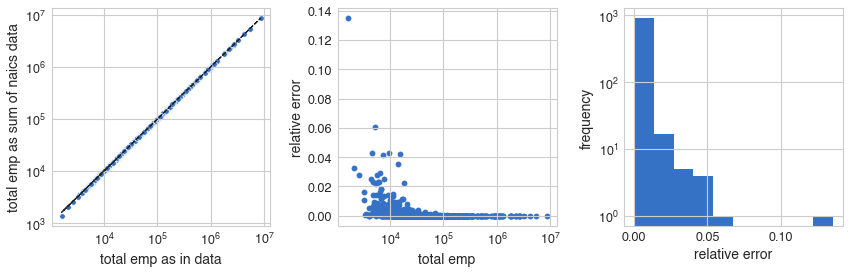

In [13]:
temp_df = df_msa

fig = plt.figure(figsize=(12, 4))
fs = 14
ax1 = fig.add_subplot(1, 3, 1)
ax1 = sns.scatterplot(data=temp_df, x="total_emp", y="summed_emp")
ax1.plot(temp_df['total_emp'], temp_df['total_emp'], 'k--')
ax1.set_xlabel('total emp as in data', fontsize=fs, weight='bold')
ax1.set_ylabel('total emp as sum of naics data', fontsize=fs, weight='bold')
ax1.set_xscale('log')
ax1.set_yscale('log')

ax2 = fig.add_subplot(1, 3, 2)
rel_error = (temp_df['total_emp']-temp_df['summed_emp']) * 1.0/temp_df['total_emp']
ax2.scatter(temp_df['total_emp'], rel_error)
ax2.set_ylabel('relative error', fontsize=fs, weight='bold')
ax2.set_xlabel('total emp', fontsize=fs, weight='bold')
ax2.set_xscale('log')

ax3 = fig.add_subplot(1, 3, 3)
ax3.hist(rel_error, log=True)
ax3.set_xlabel('relative error', fontsize=fs, weight='bold')
ax3.set_ylabel('frequency', fontsize=fs, weight='bold')
plt.tight_layout()

plt.savefig(plot_path+"error_in_total_emp_vs_summed_emp.png")

In [7]:
print('mean and mode')
for categ in emp_naics_keys:
    print(categ,np.median(df_msa[categ]),np.mean(df_msa[categ]))

print( np.median(np.ravel(df_msa[emp_naics_keys].values)))

mean and mode
naics_11 36.0 134.4458735262594
naics_21 45.0 453.7041800643087
naics_22 121.0 636.1779206859593
naics_23 1138.0 6995.875669882101
naics_31 3653.0 11821.898177920686
naics_42 814.0 6260.3311897106105
naics_44 3473.0 16060.762057877813
naics_48 874.0 5174.16934619507
naics_51 312.0 3733.1007502679527
naics_52 678.0 6554.486602357985
naics_53 260.0 2319.514469453376
naics_54 693.0 9304.122186495177
naics_55 186.0 3720.994640943194
naics_56 1033.0 8138.322615219721
naics_62 4257.0 21020.809217577706
naics_71 315.0 2551.6666666666665
naics_72 2886.0 14830.124330117898
naics_81 982.0 5776.714898177921
759.0


# Summary plots

## make table

In [8]:
summary_folder='/Users/ashish/Dropbox/research/James/summary plots/'
table = df_msa[['msa','msa_name']+full_emp_naics_keys]

renaming_dict={}
for idx, key in enumerate(full_emp_naics_keys):
    new_key=sector_from_naics(df_naics_ref, key, shorten=True)
    renaming_dict.update({key:new_key})
table=table.rename(columns=renaming_dict)    
table.to_csv(summary_folder+'table.csv')



FileNotFoundError: [Errno 2] No such file or directory: '/Users/ashish/Dropbox/research/James/summary plots/table.csv'

## histogram of employments

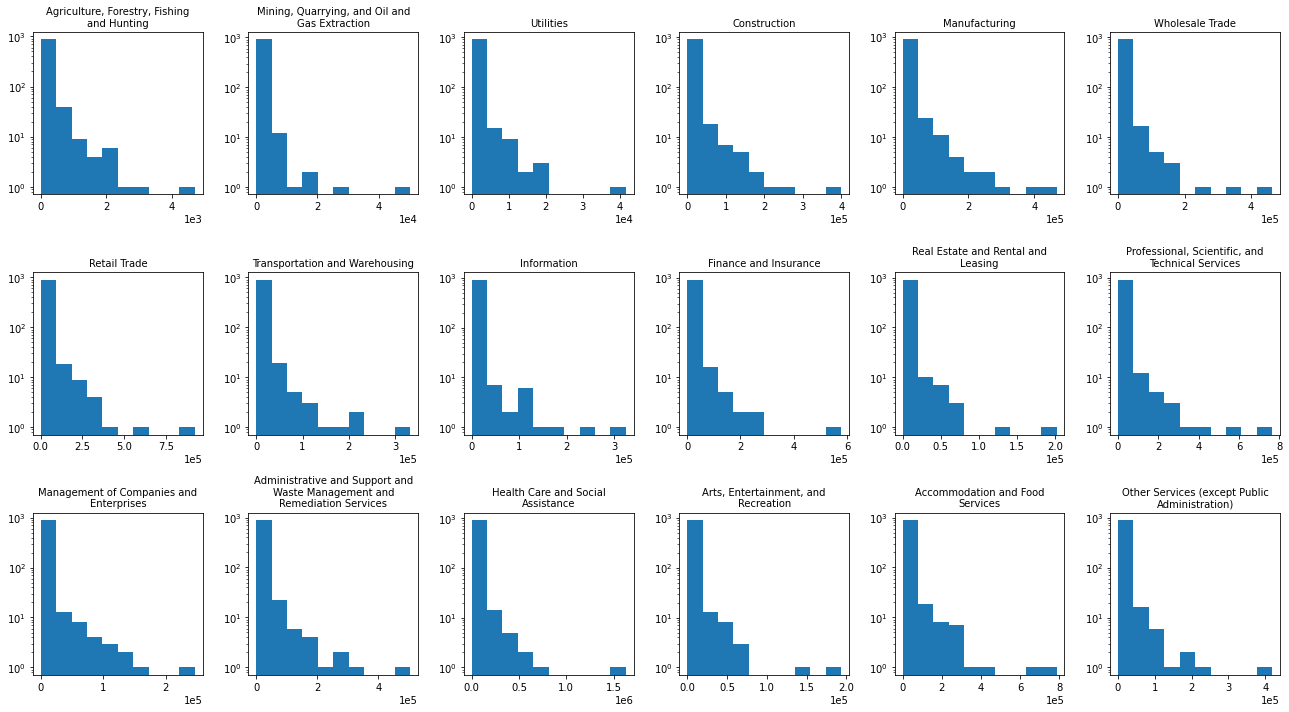

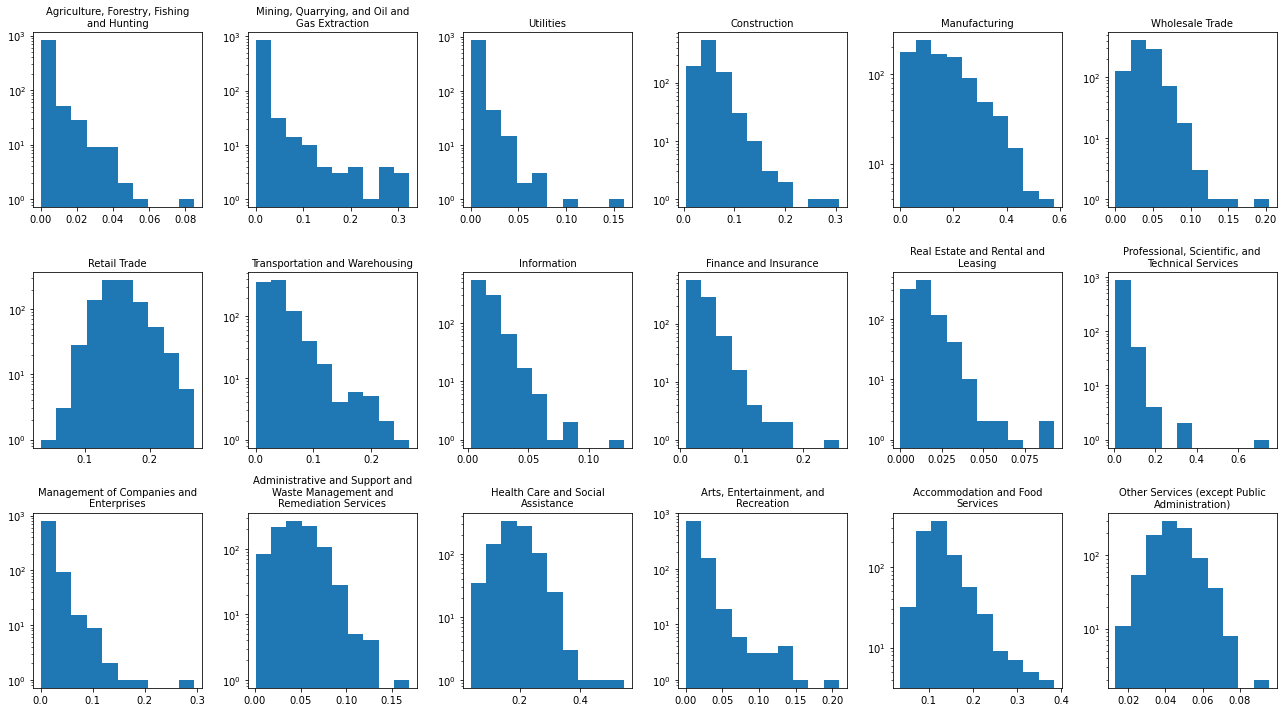

In [52]:
## plot of numbers of employees, and fractions of employees
fig = plt.figure(figsize=(18,10))
for idx, key in enumerate(emp_naics_keys):
    ax1= fig.add_subplot(3, 6, idx+1)
    frac_data =df_msa[key].values
#     qqplot(frac_data, line='s',ax=ax1)
    ax1.hist(frac_data,log=True)
    wrapped_title="\n".join(wrap(sector_from_naics(df_naics_ref, key), 30))
    ax1.set_title(wrapped_title,fontsize=fontSizeSmall)
    ax1.ticklabel_format(axis='x', style='sci',scilimits=(-3,3))
plt.tight_layout()
fig.patch.set_facecolor('white')
plt.savefig(summary_folder+'Numbers_hist.pdf')
plt.show()

fig = plt.figure(figsize=(18,10))
for idx, key in enumerate(emp_naics_keys):
    ax1= fig.add_subplot(3, 6, idx+1)
    frac_data =df_msa_fractions[key].values
    ax1.hist(frac_data,log=True)
    wrapped_title="\n".join(wrap(sector_from_naics(df_naics_ref, key), 30))
    ax1.set_title(wrapped_title,fontsize=fontSizeSmall)
#     ax1.ticklabel_format(axis='both', style='sci',scilimits=(-3,3))
plt.tight_layout()
fig.patch.set_facecolor('white')

plt.savefig(summary_folder+'fractions_hist.pdf')

## Explained variance by principal components

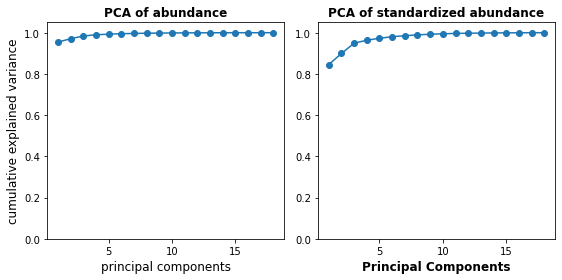

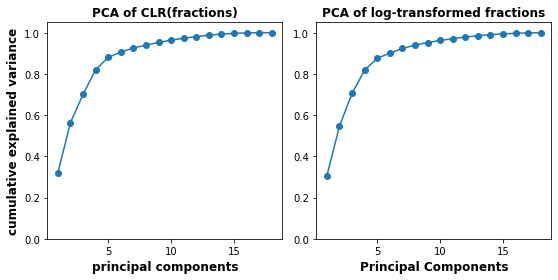

In [30]:
fs=12

fig2 = plt.figure(figsize=(8, 4))
ax1 = fig2.add_subplot(1,2,1)
PCA_obj = PCA(n_components=len(emp_naics_keys))
pca_vals = PCA_obj.fit_transform( df_msa[emp_naics_keys])
ax1.plot(1+np.arange(len(emp_naics_keys)),
                np.cumsum(PCA_obj.explained_variance_ratio_), '-o')
ax1.set_ylim(0,1.05)
ax1.set_title(r'PCA of abundance', fontweight='bold')
ax1.set_xlabel('principal components', fontsize=fs)
ax1.set_ylabel('cumulative explained variance', fontsize=fs)
ax2 = fig2.add_subplot(1, 2, 2)
stdzd_vals = StandardScaler().fit_transform( df_msa[emp_naics_keys])
PCA_obj = PCA(n_components=len(emp_naics_keys))
pca_vals = PCA_obj.fit_transform(stdzd_vals)
ax2.plot(1+np.arange(len(emp_naics_keys)),
                np.cumsum(PCA_obj.explained_variance_ratio_), '-o')
ax2.set_title(r'PCA of standardized abundance', fontweight='bold')
ax2.set_xlabel('Principal Components',  fontweight='bold',fontSize=fs)
ax2.set_ylim(0,1.05)
fig2.patch.set_facecolor('white')
plt.tight_layout()
plt.savefig(summary_folder+'ExplainedVariance_N.pdf')

fig2 = plt.figure(figsize=(8, 4))
ax1 = fig2.add_subplot(1,2,1)
PCA_obj = PCA(n_components=len(emp_naics_keys))
pca_vals = PCA_obj.fit_transform( df_msa_CLRf[emp_naics_keys])
ax1.plot(1+np.arange(len(emp_naics_keys)),
                np.cumsum(PCA_obj.explained_variance_ratio_), '-o')
ax1.set_ylim(0,1.05)
ax1.set_title(r'PCA of CLR(fractions)', fontweight='bold')
ax1.set_xlabel('principal components',  fontweight='bold',fontSize=fs)
ax1.set_ylabel('cumulative explained variance', fontweight='bold',fontSize=fs)
ax2 = fig2.add_subplot(1, 2, 2)
# stdzd_vals = StandardScaler().fit_transform( df_msa_CLRf[emp_naics_keys])
PCA_obj = PCA(n_components=len(emp_naics_keys))
pca_vals = PCA_obj.fit_transform(df_msa_logF[emp_naics_keys])
ax2.plot(1+np.arange(len(emp_naics_keys)),
                np.cumsum(PCA_obj.explained_variance_ratio_), '-o')
ax2.set_title(r'PCA of log-transformed fractions', fontweight='bold')
ax2.set_xlabel('Principal Components', fontweight='bold',fontSize=fs)
ax2.set_ylim(0,1.05)
fig2.patch.set_facecolor('white')
plt.tight_layout()
plt.savefig(summary_folder+'ExplainedVariance_F.pdf')

## Identity of the PCs

for absolute abundance, PC1, the city size,  dominates explained variance  

[0.09, 0.07, 0.24, 0.25, 0.23, 0.25, 0.26, 0.25, 0.24, 0.25, 0.25, 0.24, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]


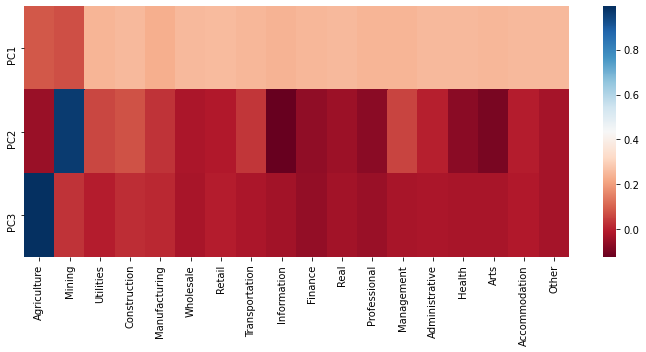

In [28]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot()
target_dim_PCA = 3#len(emp_naics_keys)
feature_names = [sector_from_naics(df_naics_ref, emp_naics_keys[i],shorten=True) for i in range(len(emp_naics_keys))]
PCA_obj = PCA(n_components=target_dim_PCA)
# pca_vals = PCA_obj.fit_transform(df_msa[emp_naics_keys])
stdzd_vals = StandardScaler().fit_transform( df_msa[emp_naics_keys])
pca_vals = PCA_obj.fit_transform(stdzd_vals)
ax1 = sns.heatmap(PCA_obj.components_,
                  cmap='RdBu',
                  yticklabels=["PC"+str(x)
                               for x in range(1, PCA_obj.n_components_+1)],
                  xticklabels=feature_names, ax=ax1)
fig.patch.set_facecolor('white')
plt.tight_layout()
plt.savefig(summary_folder+'PC1_N.pdf')

rounded=[round(k,2) for k in PCA_obj.components_[0]]
print (rounded)
# print (PCA_obj.components_[0])

for relative abundance, many PCs contribute.  
if pure fractions are used, then industries that are small like agriculture do not contribute to variation

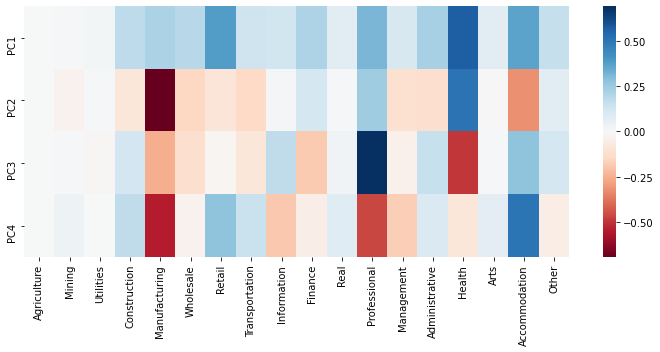

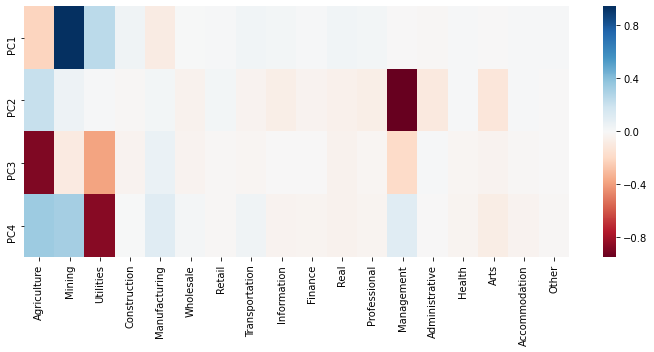

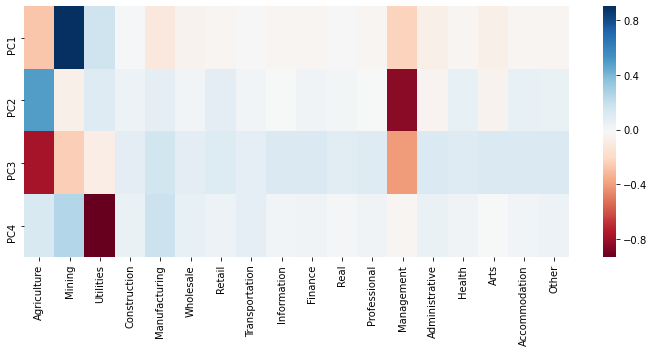

In [27]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot()
target_dim_PCA = 4#len(emp_naics_keys)
feature_names = [sector_from_naics(df_naics_ref, emp_naics_keys[i],shorten=True) for i in range(len(emp_naics_keys))]
PCA_obj = PCA(n_components=target_dim_PCA)
# pca_vals = PCA_obj.fit_transform(df_msa[emp_naics_keys])

pca_vals = PCA_obj.fit_transform(df_msa[emp_naics_keys])
ax1 = sns.heatmap(PCA_obj.components_,
                  cmap='RdBu',
                  yticklabels=["PC"+str(x)
                               for x in range(1, PCA_obj.n_components_+1)],
                  xticklabels=feature_names, ax=ax1)
fig.patch.set_facecolor('white')
plt.tight_layout()
plt.savefig(summary_folder+'PCs_F.pdf')


fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot()
target_dim_PCA = 4#len(emp_naics_keys)
feature_names = [sector_from_naics(df_naics_ref, emp_naics_keys[i],shorten=True) for i in range(len(emp_naics_keys))]
PCA_obj = PCA(n_components=target_dim_PCA)
# pca_vals = PCA_obj.fit_transform(df_msa[emp_naics_keys])

pca_vals = PCA_obj.fit_transform(df_msa_logF[emp_naics_keys])
ax1 = sns.heatmap(PCA_obj.components_,
                  cmap='RdBu',
                  yticklabels=["PC"+str(x)
                               for x in range(1, PCA_obj.n_components_+1)],
                  xticklabels=feature_names, ax=ax1)
fig.patch.set_facecolor('white')
plt.tight_layout()
plt.savefig(summary_folder+'PCs_logF.pdf')


fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot()
target_dim_PCA = 4#len(emp_naics_keys)
feature_names = [sector_from_naics(df_naics_ref, emp_naics_keys[i],shorten=True) for i in range(len(emp_naics_keys))]
PCA_obj = PCA(n_components=target_dim_PCA)
# pca_vals = PCA_obj.fit_transform(df_msa[emp_naics_keys])

pca_vals = PCA_obj.fit_transform(df_msa_CLRf[emp_naics_keys])
ax1 = sns.heatmap(PCA_obj.components_,
                  cmap='RdBu',
                  yticklabels=["PC"+str(x)
                               for x in range(1, PCA_obj.n_components_+1)],
                  xticklabels=feature_names, ax=ax1)
fig.patch.set_facecolor('white')
plt.tight_layout()
plt.savefig(summary_folder+'PCs_CLRF.pdf')



# rounded=[round(k,2) for k in PCA_obj.components_[0]]
# print (rounded)

## PCA biplot

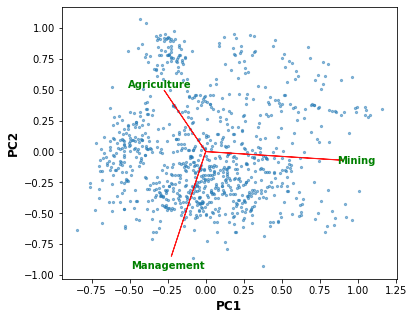

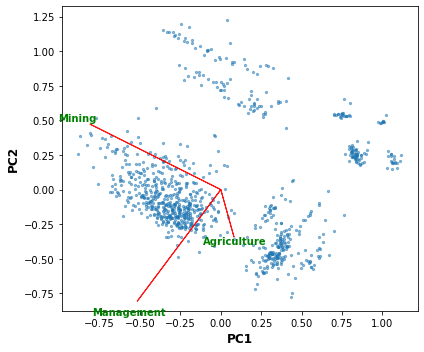

In [10]:
feature_names = [sector_from_naics(df_naics_ref, emp_naics_keys[i],shorten=True) for i in range(len(emp_naics_keys))]
PCA_biplot(df_msa_CLRf,labels=feature_names)
# PCA_biplot(df_msa_l,labels=feature_names)
plt.tight_layout()
# plt.savefig(summary_folder+'PCs_biplot_CLRf.pdf')

# Exploratory analysis

[Read data](#Read-processed-data-table)

## Visualization functions PCA, NMDS

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import MDS

def plot_PCA(ax, df_pca, feature_keys, color_by=None, fig=None, standardized=False, plot_nonStandard_PCA=False, label_key=None, fs=10, ms=10):

    stdzd_vals = df_pca.loc[:, feature_keys].values
    if plot_nonStandard_PCA:
        print('plotting PCA without standardizing.')
    elif not standardized:  # standardize data if it was not standardized already
        stdzd_vals = StandardScaler().fit_transform(stdzd_vals)

    PCA_obj = PCA(n_components=2)
    pca_vals = PCA_obj.fit_transform(stdzd_vals)
    print('Explained variation per principal component: {}'.format(
        PCA_obj.explained_variance_ratio_))
    pca_vals_df = pd.DataFrame(data=pca_vals, columns=['PC 1', 'PC 2'])
    if label_key is None and color_by is None:
        ax.scatter(pca_vals[:, 0], pca_vals[:, 1],  s=ms)
    elif color_by is not None:
        cplot=ax.scatter(pca_vals[:, 0], pca_vals[:, 1],  s=ms, c=color_by['values'], cmap='plasma')
        cbar=fig.colorbar(cplot,ax=ax)
        cbar.set_label(color_by['label'])
    elif label_key is not None:
        pca_vals_df['city_type'] = df_pca[label_key]
        grouped = pca_vals_df.groupby('city_type')
        if grouped.ngroups < 6:
            color_list = create_color_list(scheme_name='sns_tab10')
        else:
            color_list = create_color_list(
                scheme_name='sns_tab10', num_colors=grouped.ngroups)
        ctr = 0
        for key, group in grouped:
            group.plot(ax=ax, kind='scatter', x='PC 1', y='PC 2',
                       label=key, color=color_list[ctr])
            ctr += 1
        if grouped.ngroups > 10:
            ax.legend(loc='best', ncol=int(grouped.ngroups/10), fontsize=fs/2)
    ax.set_xlabel('Principal Component - 1', fontweight='bold',fontSize=fs)
    ax.set_ylabel('Principal Component - 2', fontweight='bold',fontSize=fs)
    

    return ax, PCA_obj


def PCA_explained_variance(df_pca, feature_keys, ax=None, standardized=False,
                           plot_nonStandard_PCA=False, label_key=None, fs=10, ms=10):
    stdzd_vals = df_pca.loc[:, feature_keys].values
    if plot_nonStandard_PCA:
        print('plotting PCA without standardizing.')
    elif not standardized:
        stdzd_vals = StandardScaler().fit_transform(stdzd_vals)

    PCA_obj = PCA(n_components=len(feature_keys))
    pca_vals = PCA_obj.fit_transform(stdzd_vals)
    print('Explained variation per principal component: {}'.format(
        PCA_obj.explained_variance_ratio_))
    column_names_list = ['PC '+str(i+1) for i in range(len(feature_keys))]
    pca_vals_df = pd.DataFrame(data=pca_vals, columns=column_names_list)
    if ax is not None:
        ax.plot(1+np.arange(len(feature_keys)),
                np.cumsum(PCA_obj.explained_variance_ratio_), '-o')
    if plot_nonStandard_PCA:
        ax.set_xlabel('nonstandardized PCs', fontweight='bold',fontSize=fs)
        ax.set_ylabel('Cumulative Explained Variance', fontweight='bold',fontSize=fs)
    else:
        ax.set_xlabel('Principal Components', fontweight='bold',fontSize=fs)
        ax.set_ylabel('Cumulative Explained Variance', fontweight='bold',fontSize=fs)
    ax.set_ylim(-0.05,1.05)
    print('cumulative variance explained',np.cumsum(PCA_obj.explained_variance_ratio_))
    return ax, PCA_obj, pca_vals_df


def PCA_biplot(df_data,labels=None):
    PCA_obj = PCA(n_components=2)
    pca_vals = PCA_obj.fit_transform(df_data[emp_naics_keys])   
    fig = plt.figure(figsize=(6, 5))
    xs = pca_vals[:,0]
    ys = pca_vals[:,1]
    coeff=np.transpose(PCA_obj.components_[0:2, :])
    n = coeff.shape[0]
    scalex = 2.0/(xs.max() - xs.min())
    scaley = 2.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley,s=5,alpha=0.5)
    
    abs_coeffs=np.abs(coeff)
    cutoff=np.mean(abs_coeffs)+np.std(abs_coeffs)
    for i in range(n):
        if (np.abs(coeff[i,0])+np.abs(coeff[i,1]))> cutoff:
            plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.9)
            if labels is None:
                plt.text(coeff[i,0]* 1.1, coeff[i,1] * 1.1, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
            else:
                plt.text(coeff[i,0]* 1.1, coeff[i,1] * 1.1, labels[i], color = 'g', ha = 'center', va = 'center',fontweight='bold')
    plt.xlabel("PC{}".format(1), fontweight='bold',fontSize=fs)
    plt.ylabel("PC{}".format(2), fontweight='bold',fontSize=fs)
    fig.patch.set_facecolor('white')
    
    

def plot_NMDS(distances, ax, fs=10, ms=10,labels=None,mds=False):

    NMDS_obj = MDS(n_components=2, metric=mds, dissimilarity='precomputed', n_init=8, max_iter=600,
                  n_jobs=4)
    NMDS_coords=NMDS_obj.fit_transform(distances)

    if labels is None:
        ax.scatter(NMDS_coords[:, 0], NMDS_coords[:, 1],  s=ms)
    else:
        color_list = create_color_list(scheme_name='sns_tab10')
        i=0
        for group in list(set(labels)):
            idx_group=np.where(labels==group)[0]
            print('len(idx_group)',len(idx_group))
            ax.scatter(NMDS_coords[idx_group, 0], NMDS_coords[idx_group, 1],c=np.array(color_list[i])[np.newaxis,:],  s=ms, label=group)
            i+=1
        ax.legend(loc='best')
        print ('NMDS stress in 2D might be too high, check stress calculation')
#     ax.set_xlabel('# MDS Components', fontsize=fs)
#     ax.set_ylabel('Stress', fontsize=fs)     
    return ax

## PCA plots

We analyze city composition as both the number of people employed in different naics categories in a city, as well as fraction of people employed in the different naics categories in the city (similar to microbial ecology). We find that:

1. City size explains a majority of the variance. (irrespective of  data transformation, and subsetting.)

2. PCA plots of *fraction* data cluster by metro and micropolitan cities indicating that city size influences relative abundance systematically. (irrespective of transformation). The metro-micro classification also correlates with diversity. A gradient in diversity is observed in PCA plots due to this (but not observed in PCA of just metros!)

3. PCA plots of logF without standardizing might be better since fraction employed does have meaning. 

4. the main PCs are mining, management, agriculture and education.


Notes:
<br>

    - The distributions of both the number and fraction in a sector was right-skewed. Therefore, we log-transformed and box-cox transformed the data. (The transformations made data more normal. However, the data still was't close to passing a Shapiro-Wilk test of normality. )

    - PC-1 explains ~ 80% of the variance in transformed and bare data of the number of people employed in a city.  PC-1 measures city size---it corresponds to total employment in bare data, the product of employment, $\log ( \Pi_i \, N_i)$, in log transformed data, and a similar sum in the box-cox transformed data.

    - PCA of just Metro cities also have size as the first component which explains 80% of the variance.

    - data was standardized before PCA
    
    - Unclear if city size dominating is due to the power-law nature of city size
    
    - PCA plot when not standardized visualizes clusters better. The metro-micro classification correlates with institutional diversity. the gradient of diversity can be seen in the plot 
    
    - when restricted to just metros, PCs don't separate out diversity anymore. Additionally, even though clusters are apparent to the eye in the PCA plot kmedoids/means don't find these clusters.

### PCA plot of the log transformed data

Explained variation per principal component: [0.79 0.05]
PC1: [0.14 0.13 0.18 0.24 0.2  0.24 0.25 0.23 0.24 0.24 0.24 0.24 0.21 0.24
 0.21 0.25 0.23 0.25 0.25 0.21]
Explained variation per principal component: [0.19 0.12]


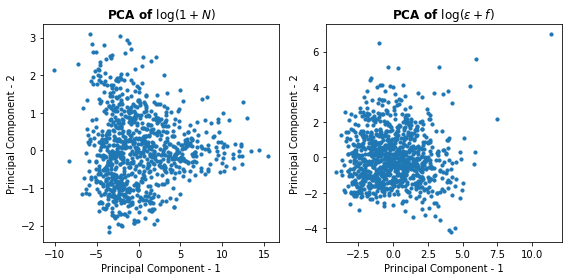

PC1: [-0.11 -0.15 -0.18 -0.23  0.27 -0.08 -0.06  0.03 -0.3  -0.19 -0.35 -0.36
 -0.23 -0.23 -0.21 -0.07 -0.29 -0.22 -0.19 -0.31]
Explained variation per principal component: [0.79 0.05]
Explained variation per principal component: [0.19 0.12]


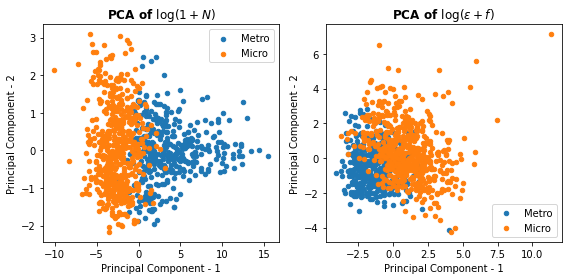

In [33]:
np.set_printoptions(precision=2)

fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(1, 2, 1)
# logtransformed abundances
sum_and_naics_keys = ['summed_emp'] + emp_naics_keys
logNemp = np.log10(1.0+df_msa.loc[:, sum_and_naics_keys].values)
df_msa_logN = pd.DataFrame(logNemp, columns=sum_and_naics_keys)
df_msa_logN['Metro']= df_msa['Metro']
df_msa_logN.loc[df_msa_logN['Metro'] == True, 'Metro'] = 'Metro'
df_msa_logN.loc[df_msa_logN['Metro'] == False, 'Metro'] = 'Micro'
ax1, PCA_object = plot_PCA(
    ax1, df_msa_logN, emp_naics_keys, standardized=False)
ax1.set_title(r'PCA of $\log (1 +N)$', fontweight='bold')
# print('here some naics categories contribute more to PC1 than tothers.')
print('PC1:', PCA_object.components_[0])

ax2 = fig.add_subplot(1, 2, 2)
# logtransformed fractions
df_msa_fractions = df_msa.copy()
df_msa_fractions[emp_naics_keys] = df_msa[emp_naics_keys].div(
    1.0*df_msa['summed_emp'], axis=0)
fracs = df_msa_fractions.loc[:, emp_naics_keys].values

pseudo_count=np.min(fracs[fracs>0]/10)
logfrac = np.log10(pseudo_count+fracs)
df_msa_logF = pd.DataFrame(logfrac, columns=emp_naics_keys)
df_msa_logF['Metro']= df_msa['Metro']
df_msa_logF.loc[df_msa_logF['Metro'] == True, 'Metro'] = 'Metro'
df_msa_logF.loc[df_msa_logF['Metro'] == False, 'Metro'] = 'Micro'
ax2, PCA_object = plot_PCA(
    ax2, df_msa_logF, emp_naics_keys, standardized=False)
ax2.set_title(r'PCA of $\log (\epsilon +f)$', fontweight='bold')
fig.patch.set_facecolor('white')
plt.tight_layout()
plt.show()
print('PC1:', PCA_object.components_[0])


fig2 = plt.figure(figsize=(8, 4))
ax1 = fig2.add_subplot(1, 2, 1)
ax1, PCA_object = plot_PCA(
    ax1, df_msa_logN, emp_naics_keys, standardized=False, label_key='Metro')
ax1.set_title(r'PCA of $\log (1 +N)$', fontweight='bold')
ax2 = fig2.add_subplot(1, 2, 2)
ax2, PCA_object = plot_PCA(
    ax2, df_msa_logF, emp_naics_keys, standardized=False, label_key='Metro')
ax2.set_title(r'PCA of $\log (\epsilon +f)$', fontweight='bold')

fig2.patch.set_facecolor('white')
plt.tight_layout()
plt.show()

### PCA plot of logF without standardizing.

plotting PCA without standardizing.
Explained variation per principal component: [0.72484295 0.09620945]
plotting PCA without standardizing.
Explained variation per principal component: [0.33395986 0.2656441 ]


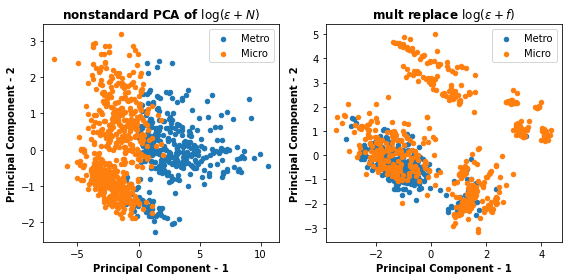

plotting PCA without standardizing.
Explained variation per principal component: [0.30707965 0.2396827 ]
plotting PCA without standardizing.
Explained variation per principal component: [0.33401886 0.26565014]


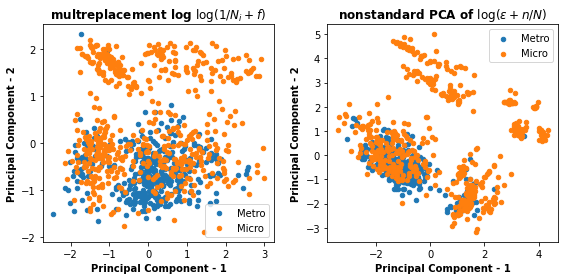

In [13]:


fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(1, 2, 1)

ax1, PCA_object = plot_PCA(
    ax1, df_msa_logN, emp_naics_keys, plot_nonStandard_PCA=True, label_key='Metro')
ax1.set_title(r'nonstandard PCA of $\log (\epsilon +N)$', fontweight='bold')


ax2 = fig.add_subplot(1, 2, 2)

ax2, PCA_object = plot_PCA(
    ax2, df_msa_logF, emp_naics_keys, plot_nonStandard_PCA=True, label_key='Metro')
ax2.set_title(r'mult replace $\log (\epsilon+f)$', fontweight='bold')
fig.patch.set_facecolor('white')
plt.tight_layout()
plt.show()


fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(1, 2, 1)

ax1, PCA_object = plot_PCA(
    ax1, df_msa_logF_1overN, emp_naics_keys, plot_nonStandard_PCA=True, label_key='Metro')
ax1.set_title(r'multreplacement log $\log (1/N_i+f)$', fontweight='bold')


ax2 = fig.add_subplot(1, 2, 2)

ax2, PCA_object = plot_PCA(
    ax2, df_msa_old_logF, emp_naics_keys, plot_nonStandard_PCA=True, label_key='Metro')
ax2.set_title(r'nonstandard PCA of $\log (\epsilon +n/N)$', fontweight='bold')
fig.patch.set_facecolor('white')
plt.tight_layout()
plt.show()

before the pseudo count was fixed, the micros clustered more strongly since the zeros were all the same.

plotting PCA without standardizing.
Explained variation per principal component: [0.72 0.1 ]
plotting PCA without standardizing.
Explained variation per principal component: [0.33 0.27]


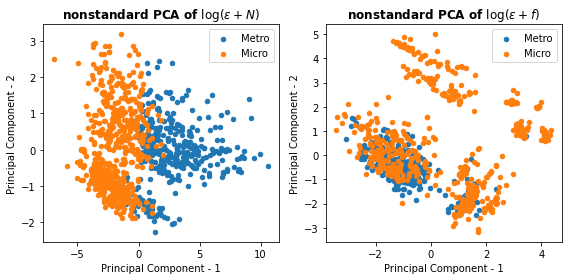

In [106]:
# np.set_printoptions(precision=2)

fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(1, 2, 1)

ax1, PCA_object = plot_PCA(
    ax1, df_msa_logN, emp_naics_keys, plot_nonStandard_PCA=True, label_key='Metro')
ax1.set_title(r'nonstandard PCA of $\log (\epsilon +N)$', fontweight='bold')


ax2 = fig.add_subplot(1, 2, 2)

ax2, PCA_object = plot_PCA(
    ax2, df_msa_logF, emp_naics_keys, plot_nonStandard_PCA=True, label_key='Metro')
ax2.set_title(r'nonstandard PCA of $\log (\epsilon +f)$', fontweight='bold')
fig.patch.set_facecolor('white')
plt.tight_layout()
plt.show()



NMDS plot of log transformed data

len(idx_group) 383
len(idx_group) 550
NMDS stress in 2D might be too high, check stress calculation
len(idx_group) 383
len(idx_group) 550
NMDS stress in 2D might be too high, check stress calculation
len(idx_group) 383
len(idx_group) 550
NMDS stress in 2D might be too high, check stress calculation
len(idx_group) 383
len(idx_group) 550
NMDS stress in 2D might be too high, check stress calculation


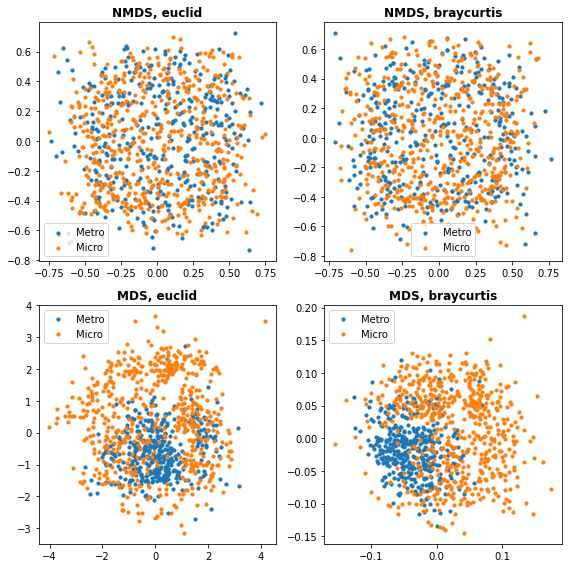

In [57]:
fig2 = plt.figure(figsize=(8, 8))
ax1 = fig2.add_subplot(2, 2, 1)
distances = compute_pairwise_distances(df_msa_logF[emp_naics_keys].values, 'euclidean')
ax1=plot_NMDS(distances, ax1, fs=10, ms=10,labels=df_msa_logF['Metro'])
ax1.set_title(r'NMDS, euclid', fontweight='bold')


ax2 = fig2.add_subplot(2, 2, 2)
distances = compute_pairwise_distances(df_msa_logF[emp_naics_keys].values, 'braycurtis')
ax2=plot_NMDS(distances, ax2, fs=10, ms=10,labels=df_msa_logF['Metro'])
ax2.set_title(r'NMDS, braycurtis', fontweight='bold')

ax3 = fig2.add_subplot(2, 2, 3)
distances = compute_pairwise_distances(df_msa_logF[emp_naics_keys].values, 'euclidean')
ax3=plot_NMDS(distances, ax3, fs=10, ms=10,labels=df_msa_logF['Metro'],mds=True)
ax3.set_title(r'MDS, euclid', fontweight='bold')


ax4 = fig2.add_subplot(2, 2, 4)
distances = compute_pairwise_distances(df_msa_logF[emp_naics_keys].values, 'braycurtis')
ax4=plot_NMDS(distances, ax4, fs=10, ms=10,labels=df_msa_logF['Metro'],mds=True)
ax4.set_title(r'MDS, braycurtis', fontweight='bold')

fig2.patch.set_facecolor('white')
plt.tight_layout()
plt.show()

### visualize the features and PCs

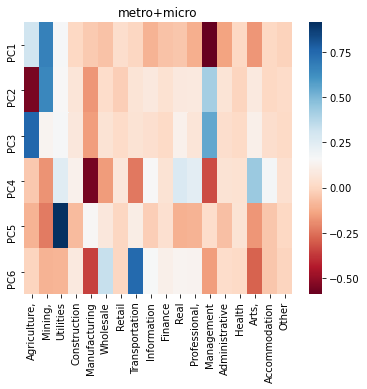

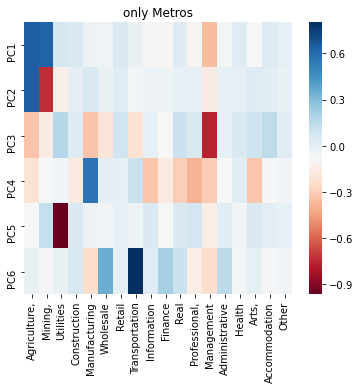

In [67]:
fig = plt.figure(figsize=(6, 5))
ax1 = fig.add_subplot()
target_dim_PCA = 6#len(emp_naics_keys)
feature_names = [sector_from_naics(df_naics_ref, emp_naics_keys[i],shorten=True) for i in range(len(emp_naics_keys))]

PCA_obj = PCA(n_components=target_dim_PCA)
pca_vals = PCA_obj.fit_transform(df_msa_logF[emp_naics_keys])
ax1 = sns.heatmap(PCA_obj.components_,
                  cmap='RdBu',
                  yticklabels=["PC"+str(x)
                               for x in range(1, PCA_obj.n_components_+1)],
                  xticklabels=feature_names, ax=ax1)
ax1.set_title('metro+micro')
fig.patch.set_facecolor('white')


fig2 = plt.figure(figsize=(6, 5))
df_metro_logF=df_msa_logF[df_msa_logF['Metro']=='Metro']
ax1 = fig2.add_subplot()
target_dim_PCA = 6#len(emp_naics_keys)
feature_names = [sector_from_naics(df_naics_ref, emp_naics_keys[i],shorten=True) for i in range(len(emp_naics_keys))]

PCA_obj = PCA(n_components=target_dim_PCA)
pca_vals = PCA_obj.fit_transform(df_metro_logF[emp_naics_keys])

ax1 = sns.heatmap(PCA_obj.components_,
                  cmap='RdBu',
                  yticklabels=["PC"+str(x)
                               for x in range(1, PCA_obj.n_components_+1)],
                  xticklabels=feature_names, ax=ax1)
ax1.set_title('only Metros')
fig2.patch.set_facecolor('white')

before multiplicative replacement of zeros

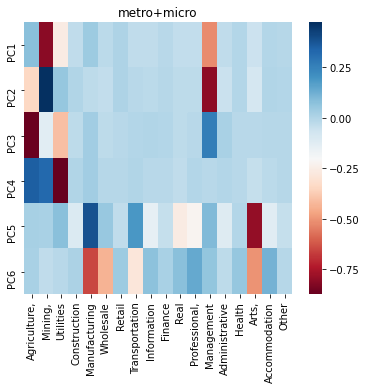

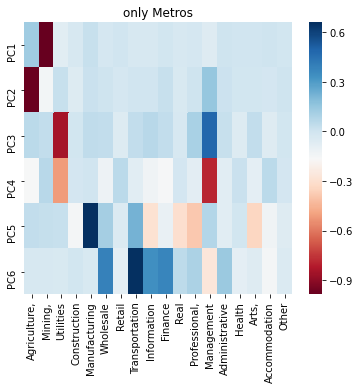

In [38]:
#
fig = plt.figure(figsize=(6, 5))
ax1 = fig.add_subplot()
target_dim_PCA = 6#len(emp_naics_keys)
feature_names = [sector_from_naics(df_naics_ref, emp_naics_keys[i],shorten=True) for i in range(len(emp_naics_keys))]

PCA_obj = PCA(n_components=target_dim_PCA)
pca_vals = PCA_obj.fit_transform(df_msa_logF[emp_naics_keys])
ax1 = sns.heatmap(PCA_obj.components_,
                  cmap='RdBu',
                  yticklabels=["PC"+str(x)
                               for x in range(1, PCA_obj.n_components_+1)],
                  xticklabels=feature_names, ax=ax1)
ax1.set_title('metro+micro')
fig.patch.set_facecolor('white')


fig2 = plt.figure(figsize=(6, 5))
df_metro_logF=df_msa_logF[df_msa_logF['Metro']=='Metro']
ax1 = fig2.add_subplot()
target_dim_PCA = 6#len(emp_naics_keys)
feature_names = [sector_from_naics(df_naics_ref, emp_naics_keys[i],shorten=True) for i in range(len(emp_naics_keys))]

PCA_obj = PCA(n_components=target_dim_PCA)
pca_vals = PCA_obj.fit_transform(df_metro_logF[emp_naics_keys])

ax1 = sns.heatmap(PCA_obj.components_,
                  cmap='RdBu',
                  yticklabels=["PC"+str(x)
                               for x in range(1, PCA_obj.n_components_+1)],
                  xticklabels=feature_names, ax=ax1)
ax1.set_title('only Metros')
fig2.patch.set_facecolor('white')

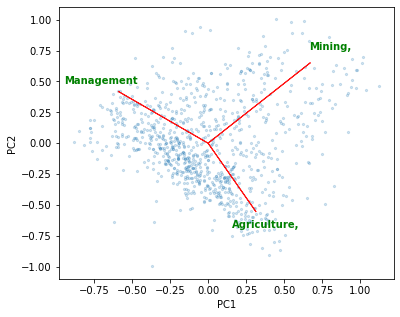

In [68]:
feature_names = [sector_from_naics(df_naics_ref, emp_naics_keys[i],shorten=True) for i in range(len(emp_naics_keys))]
PCA_biplot(df_msa_logF,labels=feature_names)
plt.show()

befoere multiplicative replacement of zeros

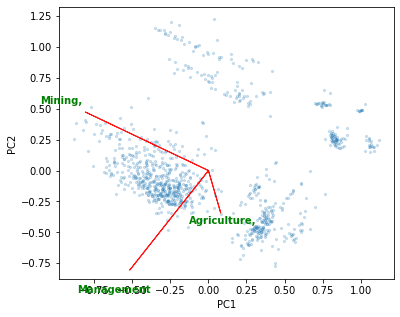

In [11]:
feature_names = [sector_from_naics(df_naics_ref, emp_naics_keys[i],shorten=True) for i in range(len(emp_naics_keys))]
PCA_biplot(df_msa_logF,labels=feature_names)
plt.show()

For only Metros

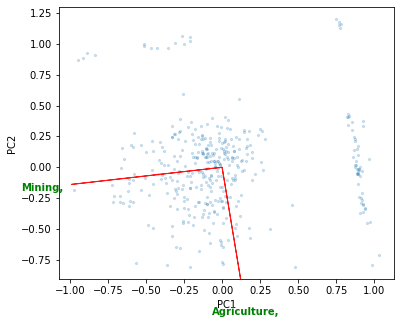

In [39]:
feature_names = [sector_from_naics(df_naics_ref, emp_naics_keys[i],shorten=True) for i in range(len(emp_naics_keys))]
PCA_biplot(df_metro_logF,labels=feature_names)
plt.show()

#### PCA directions when education was included

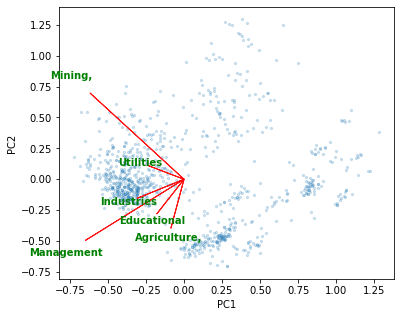

In [89]:
feature_names = [sector_from_naics(df_naics_ref, emp_naics_keys[i],shorten=True) for i in range(len(emp_naics_keys))]
PCA_biplot(df_msa_logF,labels=feature_names)
plt.show()

### PCA plot of logF colored by diversity

PCA plot separates cities with diversity. Metros are more diverse than micros

plotting PCA without standardizing.
Explained variation per principal component: [0.3  0.24]
plotting PCA without standardizing.
Explained variation per principal component: [0.3  0.24]


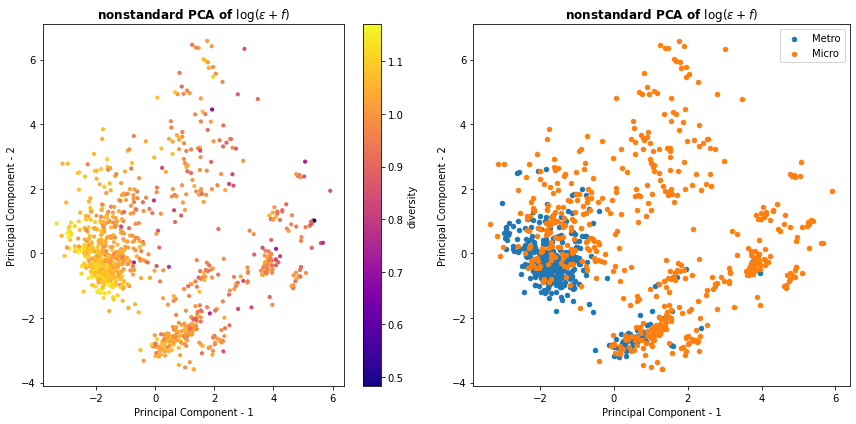

In [16]:
np.set_printoptions(precision=2)

fig = plt.figure(figsize=(12, 6))
Fi=df_msa_fractions[emp_naics_keys].values
log_Fi=df_msa_logF[emp_naics_keys].values
diversity=-np.sum(Fi*log_Fi,axis=1)
color_by={'values':diversity, 'label':'diversity'}
ax1 = fig.add_subplot(1, 2, 1)
ax1, PCA_object = plot_PCA(
    ax1, df_msa_logF, emp_naics_keys, plot_nonStandard_PCA=True, color_by=color_by,fig=fig)
ax1.set_title(r'nonstandard PCA of $\log (\epsilon +f)$', fontweight='bold')


ax2 = fig.add_subplot(1, 2, 2)

ax2, PCA_object = plot_PCA(
    ax2, df_msa_logF, emp_naics_keys, plot_nonStandard_PCA=True, label_key='Metro')
ax2.set_title(r'nonstandard PCA of $\log (\epsilon +f)$', fontweight='bold')
fig.patch.set_facecolor('white')
plt.tight_layout()
plt.show()


### PCA of CLR(f)
Metros and micros are not well separated in the CLR plot

Explained variation per principal component: [0.37 0.11]
PC1: [-0.09 -0.19 -0.15  0.26  0.18  0.16  0.35  0.15  0.25  0.29  0.21  0.22
 -0.22  0.2   0.32  0.04  0.33  0.35]
plotting PCA without standardizing.
Explained variation per principal component: [0.33 0.27]
PC1: [-0.37  0.89  0.15 -0.04 -0.11 -0.06 -0.06 -0.04 -0.04 -0.05 -0.04 -0.04
  0.09 -0.05 -0.06 -0.05 -0.06 -0.06]


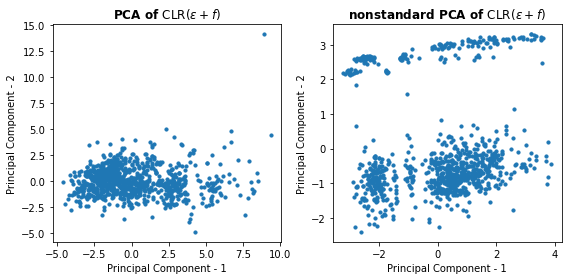

In [13]:
np.set_printoptions(precision=2)

fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(1, 2, 1)

ax1, PCA_object = plot_PCA(
    ax1, df_msa_CLRf, emp_naics_keys, plot_nonStandard_PCA=False)
ax1.set_title(r'PCA of $\mathsf{CLR}(\epsilon +f)$', fontweight='bold')

print('PC1:', PCA_object.components_[0])
ax2 = fig.add_subplot(1, 2, 2)

ax2, PCA_object = plot_PCA(
    ax2, df_msa_CLRf, emp_naics_keys, plot_nonStandard_PCA=True)
ax2.set_title(
    r'nonstandard PCA of $\mathsf{CLR}(\epsilon +f)$', fontweight='bold')
print('PC1:', PCA_object.components_[0])
fig.patch.set_facecolor('white')
plt.tight_layout()
plt.show()

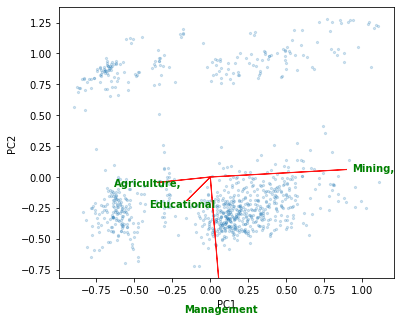

In [90]:
feature_names = [sector_from_naics(df_naics_ref, emp_naics_keys[i],shorten=True) for i in range(len(emp_naics_keys))]
PCA_biplot(df_msa_CLRf,labels=feature_names)
plt.show()

NMDS of CLR(f)

len(idx_group) 550
len(idx_group) 383
NMDS stress in 2D might be too high, check stress calculation
len(idx_group) 550
len(idx_group) 383
NMDS stress in 2D might be too high, check stress calculation
len(idx_group) 550
len(idx_group) 383
NMDS stress in 2D might be too high, check stress calculation
len(idx_group) 550
len(idx_group) 383
NMDS stress in 2D might be too high, check stress calculation


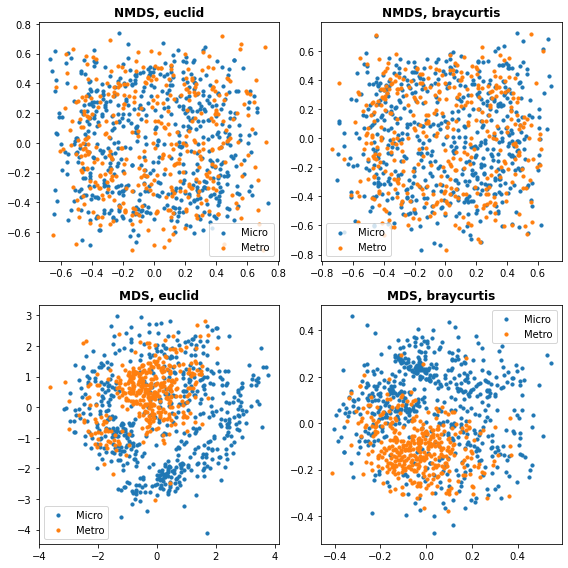

In [19]:
fig2 = plt.figure(figsize=(8, 8))
ax1 = fig2.add_subplot(2, 2, 1)
distances = compute_pairwise_distances( df_msa_CLRf[emp_naics_keys].values, 'euclidean')
ax1=plot_NMDS(distances, ax1, fs=10, ms=10,labels=df_msa_logF['Metro'])
ax1.set_title(r'NMDS, euclid', fontweight='bold')


ax2 = fig2.add_subplot(2, 2, 2)
distances = compute_pairwise_distances( df_msa_CLRf[emp_naics_keys].values, 'braycurtis')
ax2=plot_NMDS(distances, ax2, fs=10, ms=10,labels=df_msa_logF['Metro'])
ax2.set_title(r'NMDS, braycurtis', fontweight='bold')

ax3 = fig2.add_subplot(2, 2, 3)
distances = compute_pairwise_distances( df_msa_CLRf[emp_naics_keys].values, 'euclidean')
ax3=plot_NMDS(distances, ax3, fs=10, ms=10,labels=df_msa_logF['Metro'],mds=True)
ax3.set_title(r'MDS, euclid', fontweight='bold')


ax4 = fig2.add_subplot(2, 2, 4)
distances = compute_pairwise_distances( df_msa_CLRf[emp_naics_keys].values, 'braycurtis')
ax4=plot_NMDS(distances, ax4, fs=10, ms=10,labels=df_msa_logF['Metro'],mds=True)
ax4.set_title(r'MDS, braycurtis', fontweight='bold')

fig2.patch.set_facecolor('white')
plt.tight_layout()
plt.show()

### PCA plot of the bare data (which is not normal)

Explained variation per principal component: [0.85 0.05]
PC1: [0.08 0.07 0.23 0.24 0.22 0.24 0.24 0.23 0.23 0.24 0.24 0.23 0.23 0.24
 0.23 0.24 0.24 0.24 0.24 0.23]
Explained variation per principal component: [0.15 0.11]
PC1: [ 0.01  0.06  0.06  0.21 -0.46 -0.19  0.31 -0.18  0.13  0.02  0.41  0.14
 -0.09  0.04 -0.07  0.09  0.33  0.44  0.16  0.09]
Explained variation per principal component: [0.85 0.05]
Explained variation per principal component: [0.15 0.11]


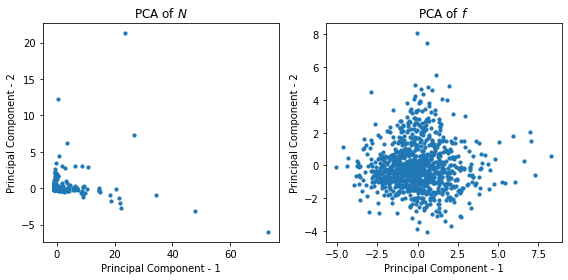

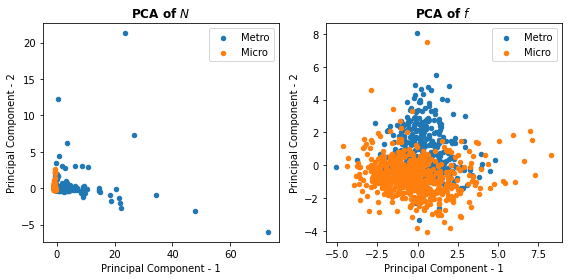

In [33]:
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(1, 2, 1)
# logtransformed abundances
sum_and_naics_keys = ['summed_emp'] + emp_naics_keys
df_msa2 = df_msa.copy()
df_msa2.loc[df_msa2['Metro'] == True, 'Metro'] = 'Metro'
df_msa2.loc[df_msa2['Metro'] == False, 'Metro'] = 'Micro'
ax1, PCA_object = plot_PCA(ax1, df_msa2, emp_naics_keys, standardized=False)
ax1.set_title(r'PCA of $N$')
# print('here some naics categories contribute more to PC1 than tothers.')
print('PC1:', PCA_object.components_[0])

ax2 = fig.add_subplot(1, 2, 2)
# logtransformed fractions
df_msa_fractions = df_msa.copy()
df_msa_fractions[emp_naics_keys] = df_msa[emp_naics_keys].div(
    1.0*df_msa['summed_emp'], axis=0)
df_msa_fractions.loc[df_msa_fractions['Metro'] == True, 'Metro'] = 'Metro'
df_msa_fractions.loc[df_msa_fractions['Metro'] == False, 'Metro'] = 'Micro'
ax2, PCA_object = plot_PCA(ax2, df_msa_fractions,
                           emp_naics_keys, standardized=False)
ax2.set_title(r'PCA of $f$')
fig.patch.set_facecolor('white')
plt.tight_layout()
print('PC1:', PCA_object.components_[0])


fig2 = plt.figure(figsize=(8, 4))
ax1 = fig2.add_subplot(1, 2, 1)
ax1, PCA_object = plot_PCA(
    ax1, df_msa2, emp_naics_keys, standardized=False, label_key='Metro')
ax1.set_title(r'PCA of $N$', fontweight='bold')
ax2 = fig2.add_subplot(1, 2, 2)
ax2, PCA_object = plot_PCA(
    ax2, df_msa_fractions, emp_naics_keys, standardized=False, label_key='Metro')
ax2.set_title(r'PCA of $f$', fontweight='bold')

fig2.patch.set_facecolor('white')
plt.tight_layout()
plt.show()

### PCA of box-cox transformed data

Explained variation per principal component: [0.77 0.05]
PC1: [-0.14 -0.13 -0.19 -0.24 -0.21 -0.23 -0.25 -0.22 -0.24 -0.24 -0.24 -0.24
 -0.22 -0.24 -0.22 -0.24 -0.23 -0.25 -0.25 -0.2 ]
Explained variation per principal component: [0.19 0.13]
PC1: [-0.02 -0.13 -0.1  -0.24  0.39  0.03 -0.11  0.09 -0.3  -0.19 -0.37 -0.36
 -0.16 -0.17 -0.13 -0.07 -0.31 -0.28 -0.18 -0.27]
Explained variation per principal component: [0.77 0.05]
Explained variation per principal component: [0.19 0.13]


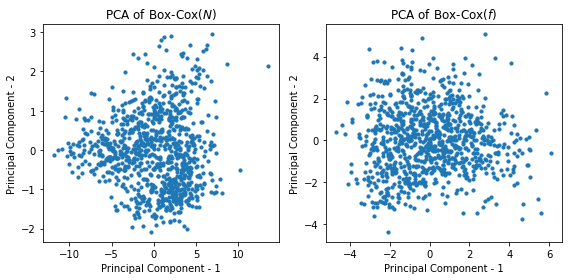

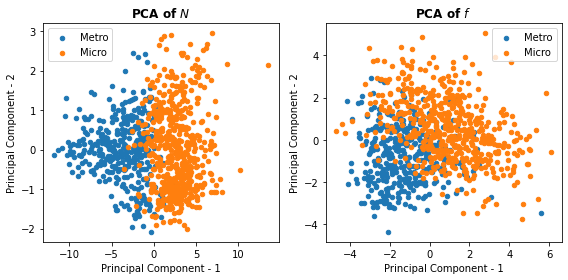

In [34]:
from scipy import stats

fig = plt.figure(figsize=(8, 4))
ax1= fig.add_subplot(1,2,1)
# transformed abundances
sum_and_naics_keys=['summed_emp']+ emp_naics_keys
df_boxCox={}
df_boxCox_Lambda={}

for idx, key in enumerate(sum_and_naics_keys):
    Nemp_data =df_msa[key].values      
    boxcox_N, boxcox_lambda =stats.boxcox(1.0+Nemp_data) 
    df_boxCox.update({key:boxcox_N})
    df_boxCox_Lambda.update({key:boxcox_lambda})
df_boxCox_N = pd.DataFrame.from_dict(df_boxCox)
df_boxCox_Lambda_N = pd.DataFrame(df_boxCox_Lambda, index=[0])
df_boxCox_N['Metro']=df_msa['Metro']
df_boxCox_N.loc[df_boxCox_N['Metro'] == True, 'Metro'] = 'Metro'
df_boxCox_N.loc[df_boxCox_N['Metro'] == False, 'Metro'] = 'Micro'
ax1, PCA_object=plot_PCA(ax1, df_boxCox_N, emp_naics_keys, standardized=False)
ax1.set_title(r'PCA of Box-Cox($N$)')
# print('here some naics categories contribute more to PC1 than tothers.')
print('PC1:', PCA_object.components_[0])

ax2= fig.add_subplot(1,2,2)
# boxcox transformation on fractions
df_msa_fractions = df_msa.copy()
df_msa_fractions[emp_naics_keys] = df_msa[emp_naics_keys].div(
    1.0*df_msa['summed_emp'], axis=0)
df_boxCox = {}
df_boxCox_Lambda = {}
for idx, key in enumerate(emp_naics_keys):
    frac_data = df_msa_fractions[key].values
    pseudo_count = np.min(frac_data[frac_data > 0])/10
    boxcox_fracs, boxcox_lambda = stats.boxcox(frac_data + pseudo_count)
    df_boxCox.update({key: boxcox_fracs})
    df_boxCox_Lambda.update({key: boxcox_lambda})
df_boxCox_F = pd.DataFrame.from_dict(df_boxCox)
df_boxCox_Lambda = pd.DataFrame(df_boxCox_Lambda, index=[0])
df_boxCox_F['Metro']=df_msa['Metro']
df_boxCox_F.loc[df_boxCox_F['Metro'] == True, 'Metro'] = 'Metro'
df_boxCox_F.loc[df_boxCox_F['Metro'] == False, 'Metro'] = 'Micro'

ax2, PCA_object=plot_PCA(ax2, df_boxCox_F, emp_naics_keys, standardized=False)
ax2.set_title(r'PCA of Box-Cox($f$)')
print('PC1:', PCA_object.components_[0])

fig.patch.set_facecolor('white')
plt.tight_layout()



fig2 = plt.figure(figsize=(8, 4))
ax1 = fig2.add_subplot(1, 2, 1)
ax1, PCA_object = plot_PCA(
    ax1, df_boxCox_N, emp_naics_keys, standardized=False, label_key='Metro')
ax1.set_title(r'PCA of $N$', fontweight='bold')
ax2 = fig2.add_subplot(1, 2, 2)
ax2, PCA_object = plot_PCA(
    ax2, df_boxCox_F, emp_naics_keys, standardized=False, label_key='Metro')
ax2.set_title(r'PCA of $f$', fontweight='bold')

fig2.patch.set_facecolor('white')
plt.tight_layout()
plt.show()

### PCA of only metros

Even when restricting data to just Metros, the first component explains most of the variance.

Explained variation per principal component: [0.75 0.11]
PC1: [0.16 0.25 0.22 0.23 0.19 0.25 0.2  0.24 0.27 0.25 0.24 0.27 0.32 0.24
 0.2  0.25 0.21 0.22]
Explained variation per principal component: [0.47 0.23]
PC1: [ 1.31e-01 -9.85e-01 -7.15e-02 -2.32e-02  2.72e-02 -1.78e-02  3.16e-03
 -2.32e-02 -2.54e-02 -6.75e-03 -2.55e-02 -1.51e-02 -5.31e-02  5.74e-03
  1.10e-03  7.31e-04  6.48e-03 -7.40e-03]


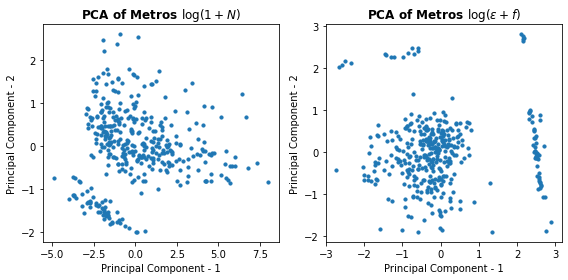

In [17]:
np.set_printoptions(precision=2)

fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(1, 2, 1)
# logtransformed abundances
sum_and_naics_keys = ['summed_emp'] + emp_naics_keys
df_metro=df_msa[df_msa['Metro']==True]
logNemp = np.log10(1.0+df_metro.loc[:, sum_and_naics_keys].values)
df_msa_logN = pd.DataFrame(logNemp, columns=sum_and_naics_keys)
ax1, PCA_object = plot_PCA(
    ax1, df_msa_logN, emp_naics_keys, standardized=True)
ax1.set_title(r'PCA of Metros $\log (1 +N)$', fontweight='bold')
# print('here some naics categories contribute more to PC1 than tothers.')
print('PC1:', PCA_object.components_[0])

ax2 = fig.add_subplot(1, 2, 2)
# logtransformed fractions
df_metro=df_msa[df_msa['Metro']==True]
df_metro_fractions = df_metro.copy()
df_metro_fractions[emp_naics_keys] = df_metro[emp_naics_keys].div(
    1.0*df_metro['summed_emp'], axis=0)
fracs = df_metro_fractions.loc[:, emp_naics_keys].values
pseudo_count = np.min(fracs[fracs > 0]/10)
logfrac = np.log10(pseudo_count+fracs)
df_metro_logF = pd.DataFrame(logfrac, columns=emp_naics_keys)

ax2, PCA_object = plot_PCA(
    ax2, df_metro_logF , emp_naics_keys, standardized=True)
ax2.set_title(r'PCA of Metros $\log (\epsilon +f)$', fontweight='bold')
fig.patch.set_facecolor('white')
plt.tight_layout()

print('PC1:', PCA_object.components_[0])

After multiplicative zero replacement

Explained variation per principal component: [0.75 0.11]
PC1: [0.16 0.25 0.22 0.23 0.19 0.25 0.2  0.24 0.27 0.25 0.24 0.27 0.32 0.24
 0.2  0.25 0.21 0.22]
Explained variation per principal component: [0.47 0.23]
PC1: [ 1.31e-01 -9.85e-01 -7.15e-02 -2.32e-02  2.72e-02 -1.78e-02  3.16e-03
 -2.32e-02 -2.54e-02 -6.75e-03 -2.55e-02 -1.51e-02 -5.31e-02  5.74e-03
  1.10e-03  7.31e-04  6.48e-03 -7.40e-03]


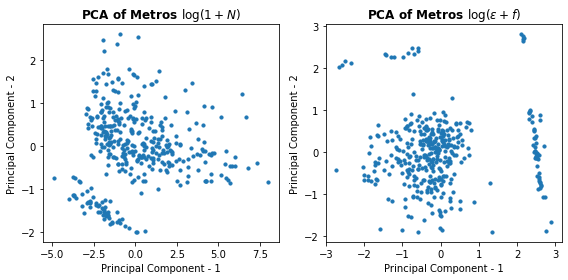

In [18]:
np.set_printoptions(precision=2)

fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(1, 2, 1)
# logtransformed abundances
sum_and_naics_keys = ['summed_emp'] + emp_naics_keys
df_metro=df_msa[df_msa['Metro']==True]
logNemp = np.log10(1.0+df_metro.loc[:, sum_and_naics_keys].values)
df_msa_logN = pd.DataFrame(logNemp, columns=sum_and_naics_keys)
ax1, PCA_object = plot_PCA(
    ax1, df_msa_logN, emp_naics_keys, standardized=True)
ax1.set_title(r'PCA of Metros $\log (1 +N)$', fontweight='bold')
# print('here some naics categories contribute more to PC1 than tothers.')
print('PC1:', PCA_object.components_[0])

ax2 = fig.add_subplot(1, 2, 2)
# logtransformed fractions
df_metro=df_msa[df_msa['Metro']==True]
df_metro_fractions = df_metro.copy()
df_metro_fractions[emp_naics_keys] = df_metro[emp_naics_keys].div(
    1.0*df_metro['summed_emp'], axis=0)
fracs = df_metro_fractions.loc[:, emp_naics_keys].values
pseudo_count = np.min(fracs[fracs > 0]/10)
logfrac = np.log10(pseudo_count+fracs)
df_metro_logF = pd.DataFrame(logfrac, columns=emp_naics_keys)

ax2, PCA_object = plot_PCA(
    ax2, df_metro_logF , emp_naics_keys, standardized=True)
ax2.set_title(r'PCA of Metros $\log (\epsilon +f)$', fontweight='bold')
fig.patch.set_facecolor('white')
plt.tight_layout()

print('PC1:', PCA_object.components_[0])

plotting PCA without standardizing.
Explained variation per principal component: [0.42 0.22]
plotting PCA without standardizing.
Explained variation per principal component: [0.42 0.22]


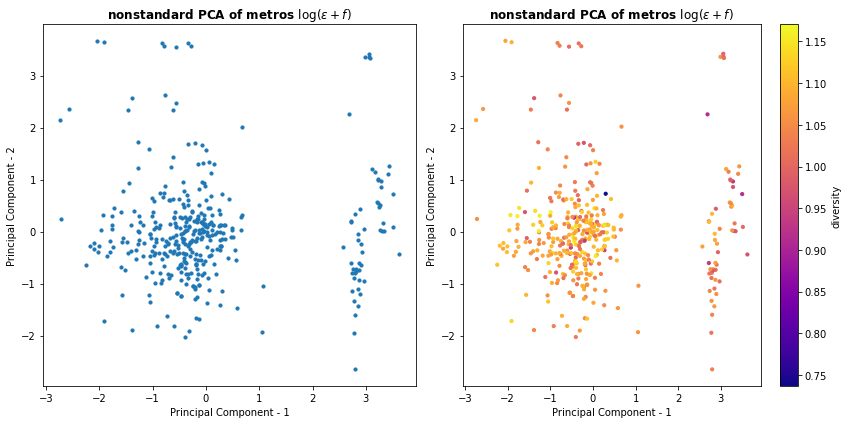

In [18]:
np.set_printoptions(precision=2)

fig = plt.figure(figsize=(12, 6))

ax2 = fig.add_subplot(1, 2, 1)
ax2, PCA_object = plot_PCA(
    ax2, df_metro_logF, emp_naics_keys, plot_nonStandard_PCA=True)
ax2.set_title(r'nonstandard PCA of metros $\log (\epsilon +f)$', fontweight='bold')

Fi=df_metro_fractions[emp_naics_keys].values
log_Fi=df_metro_logF[emp_naics_keys].values
diversity=-np.sum(Fi*log_Fi,axis=1)
color_by={'values':diversity, 'label':'diversity'}
ax1 = fig.add_subplot(1, 2, 2)
ax1, PCA_object = plot_PCA(
    ax1, df_metro_logF, emp_naics_keys, plot_nonStandard_PCA=True, color_by=color_by,fig=fig)
ax1.set_title(r'nonstandard PCA of metros $\log (\epsilon +f)$', fontweight='bold')



fig.patch.set_facecolor('white')
plt.tight_layout()
plt.show()

NMDS and MDS plot of just metros

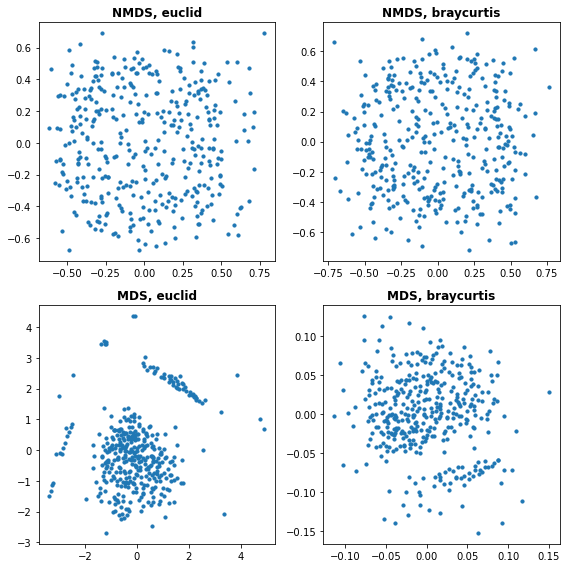

In [11]:
fig2 = plt.figure(figsize=(8, 8))
ax1 = fig2.add_subplot(2, 2, 1)
distances = compute_pairwise_distances(df_metro_logF[emp_naics_keys].values, 'euclidean')
ax1=plot_NMDS(distances, ax1, fs=10, ms=10)
ax1.set_title(r'NMDS, euclid', fontweight='bold')


ax2 = fig2.add_subplot(2, 2, 2)
distances = compute_pairwise_distances(df_metro_logF[emp_naics_keys].values, 'braycurtis')
ax2=plot_NMDS(distances, ax2, fs=10, ms=10)
ax2.set_title(r'NMDS, braycurtis', fontweight='bold')

ax3 = fig2.add_subplot(2, 2, 3)
distances = compute_pairwise_distances(df_metro_logF[emp_naics_keys].values, 'euclidean')
ax3=plot_NMDS(distances, ax3, fs=10, ms=10,mds=True)
ax3.set_title(r'MDS, euclid', fontweight='bold')


ax4 = fig2.add_subplot(2, 2, 4)
distances = compute_pairwise_distances(df_metro_logF[emp_naics_keys].values, 'braycurtis')
ax4=plot_NMDS(distances, ax4, fs=10, ms=10,mds=True)
ax4.set_title(r'MDS, braycurtis', fontweight='bold')

fig2.patch.set_facecolor('white')
plt.tight_layout()
plt.show()

## Explained variance by principal components

### All PCs contribute to explaining variance if data is standardized

for fraction and log $f$ data, all PCs constribute significantly and dimensional reduction is not possible. This seems to imply that PCA cannot be used for dimensional reduction in a meaningful way

Explained variation per principal component: [0.19 0.12 0.08 0.07 0.07 0.05 0.05 0.05 0.04 0.04 0.03 0.03 0.03 0.03
 0.03 0.03 0.03 0.02 0.02 0.01]
cumulative variance explained [0.19 0.3  0.38 0.46 0.52 0.58 0.62 0.67 0.71 0.75 0.78 0.81 0.84 0.87
 0.9  0.92 0.95 0.97 0.99 1.  ]
Explained variation per principal component: [1.46e-01 1.09e-01 8.12e-02 7.24e-02 5.88e-02 5.34e-02 5.04e-02 4.89e-02
 4.56e-02 4.40e-02 4.23e-02 3.83e-02 3.78e-02 3.57e-02 3.50e-02 3.23e-02
 2.75e-02 2.30e-02 1.87e-02 4.90e-33]
cumulative variance explained [0.15 0.25 0.34 0.41 0.47 0.52 0.57 0.62 0.67 0.71 0.75 0.79 0.83 0.86
 0.9  0.93 0.96 0.98 1.   1.  ]


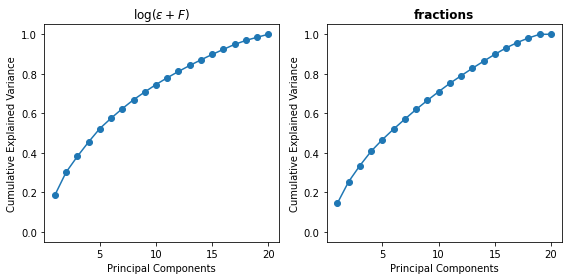

In [61]:
fig2 = plt.figure(figsize=(8, 4))
ax1 = fig2.add_subplot(1, 2, 1)
ax1, PCA_obj1, df_logF_PCA = PCA_explained_variance(
    df_msa_logF, emp_naics_keys, ax=ax1)
ax1.set_title(r'$\log (\epsilon +F)$', fontweight='bold')

ax2 = fig2.add_subplot(1, 2, 2)

ax2, PCA_obj2, df_fractions_PCA = PCA_explained_variance(
    df_msa_fractions, emp_naics_keys, ax=ax2)
ax2.set_title(r'fractions', fontweight='bold')

fig2.patch.set_facecolor('white')
plt.tight_layout()
plt.show()

### PCA of nonstandardized variables can reduce dimensions

if data is not standarized before doing PCA, then data can be reduced to ~6 dimensions as the first 6 components explain majority of the variance

plotting PCA without standardizing.
Explained variation per principal component: [0.33 0.27 0.17 0.12 0.03 0.02 0.01 0.01 0.01 0.01 0.   0.   0.   0.
 0.   0.   0.   0.  ]
cumulative variance explained [0.33 0.6  0.77 0.9  0.93 0.95 0.96 0.97 0.98 0.98 0.99 0.99 0.99 1.
 1.   1.   1.   1.  ]
plotting PCA without standardizing.
Explained variation per principal component: [3.26e-01 2.70e-01 1.68e-01 1.35e-01 3.35e-02 1.83e-02 1.24e-02 6.96e-03
 6.29e-03 6.08e-03 4.73e-03 3.62e-03 3.40e-03 2.71e-03 1.46e-03 1.11e-03
 4.52e-04 1.35e-31]
cumulative variance explained [0.33 0.6  0.76 0.9  0.93 0.95 0.96 0.97 0.98 0.98 0.99 0.99 0.99 1.
 1.   1.   1.   1.  ]
plotting PCA without standardizing.
Explained variation per principal component: [5.29e-01 1.33e-01 8.63e-02 6.41e-02 4.21e-02 2.85e-02 2.64e-02 2.22e-02
 1.62e-02 1.47e-02 1.26e-02 8.87e-03 4.83e-03 3.81e-03 3.52e-03 2.14e-03
 1.81e-03 9.36e-33]
cumulative variance explained [0.53 0.66 0.75 0.81 0.85 0.88 0.91 0.93 0.95 0.96 0.98 0.98 0

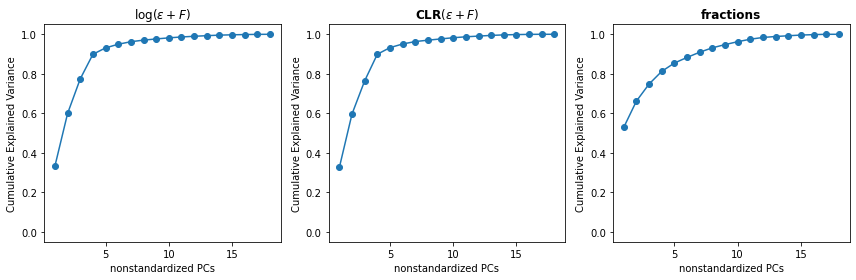

In [14]:
fig2 = plt.figure(figsize=(12, 4))
ax1 = fig2.add_subplot(1, 3, 1)
ax1, PCA_obj1, df_logF_PCA = PCA_explained_variance(
    df_msa_logF, emp_naics_keys, ax=ax1, plot_nonStandard_PCA=True)
ax1.set_title(r'$\log (\epsilon +F)$', fontweight='bold')

ax2 = fig2.add_subplot(1, 3, 2)
ax2, PCA_obj2, df_logF_PCA = PCA_explained_variance(
    df_msa_CLRf, emp_naics_keys, ax=ax2, plot_nonStandard_PCA=True)
ax2.set_title(r'CLR$(\epsilon +F)$', fontweight='bold')

 
ax3 = fig2.add_subplot(1, 3, 3)

ax3, PCA_obj3, df_fractions_PCA = PCA_explained_variance(
    df_msa_fractions, emp_naics_keys, ax=ax3, plot_nonStandard_PCA=True)
ax3.set_title(r'fractions', fontweight='bold')

fig2.patch.set_facecolor('white')
plt.tight_layout()
plt.show()

## Features are not normally distributed, so PCA is inappropriate.

- distribution of N_employees and f_employees in a sector is right skewed
- Log transformed abundances looks more normal, but won't pass a statistical test of normality

**For fraction employed data**

No feature looks Gaussian by Shapiro test.


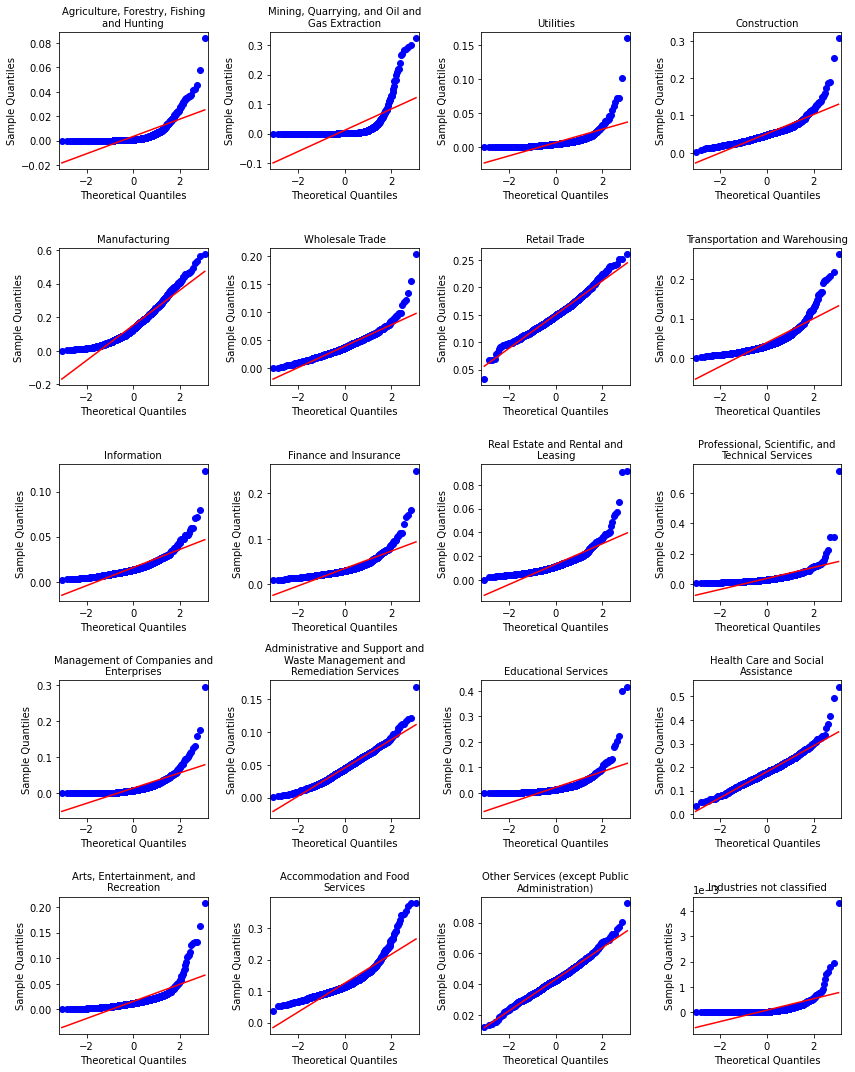

In [82]:
from statsmodels.graphics.gofplots import qqplot
from sklearn.preprocessing import StandardScaler
from scipy.stats import shapiro

# normalize data into fractions
df_msa_fractions = df_msa.copy()
df_msa_fractions[emp_naics_keys] = df_msa[emp_naics_keys].div(1.0*df_msa['summed_emp'], axis=0)

## standardizing the features (to mean 0, var 1) is not required for a QQ plot.
# stdzd_fracs = df_msa_fractions.loc[:, emp_naics_keys].values
# stdzd_fracs = StandardScaler().fit_transform(stdzd_fracs)
# df_stdzd_fracs = pd.DataFrame(stdzd_fracs, columns=emp_naics_keys)

## Shapiro Wilk test
pvalues=[]
for idx, key in enumerate(emp_naics_keys):
    frac_data =df_msa_fractions[key].values
    stat, pval = shapiro(frac_data)
    pvalues.append(pval)
if np.all(np.array(pvalues) < 0.05):
    print('No feature looks Gaussian by Shapiro test.')
else:
    print('some features look gaussian',pvalues)

##QQ plot
fig = plt.figure(figsize=(12,15))
for idx, key in enumerate(emp_naics_keys):
    ax1= fig.add_subplot(5, 4, idx+1)
    frac_data =df_msa_fractions[key].values
    qqplot(frac_data, line='s',ax=ax1)   
    wrapped_title="\n".join(wrap(sector_from_naics(df_naics_ref, key), 30))
    ax1.set_title(wrapped_title,fontsize=fontSizeSmall)
    ax1.ticklabel_format(axis='both', style='sci',scilimits=(-3,3))
fig.patch.set_facecolor('white')
fig.tight_layout()
plt.savefig(plot_path+'QQplot_Frac.png')


**For number of employees data**

No feature looks Gaussian by Shapiro test.


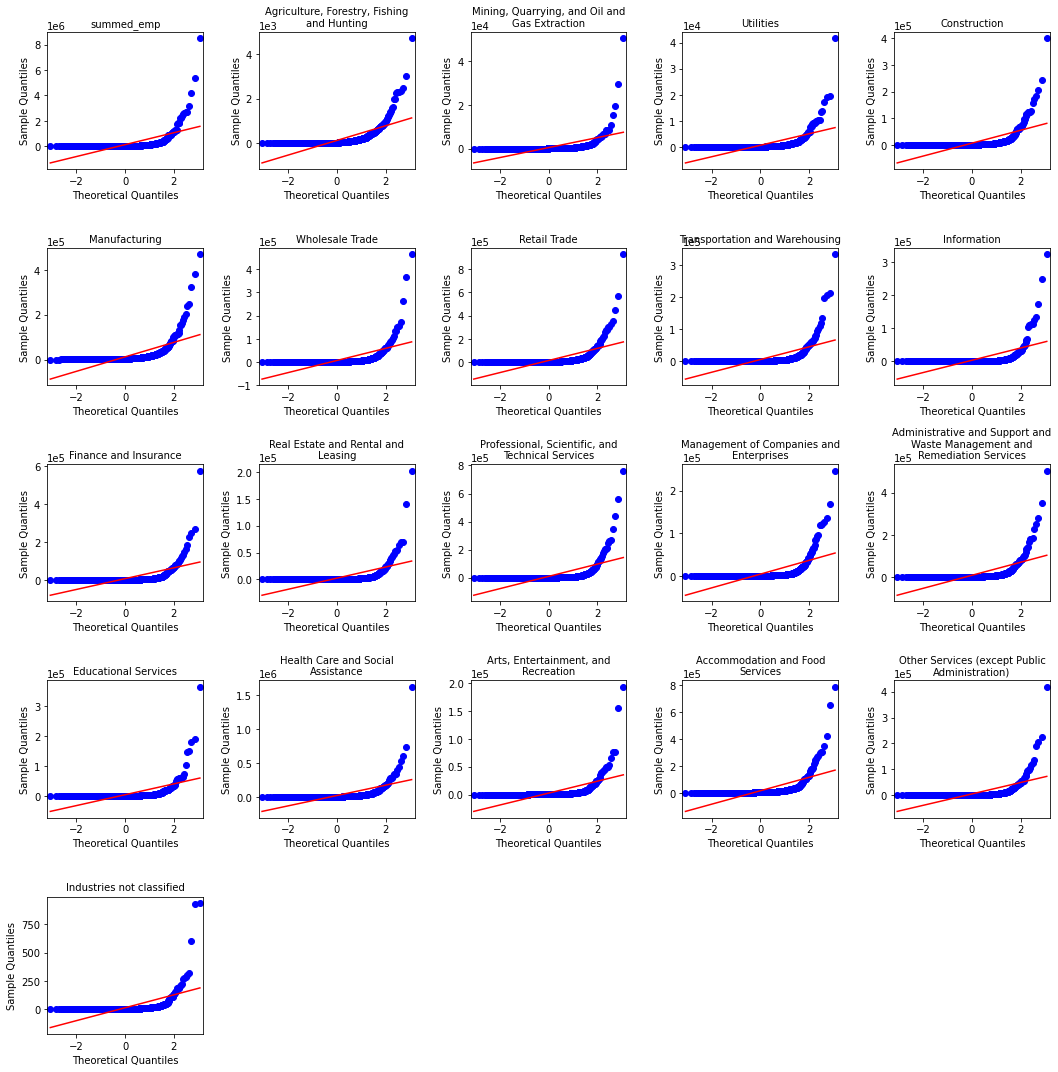

In [81]:
from statsmodels.graphics.gofplots import qqplot
from sklearn.preprocessing import StandardScaler
from scipy.stats import shapiro

sum_and_naics_keys=['summed_emp']+ emp_naics_keys
## standardizing the features to mean 0, var 1
# stdzd_Nemp = df_msa.loc[:, sum_and_naics_keys].values
# stdzd_Nemp = StandardScaler().fit_transform(stdzd_Nemp)
# df_stdzd_Nemp = pd.DataFrame(stdzd_Nemp, columns=sum_and_naics_keys)
df_stdzd_Nemp=df_msa.loc[:, sum_and_naics_keys]

## Shapiro Wilk test
pvalues=[]
for idx, key in enumerate(sum_and_naics_keys):
    data =df_msa[key].values
    stat, pval = shapiro(data)
    pvalues.append(pval)
if np.all(np.array(pvalues) < 0.05):
    print('No feature looks Gaussian by Shapiro test.')
else:
    print('some features look gaussian',pvalues)

fig = plt.figure(figsize=(15,15))
for idx, key in enumerate(sum_and_naics_keys):
    ax1= fig.add_subplot(5, 5, idx+1)
    data =df_msa[key].values
    qqplot(data, line='s',ax=ax1)
    wrapped_title="\n".join(wrap(sector_from_naics(df_naics_ref, key), 30))
    ax1.set_title(wrapped_title,fontsize=fontSizeSmall)    
    ax1.ticklabel_format(axis='both', style='sci',scilimits=(-3,3))
plt.tight_layout()
fig.patch.set_facecolor('white')
plt.savefig(plot_path+'QQplot_Nemp.png')


### log transformed abundances  looks better on qq plot, but doesnt pass test of normality.

- log (1+N) looks more normal on qq plot. 
- Zero corrected data points deviate from normality, but only appear in some sectors 
- log (1+N) doesn't pass shapiro test for normality
- log($\epsilon$+f), doesn't look as normal as log (1+N).

**log(N_employees)**

No feature looks Gaussian by Shapiro test.
pvalues were [2.8187032402751113e-20, 1.8398669464756994e-19, 2.5890503656205445e-25, 2.5570998186853654e-22, 1.1112212529534957e-14, 9.963414271396687e-08, 1.9613552725309888e-14, 2.7954405950046474e-19, 4.721176921629322e-11, 1.674823993249998e-19, 1.1508916413855148e-22, 2.93473728696684e-16, 1.0702401909262219e-18, 2.04370916176237e-20, 1.9191694899944878e-09, 1.5060844281780672e-12, 3.8386212327562767e-16, 1.1610152483854108e-07, 4.4477360916272164e-18, 1.405833672691156e-18, 9.661913368446405e-33]


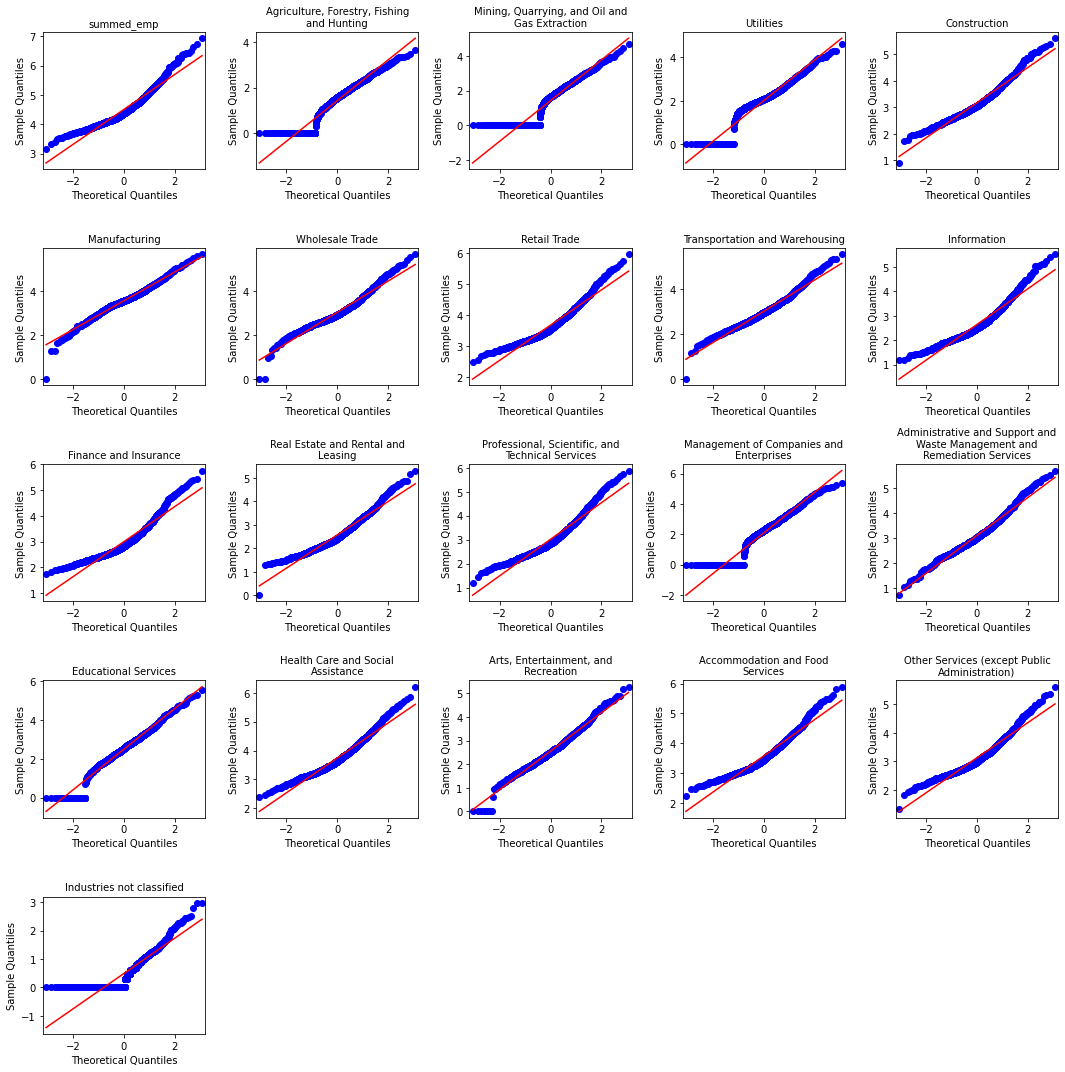

In [27]:
from statsmodels.graphics.gofplots import qqplot
from sklearn.preprocessing import StandardScaler
from scipy.stats import shapiro

sum_and_naics_keys=['summed_emp']+ emp_naics_keys
logNemp = np.log10(1.0+df_msa.loc[:, sum_and_naics_keys].values)
df_msa_logN = pd.DataFrame(logNemp, columns=sum_and_naics_keys)



# standardizing the features to mean 0, var 1
# stdzd_logNemp = np.log10(1.0+df_msa.loc[:, sum_and_naics_keys].values)
# stdzd_logNemp = StandardScaler().fit_transform(stdzd_logNemp)
# df_stdzd_logNemp = pd.DataFrame(stdzd_logNemp, columns=sum_and_naics_keys)


## Shapiro Wilk test
pvalues=[]
for idx, key in enumerate(sum_and_naics_keys):
    frac_data =df_msa_logN[key].values
    stat, pval = shapiro(frac_data)
    pvalues.append(pval)
if np.all(np.array(pvalues) < 0.05):
    print('No feature looks Gaussian by Shapiro test.')
else:
    print('some features look gaussian',pvalues)

fig = plt.figure(figsize=(15,15))
for idx, key in enumerate(sum_and_naics_keys):
    ax1= fig.add_subplot(5, 5, idx+1)
    frac_data =df_msa_logN[key].values
    qqplot(frac_data, line='s',ax=ax1)
    wrapped_title="\n".join(wrap(sector_from_naics(df_naics_ref, key), 30))
    ax1.set_title(wrapped_title,fontsize=fontSizeSmall)
    ax1.ticklabel_format(axis='both', style='sci',scilimits=(-3,3))
plt.tight_layout()
fig.patch.set_facecolor('white')

plt.savefig(plot_path+'QQplot_logN.png')
print ('pvalues were', pvalues)

In [86]:
np.min(df_msa_fractions.loc[:, emp_naics_keys].values[df_msa_fractions.loc[:, emp_naics_keys].values>0])

5.326487022014371e-06

**log(fraction_employed +$\epsilon$)** 

pseudo_counts were [1.81e-06 3.59e-06 3.40e-05 3.39e-04 3.33e-04 1.18e-04 3.25e-03 1.40e-04
 2.16e-04 8.62e-04 2.50e-04 6.20e-04 1.47e-05 8.02e-05 3.53e-05 3.69e-03
 6.37e-05 3.58e-03 1.21e-03 5.33e-07]
No feature looks Gaussian by Shapiro test.


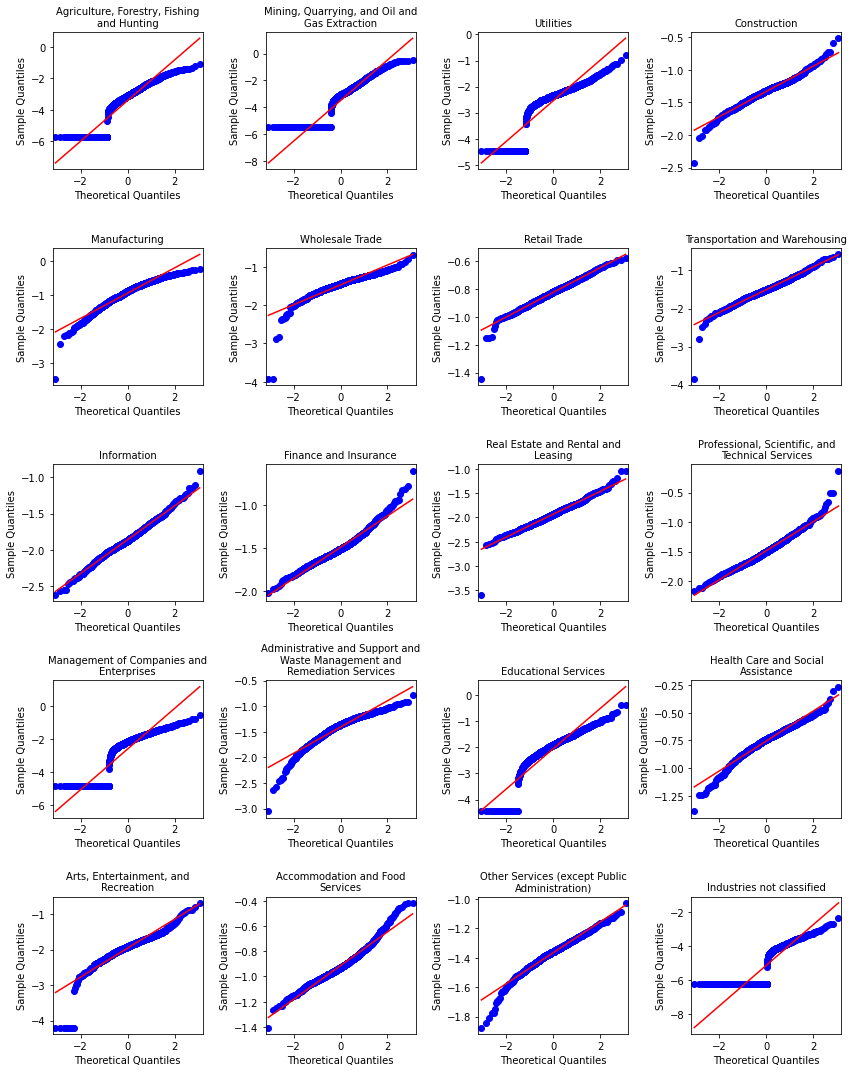

In [92]:
df_msa_fractions = df_msa.copy()
df_msa_fractions[emp_naics_keys] = df_msa[emp_naics_keys].div(1.0*df_msa['summed_emp'], axis=0)

fracs=df_msa_fractions.loc[:, emp_naics_keys].values
## each feature is given its own pseudo count so that we can see the qq plots better
pseudo_count=[]
for idx in range(len(fracs[0])):    
    pseudo_count.append(np.min(fracs[:,idx][fracs[:,idx]>0])/10)
np.set_printoptions(precision=2)
print ('pseudo_counts were', np.array(pseudo_count))
logfrac = np.log10(pseudo_count+fracs)
df_msa_logF = pd.DataFrame(logfrac, columns=emp_naics_keys)

## Shapiro Wilk test
pvalues=[]
for idx, key in enumerate(emp_naics_keys):
    frac_data =df_msa_logF[key].values
    stat, pval = shapiro(frac_data)
    pvalues.append(pval)
if np.all(np.array(pvalues) < 0.05):
    print('No feature looks Gaussian by Shapiro test.')
else:
    print('some features look gaussian',pvalues)


fig = plt.figure(figsize=(12,15))
for idx, key in enumerate(emp_naics_keys):
    ax1= fig.add_subplot(5, 4, idx+1)
    frac_data =df_msa_logF[key].values
    qqplot(frac_data, line='s',ax=ax1)
    wrapped_title="\n".join(wrap(sector_from_naics(df_naics_ref, key), 30))
    ax1.set_title(wrapped_title,fontsize=fontSizeSmall)
    ax1.ticklabel_format(axis='both', style='sci',scilimits=(-3,3))
plt.tight_layout()
fig.patch.set_facecolor('white')
plt.savefig(plot_path+'QQplot_logF.png')

### Box-cox transformation for normality

- Box-cox transform is not the best option since it tries to maximize log likelihood of a linear model (if single argument then model is x~1. 

- Better options are Tukey transform, which maximizes noramlity by using  Shapiro-Wilk tests repeatedly, or the LambertW transform that works well with heavy-tailed distributions. 

-Both Tukey and LambertW are currently only implemented in R, so we do Box-Cox for now.

https://medium.com/analytics-vidhya/a-guide-to-data-transformation-9e5fa9ae1ca3

some features look gaussian ['naics_54' 'naics_56'] [0.71523809 0.0514369 ]


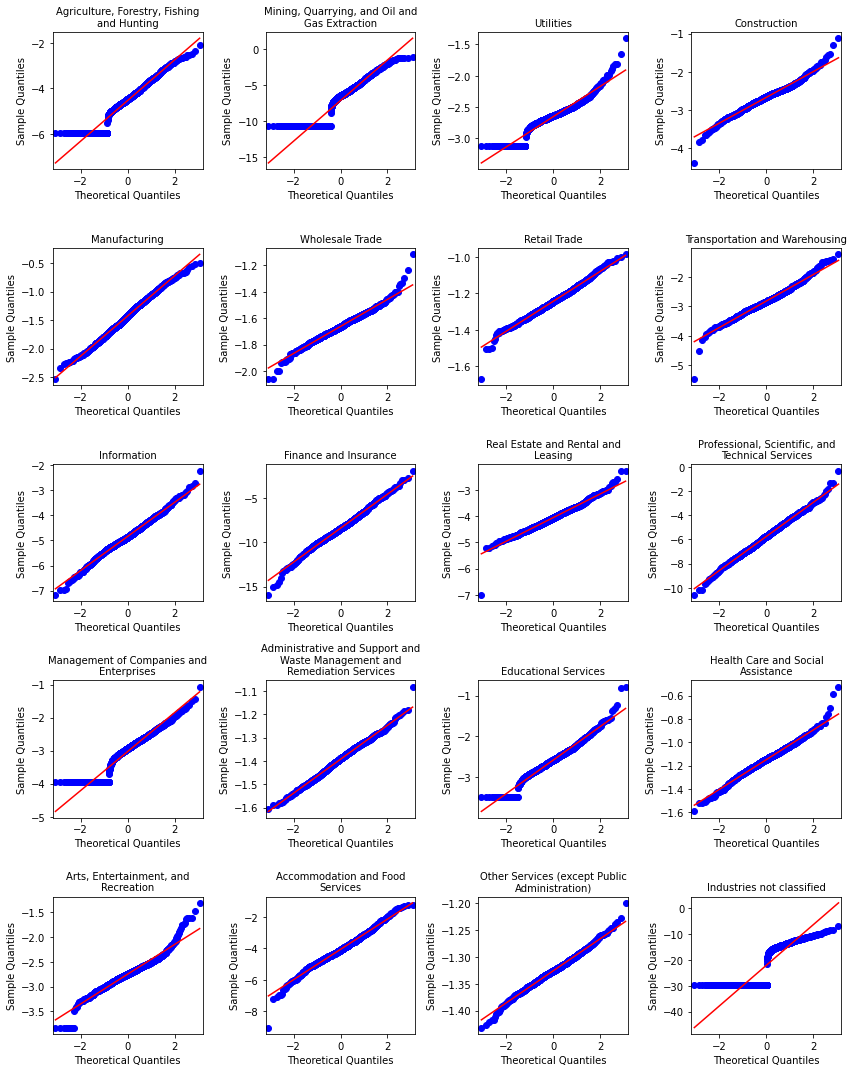

In [25]:
from scipy import stats
from statsmodels.graphics.gofplots import qqplot
from sklearn.preprocessing import StandardScaler
from scipy.stats import shapiro

# normalize data into fractions
df_msa_fractions = df_msa.copy()
df_msa_fractions[emp_naics_keys] = df_msa[emp_naics_keys].div(
    1.0*df_msa['summed_emp'], axis=0)


df_boxCox = {}
df_boxCox_Lambda = {}
# boxcox transformation on fractions
for idx, key in enumerate(emp_naics_keys):
    frac_data = df_msa_fractions[key].values
    pseudo_count = np.min(frac_data[frac_data > 0])/10
    boxcox_fracs, boxcox_lambda = stats.boxcox(frac_data + pseudo_count)
    df_boxCox.update({key: boxcox_fracs})
    df_boxCox_Lambda.update({key: boxcox_lambda})


df_boxCox = pd.DataFrame.from_dict(df_boxCox)
df_boxCox_Lambda = pd.DataFrame(df_boxCox_Lambda, index=[0])

# Shapiro Wilk test
pvalues = []
for idx, key in enumerate(emp_naics_keys):
    frac_data = df_boxCox[key].values
    stat, pval = shapiro(frac_data)
    pvalues.append(pval)
pvalues = np.array(pvalues)
if np.all(pvalues < 0.05):
    print('No feature looks Gaussian by Shapiro test.')
else:
    print('some features look gaussian', np.array(emp_naics_keys)
          [pvalues > 0.05], pvalues[pvalues > 0.05])

# QQ plot
fig = plt.figure(figsize=(12, 15))
for idx, key in enumerate(emp_naics_keys):
    ax1 = fig.add_subplot(5, 4, idx+1)
    frac_data = df_boxCox[key].values
    qqplot(frac_data, line='s', ax=ax1)
    wrapped_title = "\n".join(wrap(sector_from_naics(df_naics_ref, key), 30))
    ax1.set_title(wrapped_title, fontsize=fontSizeSmall)
    ax1.ticklabel_format(axis='both', style='sci', scilimits=(-3, 3))
fig.patch.set_facecolor('white')
plt.tight_layout()
plt.savefig(plot_path+'QQplot_BoxCox_Frac.png')

In [26]:
print ('pvalues were', pvalues)
print('lambdas were')
df_boxCox_Lambda

pvalues were [4.37394372e-18 3.85099091e-26 1.47629186e-19 1.62711995e-08
 2.32919883e-02 5.52140932e-07 1.69254126e-04 3.88370118e-08
 1.27051724e-02 9.58229788e-03 6.02566619e-09 7.15238094e-01
 5.19468819e-21 5.14369048e-02 1.80210638e-11 1.14322356e-05
 1.80847696e-15 1.25008601e-05 5.77657064e-03 6.04590308e-36]
lambdas were


naics_11  naics_21  naics_22  naics_23  naics_31  naics_42  naics_44  \
0  0.142805  0.026135  0.306129   0.09126  0.375344  0.478882  0.475914   

   naics_48  naics_51  naics_52  naics_53  naics_54  naics_55  naics_56  \
0  0.119257 -0.055592 -0.452386    0.0417 -0.272515  0.233778  0.613596   

   naics_61  naics_62  naics_71  naics_72  naics_81  naics_99  
0  0.268307  0.501477  0.234353 -0.553902  0.657709 -0.089727

No feature looks Gaussian by Shapiro test.


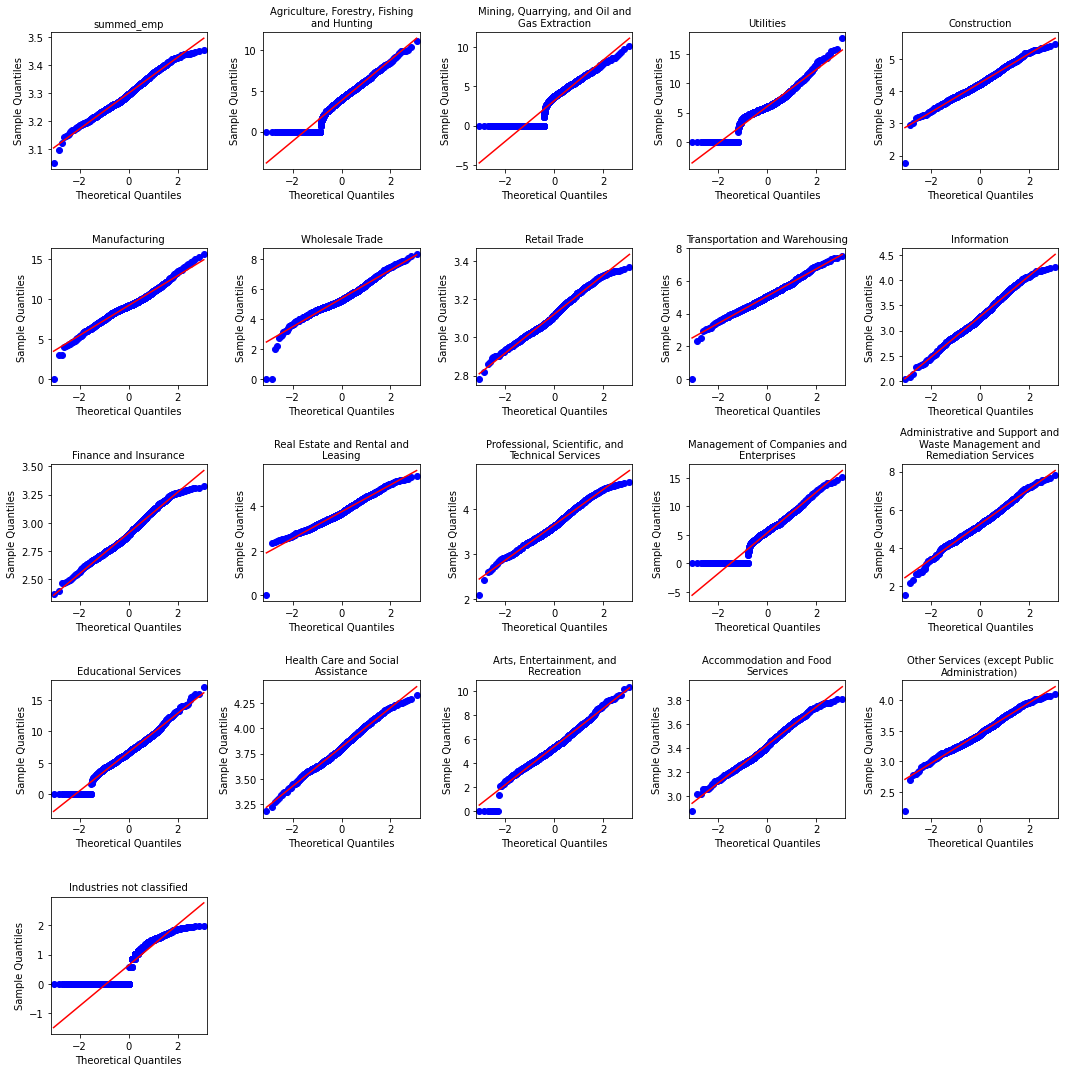

In [43]:
from scipy import stats
from statsmodels.graphics.gofplots import qqplot
from sklearn.preprocessing import StandardScaler
from scipy.stats import shapiro

# normalize data into fractions
df_msa_fractions = df_msa.copy()
df_msa_fractions[emp_naics_keys] = df_msa[emp_naics_keys].div(1.0*df_msa['summed_emp'], axis=0)
sum_and_naics_keys=['summed_emp']+ emp_naics_keys


df_boxCox={}
df_boxCox_Lambda={}
## boxcox transformation on abundances
for idx, key in enumerate(sum_and_naics_keys):
    Nemp_data =df_msa[key].values      
    boxcox_N, boxcox_lambda =stats.boxcox(1.0+Nemp_data) 
    df_boxCox.update({key:boxcox_N})
    df_boxCox_Lambda.update({key:boxcox_lambda})
    

df_boxCox=pd.DataFrame.from_dict(df_boxCox)
df_boxCox_Lambda=pd.DataFrame(df_boxCox_Lambda, index=[0])

## Shapiro Wilk test
pvalues=[]
for idx, key in enumerate(sum_and_naics_keys):
    Nemp_data =df_boxCox[key].values
    stat, pval = shapiro(Nemp_data)
    pvalues.append(pval)
pvalues=np.array(pvalues)
if np.all(pvalues < 0.05):
    print('No feature looks Gaussian by Shapiro test.')
else:
    print('some features look gaussian',np.array(emp_naics_keys)[pvalues>0.05], pvalues[pvalues>0.05])

##QQ plot
fig = plt.figure(figsize=(15,15))
for idx, key in enumerate(sum_and_naics_keys):
    ax1= fig.add_subplot(5, 5, idx+1)
    Nemp_data =df_boxCox[key].values
    qqplot(Nemp_data, line='s',ax=ax1)   
    wrapped_title="\n".join(wrap(sector_from_naics(df_naics_ref, key), 30))
    ax1.set_title(wrapped_title,fontsize=fontSizeSmall)
    ax1.ticklabel_format(axis='both', style='sci',scilimits=(-3,3))
fig.patch.set_facecolor('white')
plt.tight_layout()
plt.savefig(plot_path+'QQplot_BoxCox_Nemp.png')

In [108]:
print('lambdas were')
df_boxCox_Lambda

lambdas were


summed_emp  naics_11  naics_21  naics_22  naics_23  naics_31  naics_42  \
0   -0.286485  0.062086   -0.0112  0.089112 -0.159282  0.026478 -0.075009   

   naics_44  naics_48  naics_51  ...  naics_53  naics_54  naics_55  naics_56  \
0 -0.291375 -0.091033 -0.220108  ... -0.159362 -0.203875  0.030968 -0.087427   

   naics_61  naics_62  naics_71  naics_72  naics_81  naics_99  
0  0.043048 -0.221623 -0.026666 -0.253805 -0.231896 -0.483723  

[1 rows x 21 columns]

## tSNE

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 933 samples in 0.001s...
[t-SNE] Computed neighbors for 933 samples in 0.058s...
[t-SNE] Computed conditional probabilities for sample 933 / 933
[t-SNE] Mean sigma: 0.867579
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.789074
[t-SNE] KL divergence after 300 iterations: 0.849639


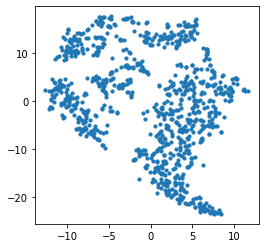

In [18]:
from sklearn.manifold import TSNE


sum_and_naics_keys = ['summed_emp'] + emp_naics_keys
logNemp = np.log10(1.0+df_msa.loc[:, sum_and_naics_keys].values)
df_msa_logN = pd.DataFrame(logNemp, columns=sum_and_naics_keys)
df_msa_logN['Metro']= df_msa['Metro']
df_msa_logN.loc[df_msa_logN['Metro'] == True, 'Metro'] = 'Metro'
df_msa_logN.loc[df_msa_logN['Metro'] == False, 'Metro'] = 'Micro'

data_subset=df_msa_logN[emp_naics_keys].values
# tsne_obj = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, init='pca')
tsne_obj = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, init='random')
tsne_results = tsne_obj.fit_transform(data_subset)


fig = plt.figure(figsize=(4, 4))
fs = 14
# plt.xlabel('Principal Component - 1', fontsize=fs)
# plt.ylabel('Principal Component - 2', fontsize=fs)
plt.scatter(tsne_results[:,0], tsne_results[:,1],  s=10)
fig.patch.set_facecolor('white')

## distribution of pairwise distances
to check how relevant the curse of dimensionality is

In [26]:
def plot_pairwise_distances(X, metrics_list):
    '''
    plots histogram of pairwise distances for 4 metrics to get a sense of curse of dimensionality
    '''
    fig = plt.figure(figsize=(8, 8))
    fs = 12
    for metric_idx, distance_metric in enumerate(metrics_list):
        if metric_idx > 3:
            break
        ax = fig.add_subplot(2, 2, metric_idx+1)
        pwise_distances = compute_pairwise_distances(X, distance_metric)
        CV = np.std(pwise_distances)/np.mean(pwise_distances)

        ax.hist(np.ravel(pwise_distances))
        ax.set_title(distance_metric+', CV=' +
                     '{:0.2e}'.format(CV), fontsize=fs, fontweight='bold')
        ax.set_xlabel('distance', fontsize=fs, fontweight='bold')
        plt.tight_layout()
        fig.patch.set_facecolor('white')

    fig2 = plt.figure(figsize=(8, 8))
    fs = 12
    for metric_idx, distance_metric in enumerate(metrics_list):
        if metric_idx > 3:
            break
        ax = fig2.add_subplot(2, 2, metric_idx+1)
        pwise_distances = compute_pairwise_distances(X, distance_metric)
        

        Dmax = np.max(pwise_distances, axis=1)
        maxval = np.max(Dmax)
        eps=np.min(pwise_distances)/100.
        ##add values to diagonal to make sure you don't look at diagonal for min dis
        Dmin = np.min(pwise_distances+np.diag(maxval *
                                              np.ones(len(pwise_distances)))+eps,axis=1)
        
        scaled_distances=(Dmax-Dmin)/Dmin
        CV = np.std(scaled_distances)/np.mean(scaled_distances)
        ax.hist( scaled_distances)
        ax.set_title(distance_metric+', CV=' +
                     '{:0.2e}'.format(CV), fontsize=fs, fontweight='bold')
        ax.set_xlabel(
            r'scaled distance, $D_{\mathsf{max}}-D_{\mathsf{min}}/D_{\mathsf{min}}$', fontsize=fs, fontweight='bold')
        plt.tight_layout()
        fig2.patch.set_facecolor('white')

    return fig,fig2

#     ax2 = fig.add_subplot(1,2, 2)

#     ax2.legend(loc='best')
#     ax2.set_title('Prediction Strength', fontsize=fs, fontweight='bold')
#     ax2.set_xlabel('Number of clusters', fontsize=fs, fontweight='bold')
#     ax2.set_ylabel('Prediction Strength', fontsize=fs, fontweight='bold')

**distances for logF**

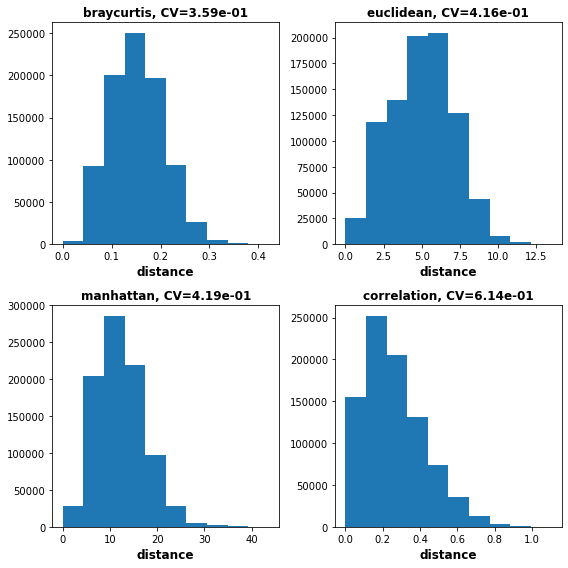

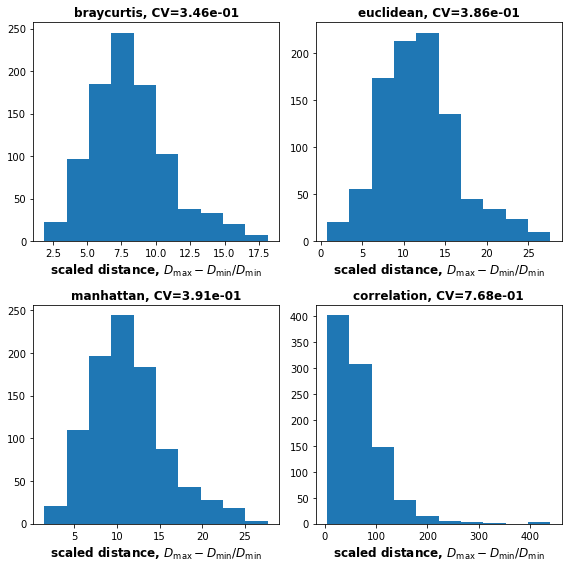

In [27]:
fig1,fig2 = plot_pairwise_distances(df_msa_logF[emp_naics_keys], [
                               'braycurtis', 'euclidean', 'manhattan', 'correlation'])

**distances for Fractions**

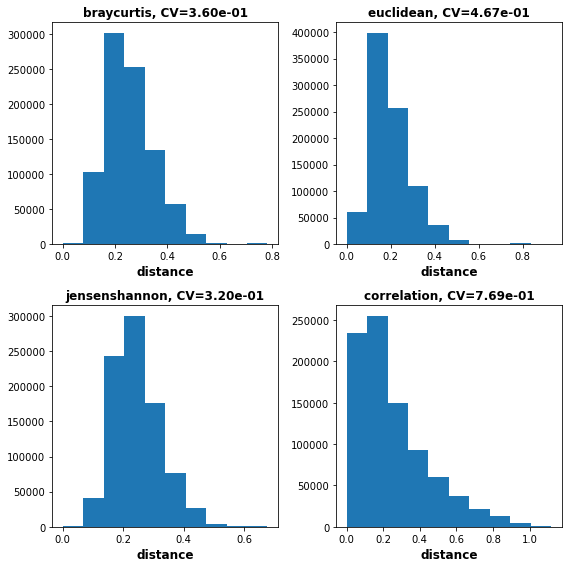

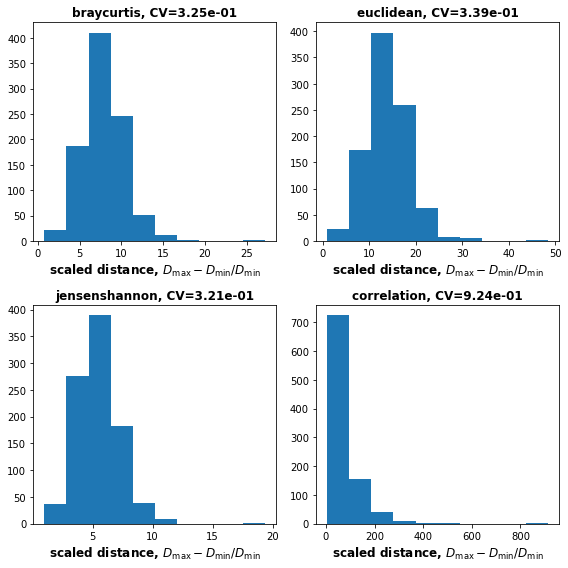

In [28]:
fig1,fig2 = plot_pairwise_distances(df_msa_fractions[emp_naics_keys], [
                               'braycurtis', 'euclidean', 'jensenshannon', 'correlation'])

# Clustering

We need to try a few different clustering methods, distance metrics, etc.

**replicating clustering in microbiome analysis**

Microbiome analysis looks at relative abundance (fractions). We follow [Koren, et al PloS_Comp_Bio 2013] and [Garcia-Jimenez, et al PeerJ 2019]. Distance between cities is computed via a few distance metrics:
    - Jensen Shannon Divergence (only for fracs that sum to 1)
    - Euclidean
    - Bray-Curtis
    - manhattan

Clustering is done via k-mediods/Partitioning Around Mediods(PAM), and potentially Hclust and HDBSCAN

Clustering is evaluated by Silhouette score and Prediction Strength. 

Although usually applied to relative abundance, many of these analyses could be applied to absolute abundance as well.

**clustering after dimensional reduction**

Clustering can be performed after dimensional reduction using PCA, UMAP.

Here the challenges are:
1. City size explains majority of the variance in absolute abundance data. 
2.




### calculate prediction strength
Prediction score looks at if members of the same cluster in the test data (after applying clusttering on test) are closest to the same training cluster centroid/medoid. The fraction of correct assignments gives you the prediction strength.

definition of prediction strength is:

\begin{equation}
\operatorname{ps}(k)=\min _{1 \leq j \leq k} \frac{1}{n_{k j}\left(n_{k j}-1\right)} \sum_{i \neq i^{\prime} \in A_{k j}} D\left[C\left(X_{\mathrm{tr}}, k\right), X_{\mathrm{te}}\right]_{i i^{\prime}}
\end{equation}


The implementation here is a much improved and faster version of https://bit.ly/39dXy2C

In [13]:
from sklearn.model_selection import train_test_split
from scipy.spatial import distance as scipy_spatial_distance
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS

def get_closest_centroid_ids(obs, centroids, distance_metric, k):
    '''
    Function for retrieving the closest centroid to the given observation
    in terms of the Euclidean distance.
    '''    
    if k > 1:
        if distance_metric is 'jensenshannon':              
            Distances = scipy_spatial_distance.cdist(obs, centroids, distance_metric)
        else:
            Distances = pairwise_distances(obs, centroids, metric=distance_metric)
        return np.argmin(Distances, axis=1)  
    else:
        return np.zeros(len(obs))


def get_prediction_strength(k, train_medoids, x_test, test_labels, 
                            distance_metric="euclidean", test_medoids=None):
    debugging=False
    
    '''
    Function for calculating the prediction strength of clustering

    Parameters
    ----------
    k : int
        The number of clusters
    train_medoids : array
        indices of medoids from the clustering on the training set
    x_test : array
        Test set observations
    test_labels : array
        Labels predicted for the test set
    distance_metric: string
        name of distance metric used

    Returns
    -------
    prediction_strength : float
        Calculated prediction strength
    '''
    # find the cluster labels (centroids in training set) that test would be assigned to.
    labels_of_test_in_train = get_closest_centroid_ids(
        x_test, train_medoids, distance_metric, k)

    # calculate the prediction strengths for each cluster
    ss = []
    for j in range(k):
        n_examples_j = np.count_nonzero(test_labels == j)
        labels_of_cluster_j_in_train = labels_of_test_in_train[test_labels == j]
        # compare using numpy broadcasting, without diagonal.....stack#39479578
        mask = labels_of_cluster_j_in_train[:,
                                            None] == labels_of_cluster_j_in_train
        mask[np.eye(n_examples_j, dtype=bool)] = 0
        n_same_cluster = np.count_nonzero(mask)
        ss.append(n_same_cluster*1.0 / (n_examples_j * (n_examples_j - 1)))

    prediction_strength = min(ss)
    
    if debugging:
        ss_string=''
        for i in ss:
            ss_string=ss_string+"{:.2f}".format(i)+', '
        df_test=pd.DataFrame(x_test,columns=emp_naics_keys)
        df_test['test_labels']=test_labels
        df_test['test_label_with_train_centroid']=labels_of_test_in_train
        
        ##NMDS plot
        fig2 = plt.figure(figsize=(8, 4))
        ax1 = fig2.add_subplot(1, 2, 1)   
        distances = compute_pairwise_distances(df_test[emp_naics_keys].values, distance_metric)
        NMDS_obj = MDS(n_components=2, dissimilarity='precomputed', n_init=8, max_iter=600,
                  n_jobs=4)
        NMDS_coords=NMDS_obj.fit_transform(distances)
        cluster_labels=df_test['test_labels']
        color_list = create_color_list(scheme_name='sns_tab10')
        i=0
        for group in list(set(cluster_labels)):
            idx_group=np.where(cluster_labels==group)[0]
#             print('len(idx_group)',len(idx_group))
            ax1.scatter(NMDS_coords[idx_group, 0], NMDS_coords[idx_group, 1],c=np.array(color_list[i])[np.newaxis,:], 
                       s=10, label=group)
            i+=1
        ax1.legend(loc='best')
#         ax1=plot_NMDS(distances, ax1, fs=10, ms=10,labels=df_test['test_labels'],mds=True)
        ax1.set_xlabel('MDS1')
        ax1.set_ylabel('MDS2')
        ax1.set_title(r'test labels, ps='+ss_string, fontweight='bold')
        ax2 = fig2.add_subplot(1, 2, 2)
        cluster_labels=df_test['test_label_with_train_centroid']
        i=0
        for group in list(set(cluster_labels)):
            idx_group=np.where(cluster_labels==group)[0]
            ax2.scatter(NMDS_coords[idx_group, 0], NMDS_coords[idx_group, 1],c=np.array(color_list[i])[np.newaxis,:], 
                       s=10, label=group)
            i+=1
        ax2.legend(loc='best')

        ax2.set_xlabel('MDS1')
        ax2.set_ylabel('MDS2')
        ax2.set_title(r'labelled by train centroid', fontweight='bold')        
        fig2.patch.set_facecolor('white')
        plt.tight_layout()
        plt.show()
        
        
        ##PCA plot
        fig2 = plt.figure(figsize=(8, 4))
        ax1 = fig2.add_subplot(1, 2, 1)
        ax1, PCA_object = plot_PCA(
            ax1, df_test, emp_naics_keys, standardized=True, label_key='test_labels')
        
        ax1.set_title(r'test labels, ps='+ss_string, fontweight='bold')
        ax2 = fig2.add_subplot(1, 2, 2)
        ax2, PCA_object = plot_PCA(
            ax2, df_test, emp_naics_keys, standardized=True, label_key='test_label_with_train_centroid')
        
        projected_medoids=PCA_object.transform(train_medoids)
        x_medoids=projected_medoids[:,0]
        y_medoids=projected_medoids[:,0]
        ax2.plot (x_medoids, y_medoids, 'r*', markersize=15)
        print ('medoids shape', np.shape(train_medoids), PCA_object.transform(train_medoids))
        ax2.set_title(r'labelled by train centroid', fontweight='bold')        
        fig2.patch.set_facecolor('white')
        plt.tight_layout()
        plt.show()
        
        
    
        
        pwise_dist_all = pairwise_distances(df_test[emp_naics_keys], 
                                             df_test[emp_naics_keys], metric=distance_metric)
        pwise_dist_within_cluster=[]
        pwise_dist_with_testMedoids=[]
        pwise_dist_with_trainMedoids=[]
        for clust in range(k):
            temp_data=df_test[df_test['test_labels']==clust][emp_naics_keys]

            temp_dist = pairwise_distances(temp_data, 
                                             temp_data, metric=distance_metric)
            pwise_dist_within_cluster.extend(temp_dist.flatten())
        
        pwise_dist_all=np.ravel(pwise_dist_all)
        pwise_dist_within_cluster=np.ravel(pwise_dist_within_cluster)
        temp_dist=pairwise_distances(df_test[emp_naics_keys], train_medoids, metric=distance_metric)
        pwise_dist_with_trainMedoids=np.ravel(np.min(temp_dist, axis=1) )

        temp_dist=pairwise_distances(df_test[emp_naics_keys], test_medoids, metric=distance_metric)
        pwise_dist_with_testMedoids=np.ravel(np.min(temp_dist, axis=1) )
        
        color_list = create_color_list(scheme_name='sns_tab10')
        fig = plt.figure(figsize=(8, 4))
#         ax1 = fig.add_subplot(1, 3, 1)
#         ax1.hist(pwise_dist_all,weights=np.ones_like(pwise_dist_all)/len(pwise_dist_all),
#                  color=color_list[0])
#         ax1.set_title(r'distance b/w all points', fontweight='bold')
        ax2 = fig.add_subplot(1, 2, 1)
        ax2.hist([pwise_dist_within_cluster, pwise_dist_all],
                 weights=[np.ones_like(pwise_dist_within_cluster)/len(pwise_dist_within_cluster),np.ones_like(pwise_dist_all)/len(pwise_dist_all)],
                 label=['within cluster', 'all'])
        ax2.set_title(r'ditance b/w pts in a cluster', fontweight='bold')
        ax2.legend(loc='best')
        
        ax3 = fig.add_subplot(1, 2, 2)
#         ax3.hist(np.ravel(pwise_dist_with_trainMedoids),color=color_list[2],label='with train',alpha=0.3) 
#         ax3.hist(np.ravel(pwise_dist_with_testMedoids),color=color_list[3],label='with test',alpha=0.3)       
        ax3.hist([pwise_dist_with_trainMedoids,pwise_dist_with_testMedoids],
                 weights=[np.ones_like(pwise_dist_with_trainMedoids)/len(pwise_dist_with_trainMedoids),np.ones_like(pwise_dist_with_testMedoids)/len(pwise_dist_with_testMedoids)],
                 label=['with train','with test']) 
        ax3.set_title(r'ditance b/w pts and closest medoids', fontweight='bold')
        ax3.legend(loc='best')
        fig.patch.set_facecolor('white')
        plt.tight_layout()
        plt.show()
        
    
    return prediction_strength

#### testing of prediction strength in synthetic data
the tests agreed with results in blog

It took 0.27231574058532715 secs


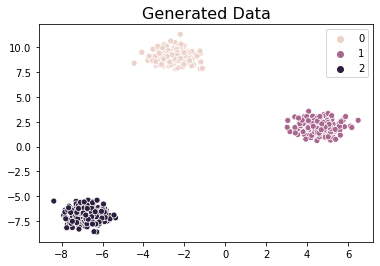

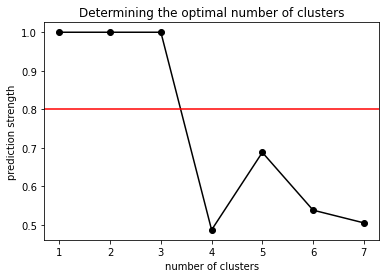

In [8]:

import time
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

# from scipy.spatial import distance

X, y = make_blobs(n_samples=600, centers=3, cluster_std=0.6, random_state=42)
ax = sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y)
ax.set_title('Generated Data', fontsize=16)

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, stratify=y, random_state=42)

start = time.time()
strengths = []
clusters = range(1, 8)
for k in clusters:
    model_train = KMeans(n_clusters=k, random_state=42).fit(X_train)
    model_test = KMeans(n_clusters=k, random_state=42).fit(X_test)
    pred_str = get_prediction_strength(
        k, model_train.cluster_centers_, X_test, model_test.labels_, distance_metric="euclidean")
    strengths.append(pred_str)
stop=time.time()
print ('It took',stop-start,'secs')
# plotting
fig, ax = plt.subplots()
ax.plot(clusters, strengths, '-o', color='black')
ax.axhline(y=0.8, c='red')
ax.set(title='Determining the optimal number of clusters',
       xlabel='number of clusters',
       ylabel='prediction strength')

fig.patch.set_facecolor('white')

with debugging flag

ValueError: Shape of passed values is (120, 2), indices imply (120, 18)

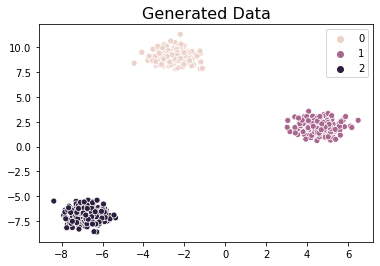

In [12]:

import time
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

# from scipy.spatial import distance

X, y = make_blobs(n_samples=600, centers=3, cluster_std=0.6, random_state=42)
ax = sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y)
ax.set_title('Generated Data', fontsize=16)

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, stratify=y, random_state=42)

start = time.time()
strengths = []
clusters = range(1, 8)
for k in clusters:
    model_train = KMeans(n_clusters=k, random_state=42).fit(X_train)
    model_test = KMeans(n_clusters=k, random_state=42).fit(X_test)
    pred_str = get_prediction_strength(
        k, model_train.cluster_centers_, X_test, model_test.labels_, distance_metric="euclidean", debugging=True)
    strengths.append(pred_str)
stop=time.time()
print ('It took',stop-start,'secs')
# plotting
fig, ax = plt.subplots()
ax.plot(clusters, strengths, '-o', color='black')
ax.axhline(y=0.8, c='red')
ax.set(title='Determining the optimal number of clusters',
       xlabel='number of clusters',
       ylabel='prediction strength')

fig.patch.set_facecolor('white')

## k-medoids and k-means 



In [14]:
#
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans




def do_kmedoids(df_km, k_list=range(1, 15), metrics_list=["euclidean"], test_split=0.5, ps_avgs=12, show_fig=True, standardize=False):
    '''
    performs k medoid clustering
    '''
    stdzd_vals = df_km.values
    if standardize:
        print('Standardizing before clustering.')
        stdzd_vals = StandardScaler().fit_transform(stdzd_vals)
    df_temp=pd.DataFrame(stdzd_vals, columns=df_km.columns, index=df_km.index)
    df_km=df_temp.copy()
    sse = []
    silhouette_list = []
    pred_strengths = []
    for metric_idx, distance_metric in enumerate(metrics_list):
        sse.append([])
        silhouette_list.append([])
        pred_strengths.append([])
        Distances = compute_pairwise_distances(df_km.values, distance_metric)

        for k in k_list:
            km = KMedoids(metric="precomputed", n_clusters=k)
            km.fit(Distances)
            sse[metric_idx].append([k, km.inertia_])

            if k >= 2:
                si_score = silhouette_score(
                    Distances, km.labels_, metric="precomputed")
                silhouette_list[metric_idx].append([k, si_score])

                # calculate prediction strength
                p_strengths = np.empty(0)
                for i in range(ps_avgs):
                    X_train, X_test = train_test_split(
                        df_km.values, test_size=test_split, stratify=km.labels_)
                    train_distances = compute_pairwise_distances(
                        X_train, distance_metric)
                    test_distances = compute_pairwise_distances(
                        X_test, distance_metric)
                    model_train = KMedoids(metric="precomputed",
                                           n_clusters=k).fit(train_distances)
                    model_test = KMedoids(metric="precomputed",
                                          n_clusters=k).fit(test_distances)
                    clusterCenters = X_train[model_train.medoid_indices_]
                    clusterCenters_test = X_test[model_test.medoid_indices_]
                    p_strength = get_prediction_strength(
                        k, clusterCenters, X_test, model_test.labels_, distance_metric=distance_metric, 
                         test_medoids=clusterCenters_test   )
                    p_strengths = np.append(p_strengths, p_strength)
                    p_strengths = np.append(p_strengths, 0.)
                pred_strengths[metric_idx].append(
                    [k, np.mean(p_strengths), np.std(p_strengths)/np.sqrt(ps_avgs)])
    if show_fig:
        color_list = create_color_list(scheme_name='sns_tab10')
        fig = plt.figure(figsize=(6, 12))
        fs = 12
        ax1 = fig.add_subplot(3, 1, 1)
        for metric_idx, distance_metric in enumerate(metrics_list):
            ax1.plot(pd.DataFrame(silhouette_list[metric_idx])[
                     0], pd.DataFrame(silhouette_list[metric_idx])[1], marker='o', color=color_list[metric_idx], label=distance_metric)
        ax1.plot(ax1.get_xlim(), [.25, 0.25], 'k--')
        ax1.legend(loc='best')
        ax1.set_title('Silhouette score', fontsize=fs, fontweight='bold')
        ax1.set_xlabel('Number of clusters', fontsize=fs, fontweight='bold')
        ax1.set_ylabel('Silhouette score', fontsize=fs, fontweight='bold')

        ax2 = fig.add_subplot(3, 1, 2)
        for metric_idx, distance_metric in enumerate(metrics_list):
            ax2.errorbar(pd.DataFrame(pred_strengths[metric_idx])[
                0], pd.DataFrame(pred_strengths[metric_idx])[1], yerr=pd.DataFrame(pred_strengths[metric_idx])[2], color=color_list[metric_idx], label=distance_metric)
        ax2.plot(ax2.get_xlim(), [.8, 0.8], 'k--')
        ax2.legend(loc='best')
        ax2.set_title('Prediction Strength', fontsize=fs, fontweight='bold')
        ax2.set_xlabel('Number of clusters', fontsize=fs, fontweight='bold')
        ax2.set_ylabel('Prediction Strength', fontsize=fs, fontweight='bold')

        ax3 = fig.add_subplot(3, 1, 3)
        for metric_idx, distance_metric in enumerate(metrics_list):
            sse_values = pd.DataFrame(sse[metric_idx])[1]
            scaled_sse = sse_values/np.max(sse_values)
            ax3.plot(pd.DataFrame(sse[metric_idx])[
                     0], scaled_sse, color=color_list[metric_idx], marker='o', label=distance_metric)
        ax3.legend(loc='best')
        ax3.set_title('Elbow Method', fontsize=fs, fontweight='bold')
        ax3.set_xlabel('Number of clusters', fontsize=fs, fontweight='bold')
        ax3.set_ylabel('Scaled SSE/Inertia', fontsize=fs, fontweight='bold')
        plt.tight_layout()
        fig.patch.set_facecolor('white')

    if len(k_list) == 1 and len(metrics_list) == 1:  # return fit object and si score              
        return km, np.ravel(silhouette_list), np.ravel(pred_strengths)
    else:
        if show_fig:
            return sse, silhouette_list, pred_strengths, fig
        else:
            return sse, silhouette_list, pred_strengths, None

    


def do_kmeans(df_km, k_list=range(1, 15), ps_avgs=6,test_split=0.5, show_fig=True):
    '''
    performs k means clustering
    '''
    sse = []
    silhouette_list = []
    pred_strengths=[]
    for k in k_list:
        km = KMeans(n_clusters=k)
        km.fit(df_km.values)
        sse.append([k, km.inertia_])

        if k >= 2:
            si_score = silhouette_score(df_km, km.labels_, metric='euclidean')
            silhouette_list.append([k, si_score])
            # calculate prediction strength
            p_strengths=np.empty(0)
            for i in range(ps_avgs):
                X_train, X_test = train_test_split(
                    df_km.values, test_size=test_split, stratify=km.labels_)
                model_train =KMeans(n_clusters=k).fit(X_train)
                model_test = KMeans(n_clusters=k).fit(X_test)
                clusterCenters = model_train.cluster_centers_
                p_strength = get_prediction_strength(
                    k, clusterCenters, X_test, model_test.labels_, distance_metric='euclidean')
                p_strengths=np.append(p_strengths,p_strength)
            pred_strengths.append([k, np.mean(p_strengths), np.std(p_strengths)/np.sqrt(ps_avgs)])

    if show_fig:
        fig = plt.figure(figsize=(6, 12))
        fs = 12
        ax1 = fig.add_subplot(3, 1, 1)
        ax1.plot(pd.DataFrame(silhouette_list)[
                 0], pd.DataFrame(silhouette_list)[1], marker='o')
        ax1.plot(ax1.get_xlim(), [.25, 0.25], 'k--')
        ax1.set_title('Silhouette score', fontsize=fs, fontweight='bold')
        ax1.set_xlabel('Number of clusters', fontsize=fs, fontweight='bold')
        ax1.set_ylabel('Silhouette score', fontsize=fs, fontweight='bold')

        ax2 = fig.add_subplot(3, 1, 2)
        ax2.errorbar(pd.DataFrame(pred_strengths)[
                 0], pd.DataFrame(pred_strengths)[1],yerr=pd.DataFrame(pred_strengths)[2])
        ax2.plot(ax2.get_xlim(), [.8, 0.8], 'k--')
        ax2.set_title('Prediction Strength', fontsize=fs, fontweight='bold')
        ax2.set_xlabel('Number of clusters', fontsize=fs, fontweight='bold')
        ax2.set_ylabel('Prediction Strength', fontsize=fs, fontweight='bold')

        ax3 = fig.add_subplot(3, 1, 3)
        ax3.plot(pd.DataFrame(sse)[0], pd.DataFrame(sse)[1], marker='o')
        ax3.set_title('Elbow Method, (SSE)', fontsize=fs, fontweight='bold')
        ax3.set_xlabel('Number of clusters', fontsize=fs, fontweight='bold')
        ax3.set_ylabel('Inertia', fontsize=fs, fontweight='bold')
        plt.tight_layout()
        fig.patch.set_facecolor('white')
    if len(k_list) == 1:  # return fit object and si score        
        return km, np.ravel(silhouette_list), np.ravel(pred_strengths)
    else:
        if show_fig:
            return sse, silhouette_list, pred_strengths, fig
        else:
            return sse, silhouette_list, pred_strengths, None

### k_medoids without dimensionality reduction finds few weak clusters

#### testing prediction strength 

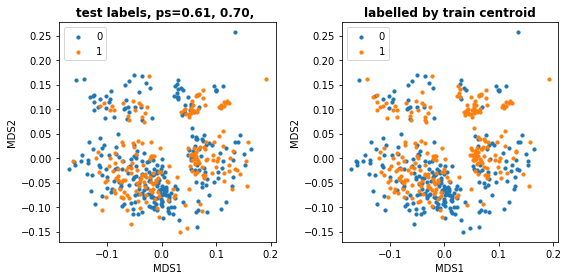

Explained variation per principal component: [0.34456253 0.26579291]
Explained variation per principal component: [0.34456253 0.26579291]
medoids shape (2, 18) [[-0.96073335 -0.48319414]
 [-0.72634999 -0.42596488]]


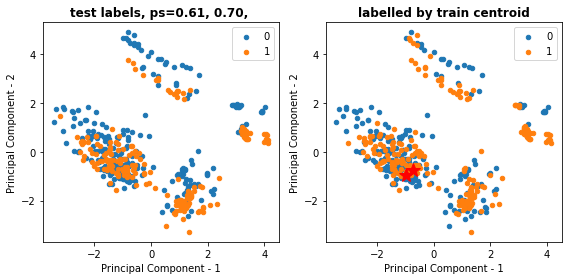

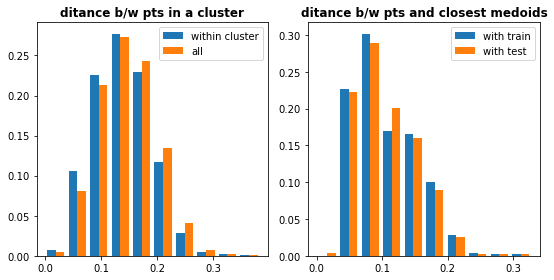

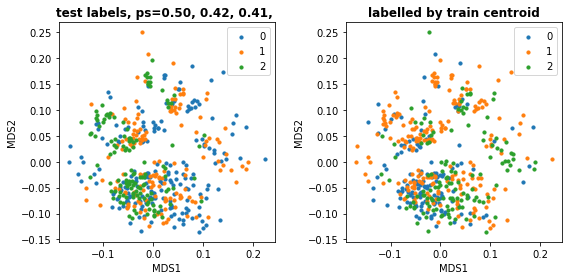

Explained variation per principal component: [0.35977507 0.24333889]
Explained variation per principal component: [0.35977507 0.24333889]
medoids shape (3, 18) [[-0.95593561 -0.41905472]
 [-0.88967834 -0.44743005]
 [-0.8860025  -0.12080235]]


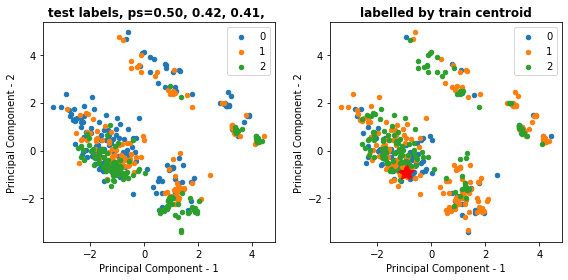

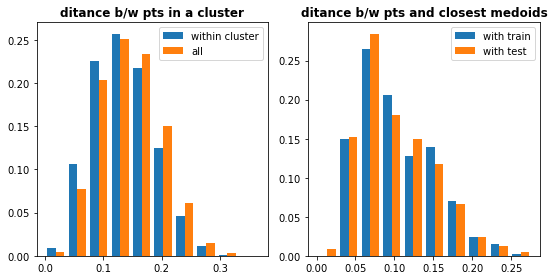

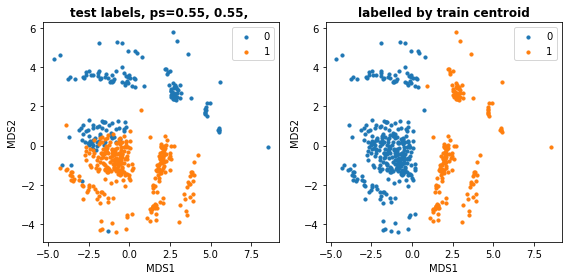

Explained variation per principal component: [0.34339273 0.24943873]
Explained variation per principal component: [0.34339273 0.24943873]
medoids shape (2, 18) [[-1.15560885 -0.44989029]
 [ 1.4441881  -1.40798163]]


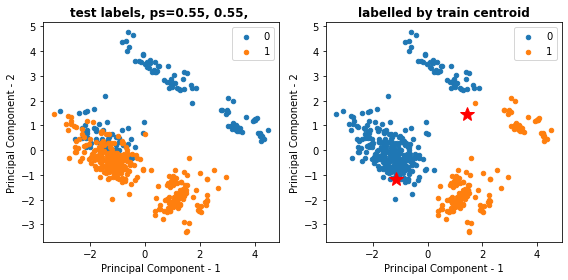

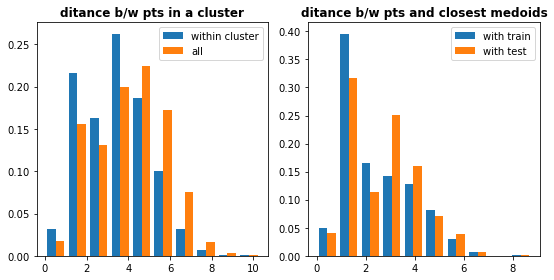

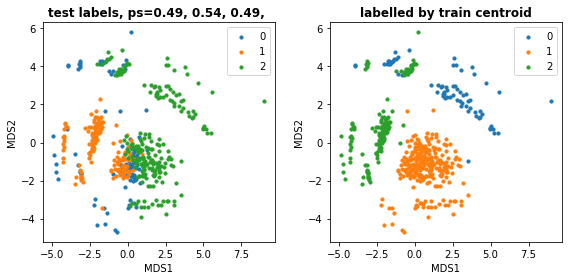

Explained variation per principal component: [0.33223119 0.27376953]
Explained variation per principal component: [0.33223119 0.27376953]
medoids shape (3, 18) [[ 0.58968733  3.23472173]
 [-1.17742344 -0.34208232]
 [ 1.30432103 -1.86437297]]


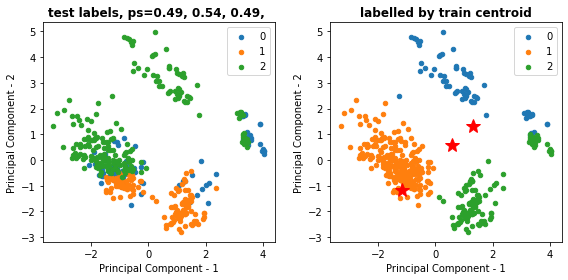

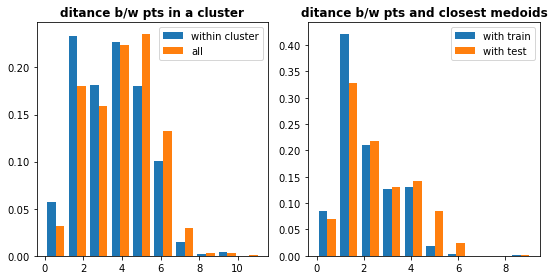

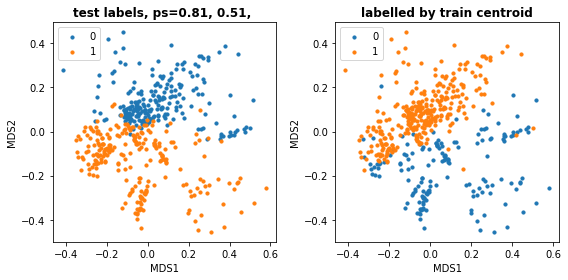

Explained variation per principal component: [0.33111294 0.26837687]
Explained variation per principal component: [0.33111294 0.26837687]
medoids shape (2, 18) [[-0.50298923  0.09783667]
 [-1.47378666 -0.31866401]]


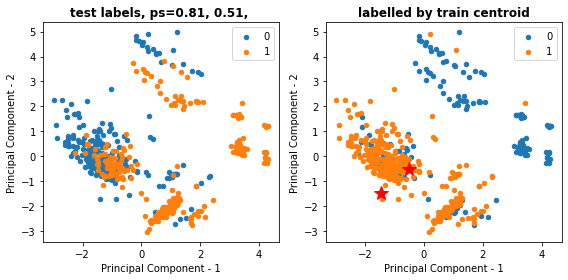

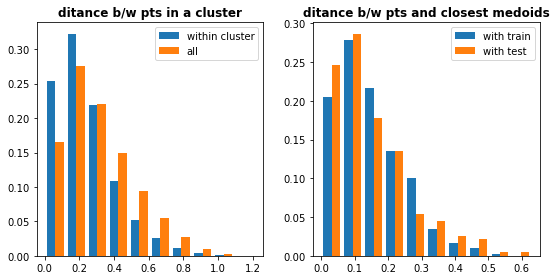

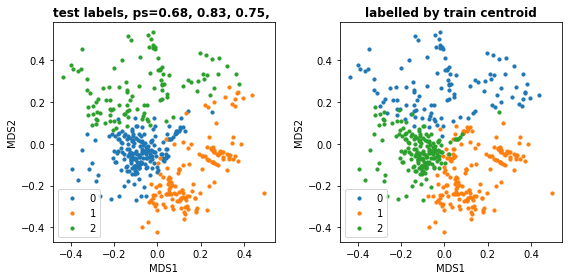

Explained variation per principal component: [0.35391422 0.26066412]
Explained variation per principal component: [0.35391422 0.26066412]
medoids shape (3, 18) [[-1.45894837  0.95126771]
 [-0.98256683 -1.00348088]
 [-1.24229676 -0.22999189]]


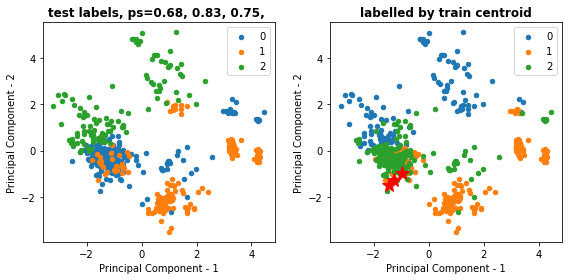

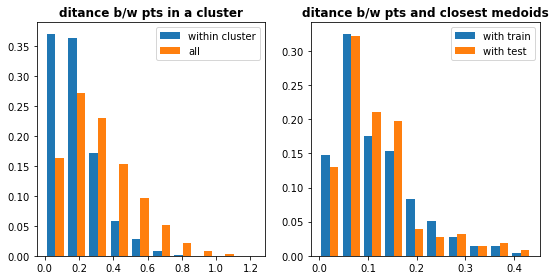

Clustering on log Fractions


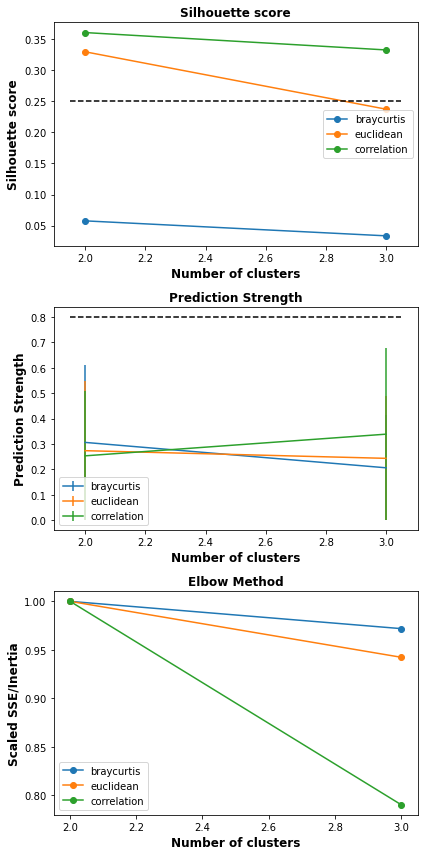

In [12]:
k_list=range(2, 4)
_=do_kmedoids(df_msa_logF[emp_naics_keys], k_list, ps_avgs=1,metrics_list=['braycurtis','euclidean','correlation'])
print ('Clustering on log Fractions')

Explained variation per principal component: [0.31 0.23]
Explained variation per principal component: [0.31 0.23]
medoids shape (2, 20) [[-1.95  0.12]
 [ 0.97 -2.26]]


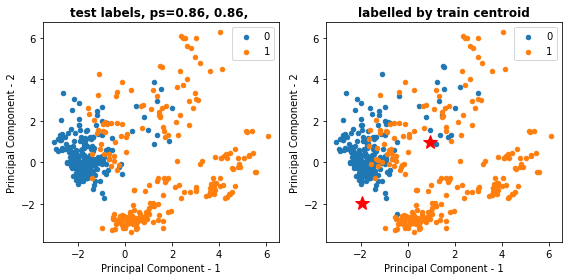

Explained variation per principal component: [0.31 0.24]
Explained variation per principal component: [0.31 0.24]
medoids shape (3, 20) [[-1.04  1.15]
 [ 1.31 -1.83]
 [-1.96 -0.11]]


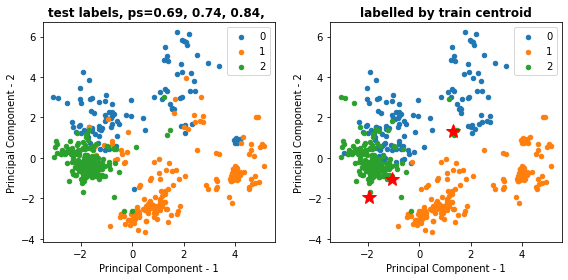

Explained variation per principal component: [0.29 0.23]
Explained variation per principal component: [0.29 0.23]
medoids shape (2, 20) [[-0.72 -0.67]
 [-1.41  0.29]]


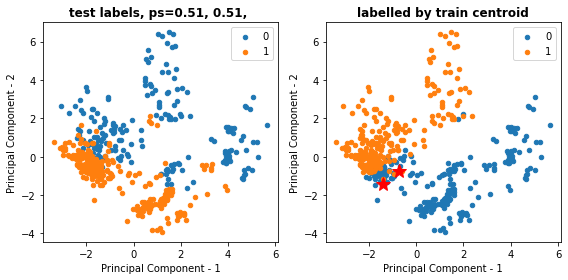

Explained variation per principal component: [0.3  0.23]
Explained variation per principal component: [0.3  0.23]
medoids shape (3, 20) [[ 1.72 -1.73]
 [-1.61 -0.36]
 [-1.38  1.43]]


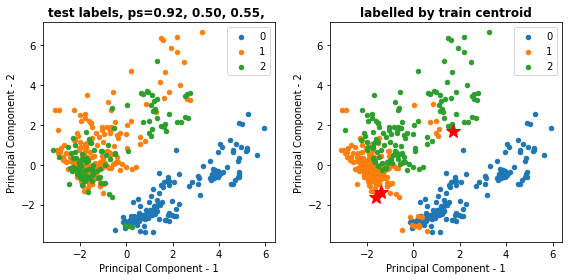

Explained variation per principal component: [0.29 0.24]
Explained variation per principal component: [0.29 0.24]
medoids shape (2, 20) [[-1.38  0.55]
 [-2.09 -0.79]]


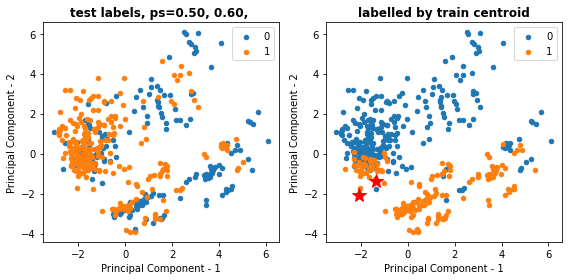

Explained variation per principal component: [0.31 0.23]
Explained variation per principal component: [0.31 0.23]
medoids shape (3, 20) [[-0.51  1.36]
 [-1.02 -0.97]
 [-1.81 -1.31]]


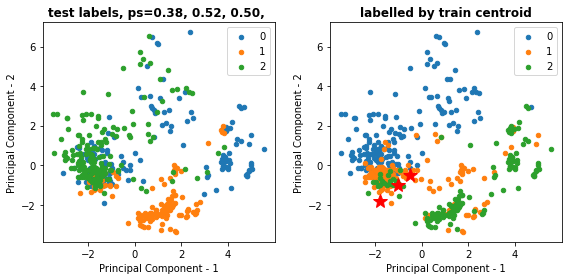

Clustering on log Fractions


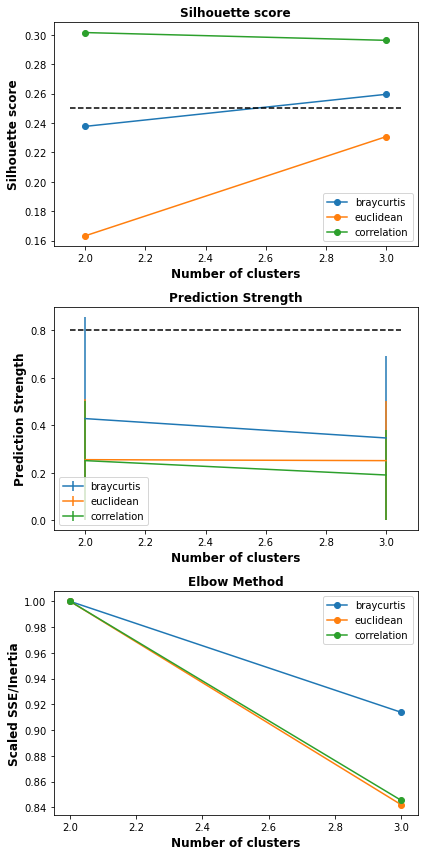

In [28]:
k_list=range(2, 4)
_=do_kmedoids(df_msa_logF[emp_naics_keys], k_list, ps_avgs=1,metrics_list=['braycurtis','euclidean','correlation'])
print ('Clustering on log Fractions')

#### Clustering on log Fractions
- finds 3 weak clusters according to Silhouette score but the prediction strength is below the acceptable threshold
- The clusters found by euclidean and bray curtis metrics agree, but correlation metric finds differetn clusters.
- PCA without standardizing gives a much better separation of the clusters that were found than PCA with standardizing because the clustering was done without standardizing.

- For k=2, overlap between Metro-micro classification and identified clusters is between 12% (Correlation) and 25% (bray curtis)

#### $\log (epsilon +f)$

Clustering on log Fractions


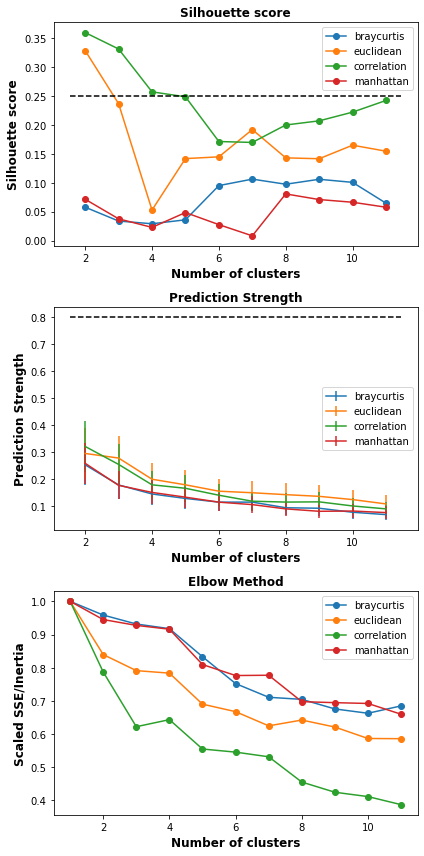

In [20]:
k_list=range(1,12)
_=do_kmedoids(df_msa_logF[emp_naics_keys], k_list, metrics_list=['braycurtis','euclidean','correlation','manhattan' ])
print ('Clustering on log Fractions')

#### $\log (1/N +f)$

Clustering on log Fractions


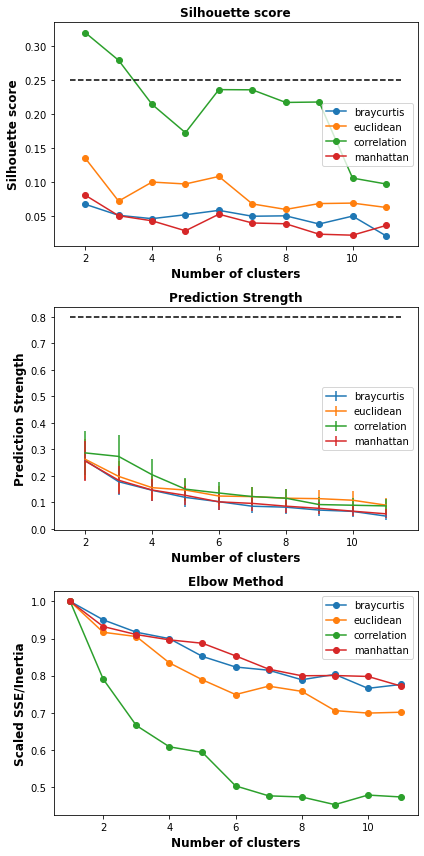

In [17]:
k_list=range(1,12)
_=do_kmedoids(df_msa_logF_1overN[emp_naics_keys], k_list, metrics_list=['braycurtis','euclidean','correlation','manhattan' ])
print ('Clustering on log Fractions')

#### $\log (\epsilon +n/N)$
( didn't renormalize after adding epsilon)

Clustering on log Fractions


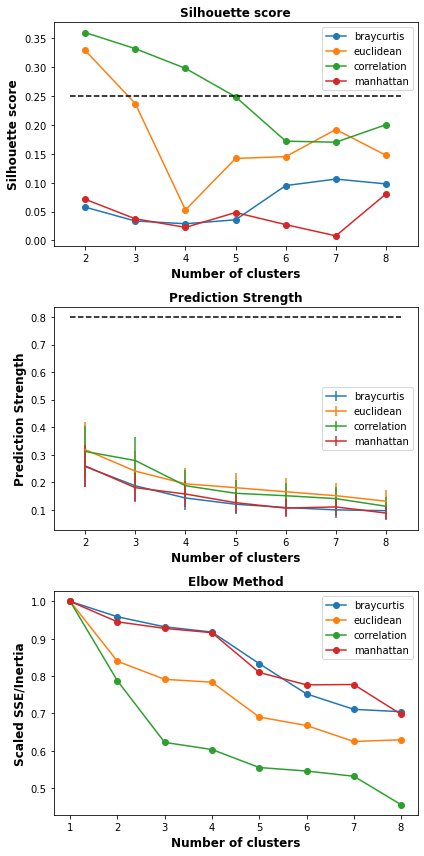

In [19]:
k_list=range(1, 9)
_=do_kmedoids(df_msa_old_logF[emp_naics_keys], k_list, metrics_list=['braycurtis','euclidean','correlation','manhattan' ])
print ('Clustering on log Fractions')

plotting PCA without standardizing.
Explained variation per principal component: [0.33395986 0.2656441 ]
plotting PCA without standardizing.
Explained variation per principal component: [0.33395986 0.2656441 ]
plotting PCA without standardizing.
Explained variation per principal component: [0.33395986 0.2656441 ]
plotting PCA without standardizing.
Explained variation per principal component: [0.33395986 0.2656441 ]


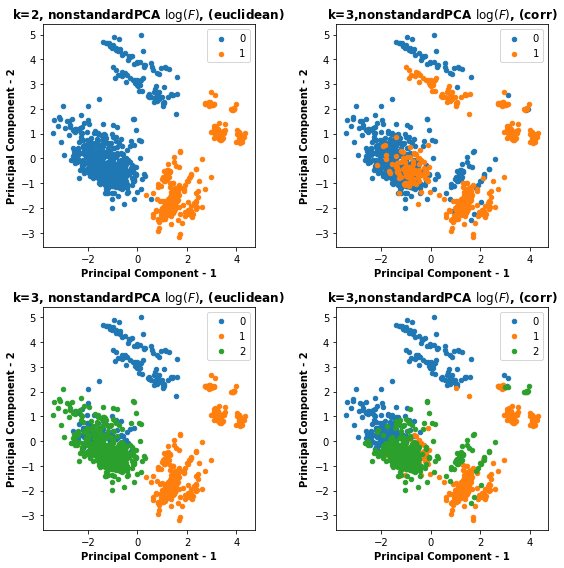

In [21]:
##
from scipy.spatial import distance as scipy_spatial_distance
fig2 = plt.figure(figsize=(8, 8))
ax1 = fig2.add_subplot(2, 2, 1)
km_obj, siScore, predStrengths = do_kmedoids(
    df_msa_logF[emp_naics_keys], [2], metrics_list=['euclidean'], show_fig=False)
df_labelled = df_msa_logF.copy()
df_labelled['cluster_id'] = km_obj.labels_
ax1, PCA_object = plot_PCA(
    ax1, df_labelled, emp_naics_keys, plot_nonStandard_PCA=True, label_key='cluster_id')
ax1.set_title(r'k=2, nonstandardPCA $\log (F)$, (euclidean)',
              fontweight='bold')

ax2 = fig2.add_subplot(2, 2, 2)
km_obj2, siScore2, predStrengths2 = do_kmedoids(
    df_msa_logF[emp_naics_keys], [2], metrics_list=['correlation'], show_fig=False)
df_labelled2 = df_msa_logF.copy()
df_labelled2['cluster_id'] = km_obj2.labels_
ax2, PCA_object = plot_PCA(
    ax2, df_labelled2, emp_naics_keys, plot_nonStandard_PCA=True, label_key='cluster_id')
ax2.set_title(r'k=3,nonstandardPCA $\log (F)$, (corr)', fontweight='bold')

ax3 = fig2.add_subplot(2, 2, 3)
km_obj, siScore, predStrengths = do_kmedoids(
    df_msa_logF[emp_naics_keys], [3], metrics_list=['euclidean'], show_fig=False)
df_labelled = df_msa_logF.copy()
df_labelled['cluster_id'] = km_obj.labels_
ax3, PCA_object = plot_PCA(
    ax3, df_labelled, emp_naics_keys, plot_nonStandard_PCA=True, label_key='cluster_id')
ax3.set_title(r'k=3, nonstandardPCA $\log (F)$, (euclidean)',
              fontweight='bold')

ax4 = fig2.add_subplot(2, 2, 4)
km_obj2, siScore2, predStrengths2 = do_kmedoids(
    df_msa_logF[emp_naics_keys], [3], metrics_list=['correlation'], show_fig=False)
df_labelled2 = df_msa_logF.copy()
df_labelled2['cluster_id'] = km_obj2.labels_
ax4, PCA_object = plot_PCA(
    ax4, df_labelled2, emp_naics_keys, plot_nonStandard_PCA=True, label_key='cluster_id')
ax4.set_title(r'k=3,nonstandardPCA $\log (F)$, (corr)', fontweight='bold')




fig2.patch.set_facecolor('white')
plt.tight_layout()
plt.show()





# fig2 = plt.figure(figsize=(8, 4))
# ax1 = fig2.add_subplot(1, 2, 1)

# km_obj, siScore, predStrengths = do_kmedoids(
#     df_msa_logF[emp_naics_keys], [2], metrics_list=['braycurtis'], show_fig=False)
# df_labelled = df_msa_logF.copy()
# df_labelled['cluster_id'] = km_obj.labels_
# ax1, PCA_object = plot_PCA(
#     ax1, df_labelled, emp_naics_keys, plot_nonStandard_PCA=True, label_key='cluster_id')
# ax1.set_title(r'k=2 nonstandardPCA $\log (F)$, (braycurtis)', fontweight='bold')

# ax2 = fig2.add_subplot(1, 2, 2)
# km_obj2, siScore2, predStrengths2 = do_kmedoids(
#     df_msa_logF[emp_naics_keys], [3], metrics_list=['correlation'], show_fig=False)
# df_labelled2 = df_msa_logF.copy()
# df_labelled2['cluster_id'] = km_obj2.labels_
# ax2, PCA_object = plot_PCA(
#     ax2, df_labelled2, emp_naics_keys, plot_nonStandard_PCA=True, label_key='cluster_id')
# ax2.set_title(r'k=3, nonstandardPCA $\log (F)$, (corr)', fontweight='bold')

# fig2.patch.set_facecolor('white')
# plt.tight_layout()
# plt.show()



# Metro_micro_labels = df_labelled['Metro'].values == 'Metro'
# cluster_labels = df_labelled['cluster_id'] == 1
# hamming_dist1 = scipy_spatial_distance.hamming(
#     Metro_micro_labels, cluster_labels)
# hamming_dist2 = scipy_spatial_distance.hamming(
#     Metro_micro_labels, 1-cluster_labels)
# print('hamming_distance between identified clusters and Metro-Micro=',
#       min(hamming_dist1, hamming_dist2))



#### Clustering before removing unclassified and education sectors.

Clustering on log Fractions


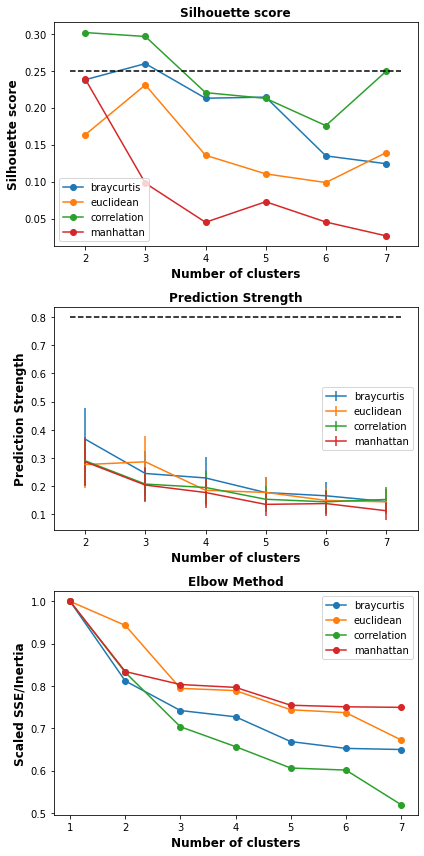

In [47]:
# k_list=range(1, 8)
# _=do_kmedoids(df_msa_logF[emp_naics_keys], k_list, metrics_list=['braycurtis','euclidean','correlation','manhattan' ])
# print ('Clustering on log Fractions')

plotting PCA without standardizing.
Explained variation per principal component: [0.3  0.24]
plotting PCA without standardizing.
Explained variation per principal component: [0.3  0.24]


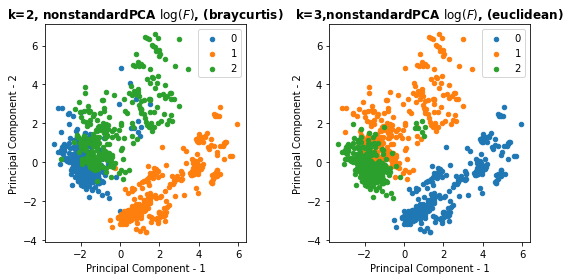

plotting PCA without standardizing.
Explained variation per principal component: [0.3  0.24]
plotting PCA without standardizing.
Explained variation per principal component: [0.3  0.24]


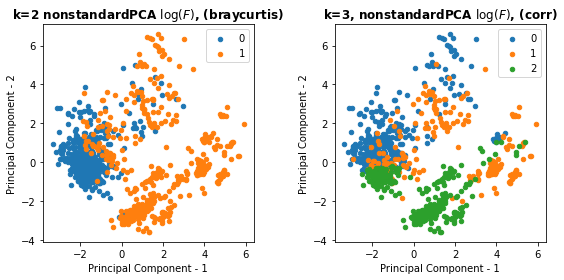

hamming_distance between identified clusters and Metro-Micro= 0.22615219721329047


In [52]:
##
from scipy.spatial import distance as scipy_spatial_distance
fig2 = plt.figure(figsize=(8, 4))
ax1 = fig2.add_subplot(1, 2, 1)

km_obj, siScore, predStrengths = do_kmedoids(
    df_msa_logF[emp_naics_keys], [3], metrics_list=['braycurtis'], show_fig=False)
df_labelled = df_msa_logF.copy()
df_labelled['cluster_id'] = km_obj.labels_
ax1, PCA_object = plot_PCA(
    ax1, df_labelled, emp_naics_keys, plot_nonStandard_PCA=True, label_key='cluster_id')
ax1.set_title(r'k=2, nonstandardPCA $\log (F)$, (braycurtis)',
              fontweight='bold')

ax2 = fig2.add_subplot(1, 2, 2)
km_obj2, siScore2, predStrengths2 = do_kmedoids(
    df_msa_logF[emp_naics_keys], [3], metrics_list=['euclidean'], show_fig=False)
df_labelled2 = df_msa_logF.copy()
df_labelled2['cluster_id'] = km_obj2.labels_
ax2, PCA_object = plot_PCA(
    ax2, df_labelled2, emp_naics_keys, plot_nonStandard_PCA=True, label_key='cluster_id')
ax2.set_title(r'k=3,nonstandardPCA $\log (F)$, (euclidean)', fontweight='bold')

fig2.patch.set_facecolor('white')
plt.tight_layout()
plt.show()





fig2 = plt.figure(figsize=(8, 4))
ax1 = fig2.add_subplot(1, 2, 1)

km_obj, siScore, predStrengths = do_kmedoids(
    df_msa_logF[emp_naics_keys], [2], metrics_list=['braycurtis'], show_fig=False)
df_labelled = df_msa_logF.copy()
df_labelled['cluster_id'] = km_obj.labels_
ax1, PCA_object = plot_PCA(
    ax1, df_labelled, emp_naics_keys, plot_nonStandard_PCA=True, label_key='cluster_id')
ax1.set_title(r'k=2 nonstandardPCA $\log (F)$, (braycurtis)', fontweight='bold')

ax2 = fig2.add_subplot(1, 2, 2)
km_obj2, siScore2, predStrengths2 = do_kmedoids(
    df_msa_logF[emp_naics_keys], [3], metrics_list=['correlation'], show_fig=False)
df_labelled2 = df_msa_logF.copy()
df_labelled2['cluster_id'] = km_obj2.labels_
ax2, PCA_object = plot_PCA(
    ax2, df_labelled2, emp_naics_keys, plot_nonStandard_PCA=True, label_key='cluster_id')
ax2.set_title(r'k=3, nonstandardPCA $\log (F)$, (corr)', fontweight='bold')

fig2.patch.set_facecolor('white')
plt.tight_layout()
plt.show()



Metro_micro_labels = df_labelled['Metro'].values == 'Metro'
cluster_labels = df_labelled['cluster_id'] == 1
hamming_dist1 = scipy_spatial_distance.hamming(
    Metro_micro_labels, cluster_labels)
hamming_dist2 = scipy_spatial_distance.hamming(
    Metro_micro_labels, 1-cluster_labels)
print('hamming_distance between identified clusters and Metro-Micro=',
      min(hamming_dist1, hamming_dist2))

# fig2 = plt.figure(figsize=(8, 4))
# ax1 = fig2.add_subplot(1, 2, 1)

# km_obj, siScore, predStrengths = do_kmedoids(
#     df_msa_logF[emp_naics_keys], [2], metrics_list=['braycurtis'], show_fig=False)
# df_labelled = df_msa_logF.copy()
# df_labelled['cluster_id'] = km_obj.labels_
# ax1, PCA_object = plot_PCA(
#     ax1, df_labelled, emp_naics_keys, standardized=False, label_key='cluster_id')
# ax1.set_title(r'k=2, PCA of $\log (\epsilon +F)$', fontweight='bold')

# ax2 = fig2.add_subplot(1, 2, 2)
# km_obj2, siScore2, predStrengths2 = do_kmedoids(
#     df_msa_logF[emp_naics_keys], [3], metrics_list=['braycurtis'], show_fig=False)
# df_labelled2 = df_msa_logF.copy()
# df_labelled2['cluster_id'] = km_obj2.labels_
# ax2, PCA_object = plot_PCA(
#     ax2, df_labelled2, emp_naics_keys, standardized=False, label_key='cluster_id')
# ax2.set_title(r'k=3, PCA of $\log (\epsilon +F)$', fontweight='bold')

# fig2.patch.set_facecolor('white')
# plt.tight_layout()
# plt.show()

Standardizing log F before clustering makes it harder to cluster

Standardizing before clustering.
Clustering on log Fractions after standardizing


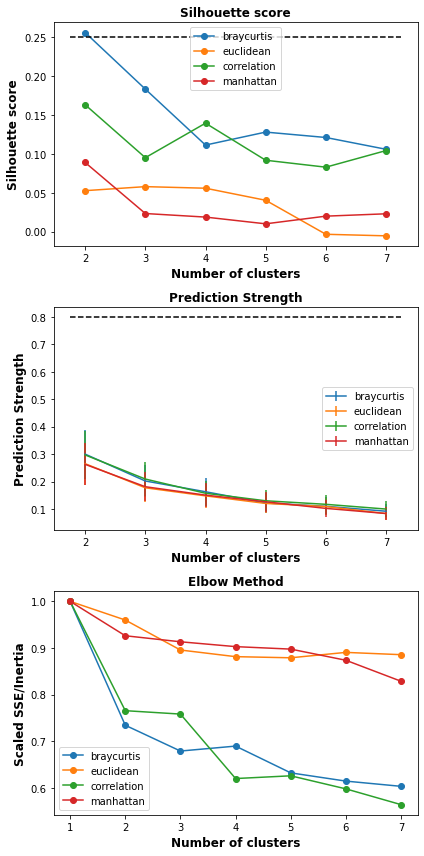

In [31]:
#
k_list=range(1, 8)
_=do_kmedoids(df_msa_logF[emp_naics_keys], k_list, metrics_list=['braycurtis','euclidean','correlation','manhattan' ], standardize=True)
print ('Clustering on log Fractions after standardizing')

#### Clustering on CLR(f)

In [72]:
np.arange(1,8,2)

array([1, 3, 5, 7])

Clustering on CLR CLR fractions


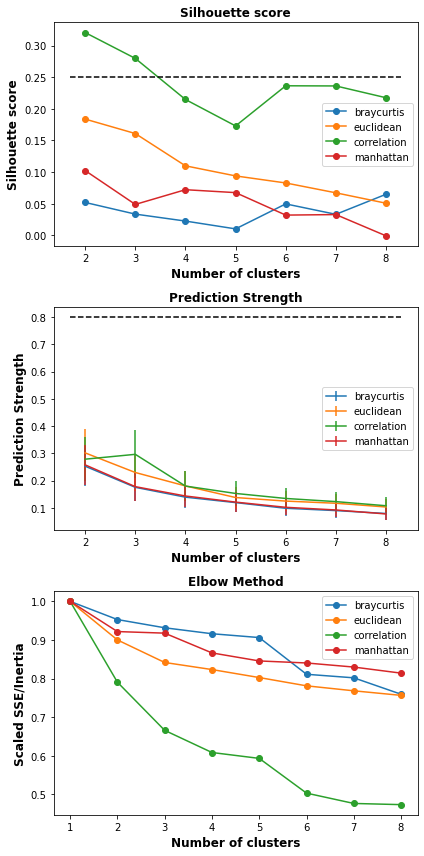

In [11]:
k_list=range(1, 9)
_=do_kmedoids(df_msa_CLRf[emp_naics_keys], k_list, metrics_list=['braycurtis','euclidean','correlation','manhattan' ])
print ('Clustering on CLR CLR fractions')

plotting PCA without standardizing.
Explained variation per principal component: [0.32085716 0.2427953 ]
plotting PCA without standardizing.
Explained variation per principal component: [0.32085716 0.2427953 ]
plotting PCA without standardizing.
Explained variation per principal component: [0.32085716 0.2427953 ]
plotting PCA without standardizing.
Explained variation per principal component: [0.32085716 0.2427953 ]


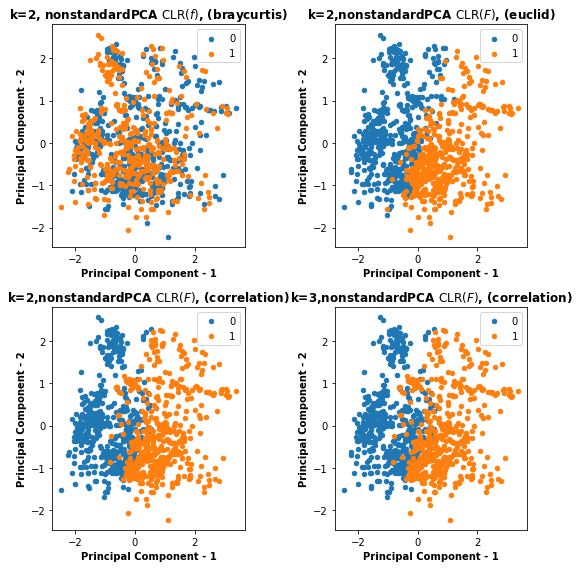

In [37]:
from scipy.spatial import distance as scipy_spatial_distance
fig2 = plt.figure(figsize=(8, 8))
ax1 = fig2.add_subplot(2, 2, 1)

km_obj, siScore, predStrengths = do_kmedoids(
    df_msa_CLRf[emp_naics_keys], [2], metrics_list=['braycurtis'], show_fig=False)
df_labelled = df_msa_CLRf.copy()
df_labelled['cluster_id'] = km_obj.labels_
ax1, PCA_object = plot_PCA(
    ax1, df_labelled, emp_naics_keys, plot_nonStandard_PCA=True, label_key='cluster_id')
ax1.set_title(r'k=2, nonstandardPCA $\mathsf{CLR} (f)$, (braycurtis)',
              fontweight='bold')

ax2 = fig2.add_subplot(2, 2, 2)
km_obj2, siScore2, predStrengths2 = do_kmedoids(
    df_msa_CLRf[emp_naics_keys], [2], metrics_list=['euclidean'], show_fig=False)
df_labelled2 =df_msa_CLRf.copy()
df_labelled2['cluster_id'] = km_obj2.labels_
ax2, PCA_object = plot_PCA(
    ax2, df_labelled2, emp_naics_keys, plot_nonStandard_PCA=True, label_key='cluster_id')
ax2.set_title(r'k=2,nonstandardPCA $\mathsf{CLR}(F)$, (euclid)', fontweight='bold')


ax3 = fig2.add_subplot(2, 2, 3)
km_obj2, siScore2, predStrengths2 = do_kmedoids(
    df_msa_CLRf[emp_naics_keys], [2], metrics_list=['correlation'], show_fig=False)
df_labelled2 =df_msa_CLRf.copy()
df_labelled2['cluster_id'] = km_obj2.labels_
ax3, PCA_object = plot_PCA(
    ax3, df_labelled2, emp_naics_keys, plot_nonStandard_PCA=True, label_key='cluster_id')
ax3.set_title(r'k=2,nonstandardPCA $\mathsf{CLR}(F)$, (correlation)', fontweight='bold')

ax4 = fig2.add_subplot(2, 2, 4)
km_obj2, siScore2, predStrengths2 = do_kmedoids(
    df_msa_CLRf[emp_naics_keys], [2], metrics_list=['correlation'], show_fig=False)
df_labelled2 =df_msa_CLRf.copy()
df_labelled2['cluster_id'] = km_obj2.labels_
ax4, PCA_object = plot_PCA(
    ax4, df_labelled2, emp_naics_keys, plot_nonStandard_PCA=True, label_key='cluster_id')
ax4.set_title(r'k=3,nonstandardPCA $\mathsf{CLR}(F)$, (correlation)', fontweight='bold')

fig2.patch.set_facecolor('white')
plt.tight_layout()
plt.show()


#### Clustering on Fractions

- finds 2 clusters supported by both Silhouette score and prediction strength on two metrics:euclidean and correlation.
- clusters found by both metrics agree. The overlap with metro-micro classification is ~10%

Clustering on Fractions


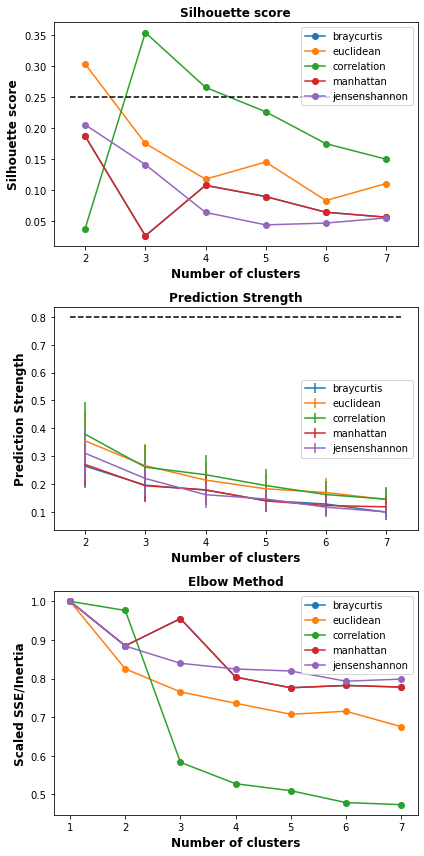

In [9]:
k_list = range(1, 8)
_ = do_kmedoids(df_msa_fractions[emp_naics_keys], k_list, metrics_list=[
                'braycurtis', 'euclidean', 'correlation', 'manhattan', 'jensenshannon'])
print('Clustering on Fractions')

[[[2, 0.4643215663035752]]] [[[2, 0.44188400129900735, 0.12840726046254905]]]
plotting PCA without standardizing.
Explained variation per principal component: [0.51 0.13]
[[[2, 0.2804925224065956]]] [[[2, 0.3432947995348985, 0.10360425319791942]]]
plotting PCA without standardizing.
Explained variation per principal component: [0.51 0.13]


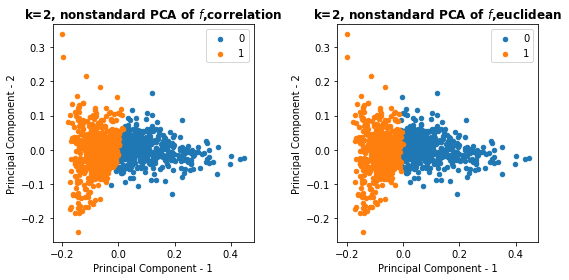

hamming_distance between identified clusters and Metro-Micro= 0.3783494105037513


In [43]:
# ## plot pCA with standardizatio
# fig2 = plt.figure(figsize=(8, 4))
# ax1 = fig2.add_subplot(1, 2, 1)

# km_obj, siScore, predStrengths = do_kmedoids(
#     df_msa_fractions[emp_naics_keys], [2], metrics_list=['correlation'], show_fig=False)
# df_labelled = df_msa_fractions.copy()
# df_labelled['cluster_id'] = km_obj.labels_
# ax1, PCA_object = plot_PCA(
#     ax1, df_labelled, emp_naics_keys, standardized=False, label_key='cluster_id')
# ax1.set_title(r'k=2, PCA of $f$, correlation', fontweight='bold')

# ax2 = fig2.add_subplot(1, 2, 2)
# km_obj2, siScore2, predStrengths2 = do_kmedoids(
#     df_msa_fractions[emp_naics_keys], [2], metrics_list=['euclidean'], show_fig=False)
# df_labelled2 = df_msa_fractions.copy()
# df_labelled2['cluster_id'] = km_obj2.labels_
# ax2, PCA_object = plot_PCA(
#     ax2, df_labelled2, emp_naics_keys, standardized=False, label_key='cluster_id')
# ax2.set_title(r'k=3, PCA of $f$, euclidean', fontweight='bold')

# fig2.patch.set_facecolor('white')
# plt.tight_layout()
# plt.show()

# plot pCA without standardization
fig2 = plt.figure(figsize=(8, 4))
ax1 = fig2.add_subplot(1, 2, 1)

km_obj, siScore, predStrengths = do_kmedoids(
    df_msa_fractions[emp_naics_keys], [2], metrics_list=['correlation'], show_fig=False)
df_labelled = df_msa_fractions.copy()
df_labelled['cluster_id'] = km_obj.labels_
ax1, PCA_object = plot_PCA(
    ax1, df_labelled, emp_naics_keys, plot_nonStandard_PCA=True, label_key='cluster_id')
ax1.set_title(r'k=2, nonstandard PCA of $f$,correlation', fontweight='bold')

ax2 = fig2.add_subplot(1, 2, 2)
km_obj2, siScore2, predStrengths2 = do_kmedoids(
    df_msa_fractions[emp_naics_keys], [2], metrics_list=['euclidean'], show_fig=False)
df_labelled2 = df_msa_fractions.copy()
df_labelled2['cluster_id'] = km_obj2.labels_
ax2, PCA_object = plot_PCA(
    ax2, df_labelled2, emp_naics_keys, plot_nonStandard_PCA=True, label_key='cluster_id')
ax2.set_title(r'k=2, nonstandard PCA of $f$,euclidean', fontweight='bold')

fig2.patch.set_facecolor('white')
plt.tight_layout()
plt.show()


from scipy.spatial import distance as scipy_spatial_distance
Metro_micro_labels = df_labelled['Metro'].values == 'Metro'
cluster_labels = df_labelled['cluster_id'] == 1
hamming_dist1 = scipy_spatial_distance.hamming(
    Metro_micro_labels, cluster_labels)
hamming_dist2 = scipy_spatial_distance.hamming(
    Metro_micro_labels, 1-cluster_labels)
print('hamming_distance between identified clusters and Metro-Micro=',
      min(hamming_dist1, hamming_dist2))

#### Clustering of just Metros

- not much support for significant clusters in both fractions and logF

Clustering on log Fractions of metros


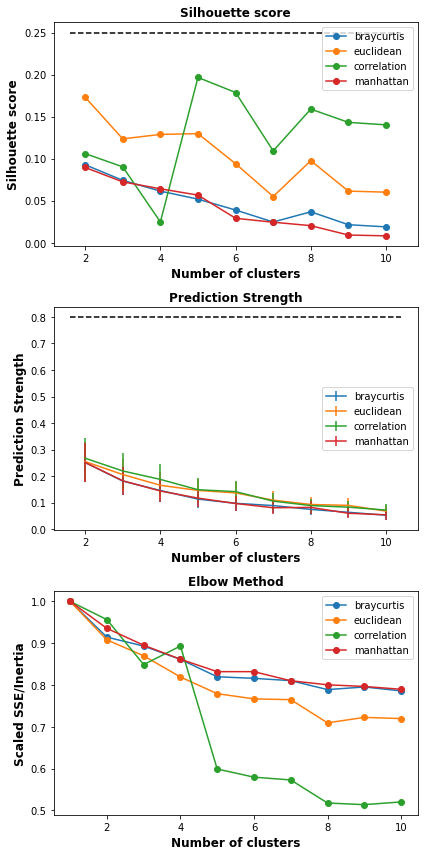

In [16]:
k_list=range(1, 11)

df_metro_logF=df_msa_logF[df_msa_logF['Metro']=='Metro']
_=do_kmedoids(df_metro_logF[emp_naics_keys], k_list, metrics_list=['braycurtis','euclidean','correlation','manhattan' ])
print ('Clustering on log Fractions of metros')

Clustering of Metros with fractions

Clustering on log Fractions of metros


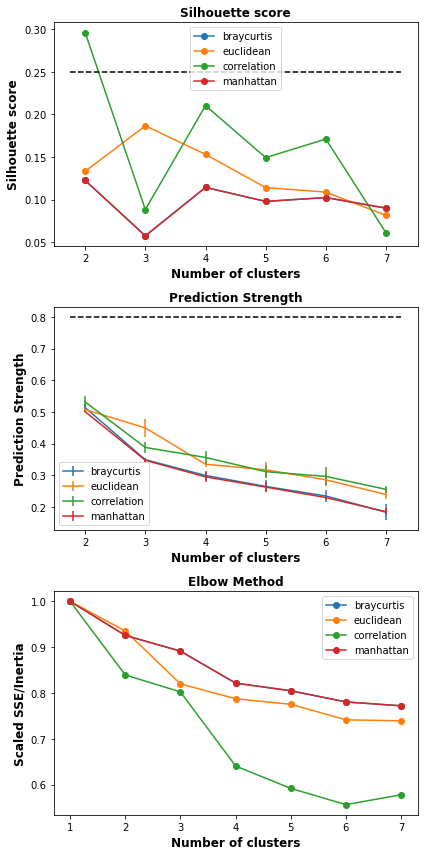

In [80]:
k_list=range(1, 8)

df_metro_fracs=df_msa_fractions[df_msa_fractions['Metro']=='Metro']
_=do_kmedoids(df_metro_fracs[emp_naics_keys], k_list, metrics_list=['braycurtis','euclidean','correlation','manhattan' ])
print ('Clustering on log Fractions of metros')

#### Using pairwise distance as features for the clustering algorithm.
- this increases the silhouette score of the clustering algorithm, even though the feature space is more high-dimensional
-prediction strength is not improved

**for logF:**

Text(0.0, 1.0, 'euclidean distance is features')

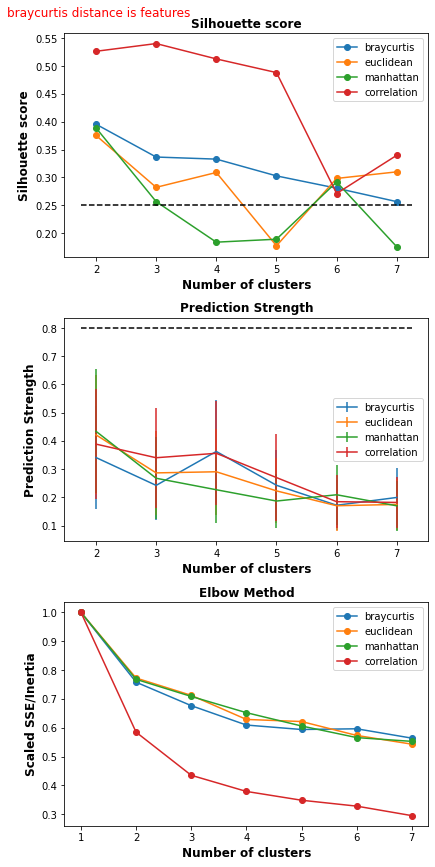

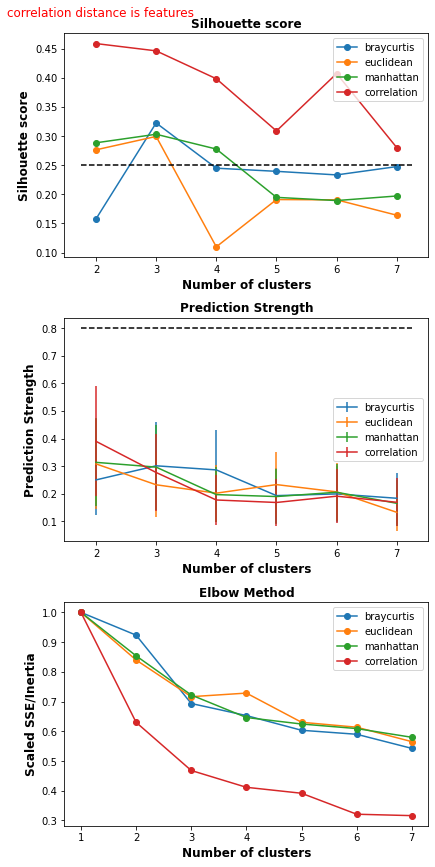

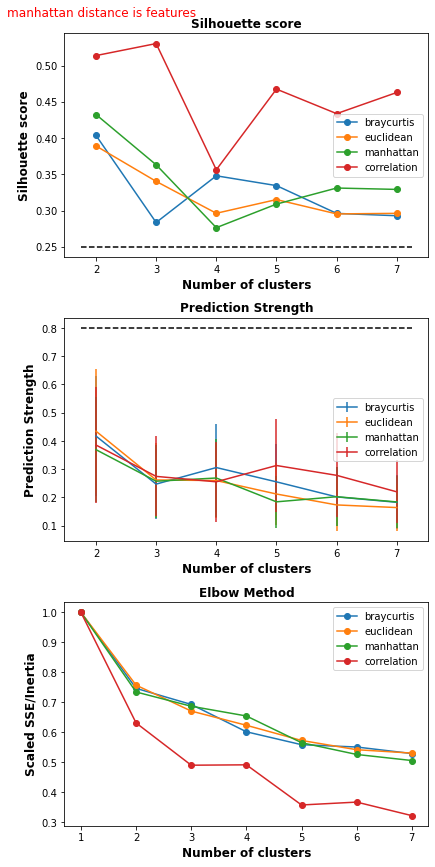

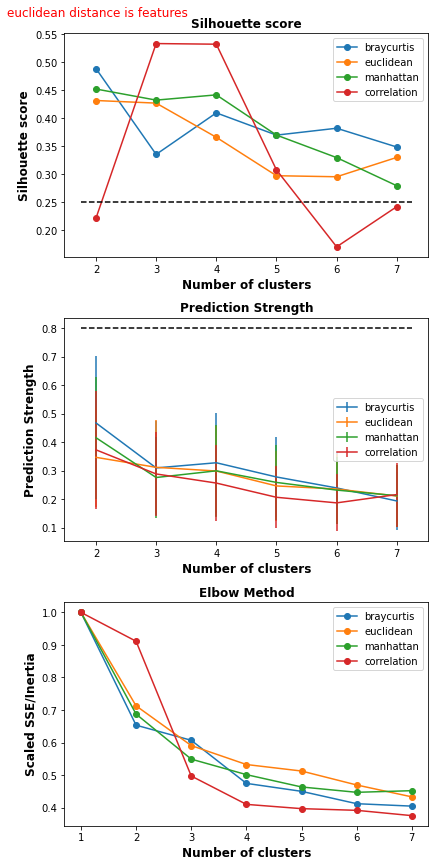

In [41]:
pwise_dist=compute_pairwise_distances(df_msa_logF[emp_naics_keys].values, 'braycurtis')
df_Pwise_dist_as_features=pd.DataFrame(pwise_dist)
k_list=range(1, 8)
_,_,_,fig=do_kmedoids(df_Pwise_dist_as_features, k_list,ps_avgs=4, metrics_list=['braycurtis','euclidean','manhattan', 'correlation' ])
fig.text(0.0, 1., 'braycurtis distance is features', fontsize = 12,va='top',color='red') 

pwise_dist=compute_pairwise_distances(df_msa_logF[emp_naics_keys].values, 'correlation')
df_Pwise_dist_as_features=pd.DataFrame(pwise_dist)
k_list=range(1, 8)
_,_,_,fig=do_kmedoids(df_Pwise_dist_as_features, k_list, ps_avgs=4, metrics_list=['braycurtis','euclidean','manhattan', 'correlation' ])
fig.text(0.0, 1., 'correlation distance is features', fontsize = 12,va='top',color='red') 

pwise_dist=compute_pairwise_distances(df_msa_logF[emp_naics_keys].values, 'manhattan')
df_Pwise_dist_as_features=pd.DataFrame(pwise_dist)
k_list=range(1, 8)
_,_,_,fig=do_kmedoids(df_Pwise_dist_as_features, k_list, ps_avgs=4, metrics_list=['braycurtis','euclidean','manhattan', 'correlation' ])
fig.text(0.0, 1., 'manhattan distance is features', fontsize = 12,va='top',color='red') 

pwise_dist=compute_pairwise_distances(df_msa_logF[emp_naics_keys].values, 'euclidean')
df_Pwise_dist_as_features=pd.DataFrame(pwise_dist)
k_list=range(1, 8)
_,_,_,fig=do_kmedoids(df_Pwise_dist_as_features, k_list,ps_avgs=4, metrics_list=['braycurtis','euclidean','manhattan', 'correlation' ])
fig.text(0.0, 1., 'euclidean distance is features', fontsize = 12,va='top',color='red') 


**for fractions:**

Text(0.0, 1.0, 'euclidean distance is features')

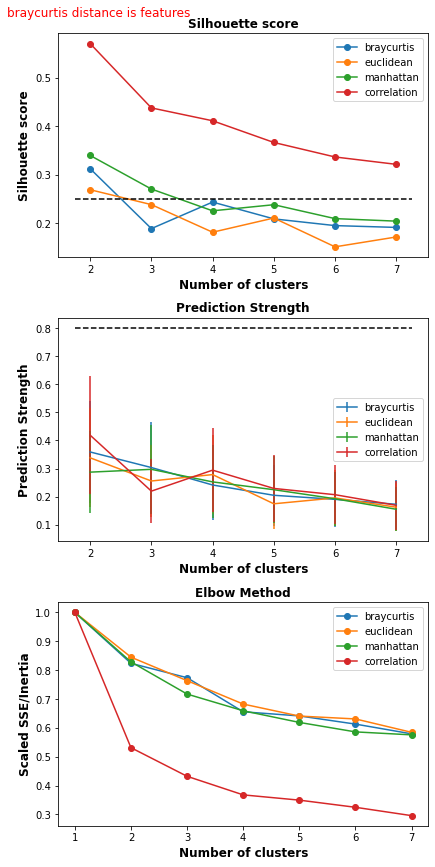

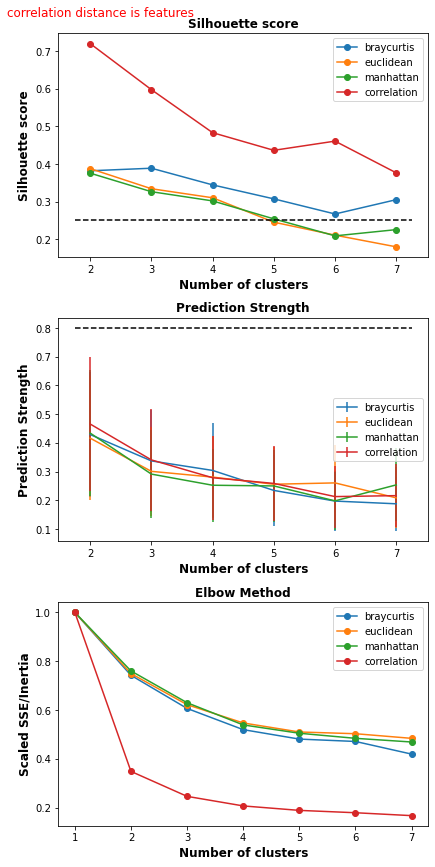

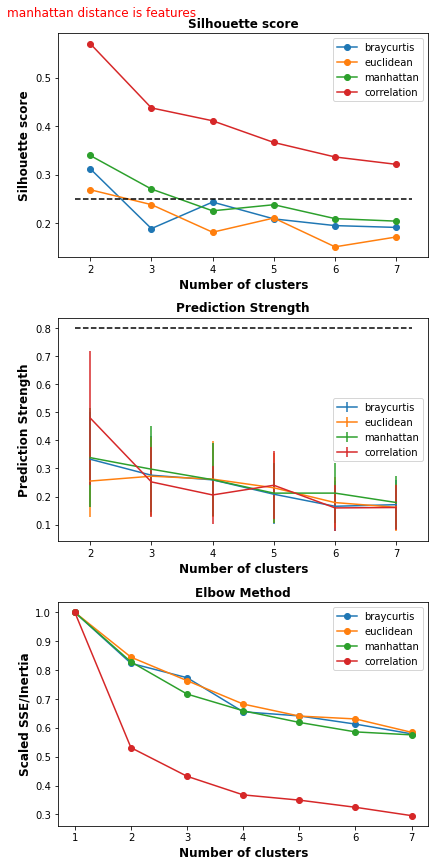

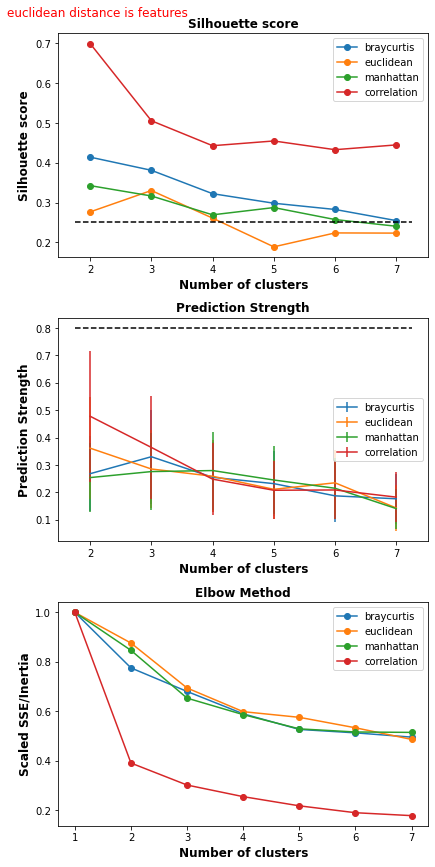

In [53]:
pwise_dist=compute_pairwise_distances(df_msa_fractions[emp_naics_keys].values, 'braycurtis')
df_Pwise_dist_as_features=pd.DataFrame(pwise_dist)
k_list=range(1, 8)
_,_,_,fig=do_kmedoids(df_Pwise_dist_as_features, k_list,ps_avgs=4, metrics_list=['braycurtis','euclidean','manhattan', 'correlation' ])
fig.text(0.0, 1., 'braycurtis distance is features', fontsize = 12,va='top',color='red') 

pwise_dist=compute_pairwise_distances(df_msa_fractions[emp_naics_keys].values, 'correlation')
df_Pwise_dist_as_features=pd.DataFrame(pwise_dist)
k_list=range(1, 8)
_,_,_,fig=do_kmedoids(df_Pwise_dist_as_features, k_list, ps_avgs=4, metrics_list=['braycurtis','euclidean','manhattan', 'correlation' ])
fig.text(0.0, 1., 'correlation distance is features', fontsize = 12,va='top',color='red') 

pwise_dist=compute_pairwise_distances(df_msa_fractions[emp_naics_keys].values, 'manhattan')
df_Pwise_dist_as_features=pd.DataFrame(pwise_dist)
k_list=range(1, 8)
_,_,_,fig=do_kmedoids(df_Pwise_dist_as_features, k_list, ps_avgs=4, metrics_list=['braycurtis','euclidean','manhattan', 'correlation' ])
fig.text(0.0, 1., 'manhattan distance is features', fontsize = 12,va='top',color='red') 

pwise_dist=compute_pairwise_distances(df_msa_fractions[emp_naics_keys].values, 'euclidean')
df_Pwise_dist_as_features=pd.DataFrame(pwise_dist)
k_list=range(1, 8)
_,_,_,fig=do_kmedoids(df_Pwise_dist_as_features, k_list,ps_avgs=4, metrics_list=['braycurtis','euclidean','manhattan', 'correlation' ])
fig.text(0.0, 1., 'euclidean distance is features', fontsize = 12,va='top',color='red') 


#### k-means without dimensional reduction finds few clusters

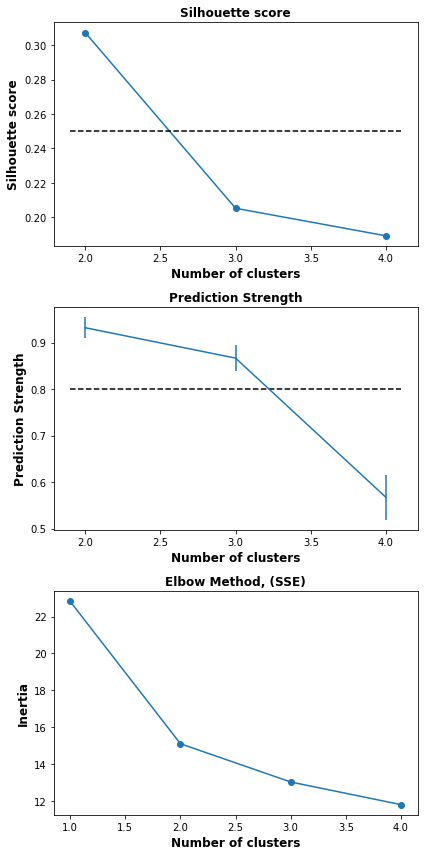

In [91]:
k_list= range(1, 5) 
do_kmeans(df_msa_fractions[emp_naics_keys], k_list )

**for logF**

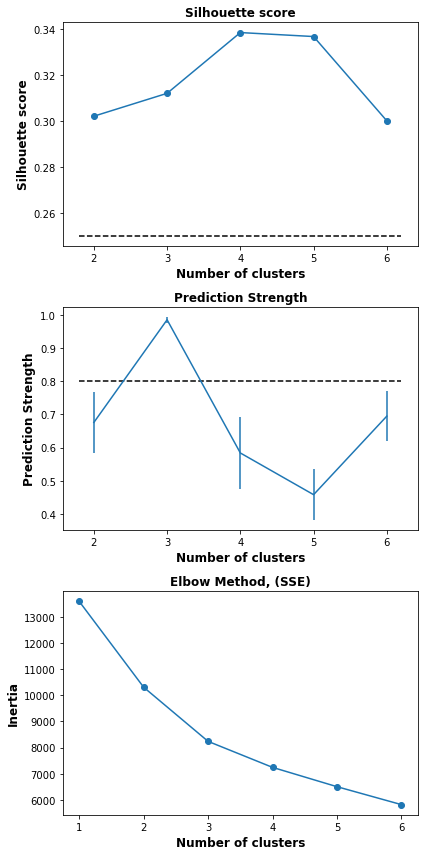

In [92]:
k_list=range(1,7)
do_kmeans(df_msa_logF[emp_naics_keys], k_list)

[[3, 0.3119912206246146]] [[3, 0.9127139317705355, 0.076287985982224]]
Explained variation per principal component: [0.19 0.12]
[[2, 0.3072737712503811]] [[2, 0.9409447334991837, 0.014542893132649861]]
Explained variation per principal component: [0.19 0.12]


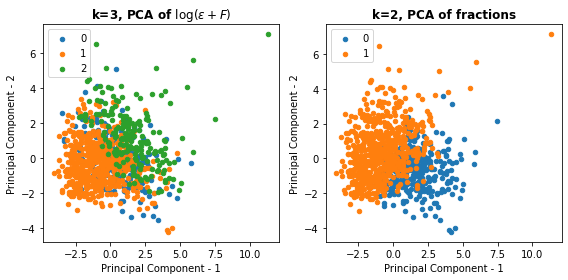

[[3, 0.3217860945981418]] [[3, 0.9968253968253968, 0.0028980029497627908]]
plotting PCA wihtout standardizing.
Explained variation per principal component: [0.3  0.24]
[[2, 0.3072737712503811]] [[2, 0.9617302466433643, 0.007843114988058713]]
plotting PCA wihtout standardizing.
Explained variation per principal component: [0.3  0.24]


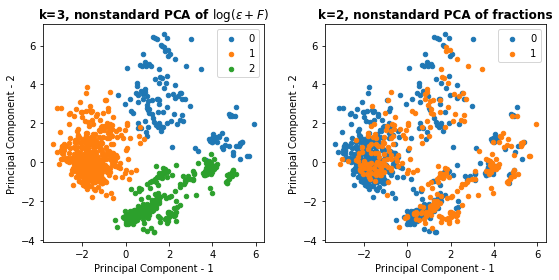

hamming_distance between identified clusters and Metro-Micro= 0.36441586280814575


In [42]:
fig2 = plt.figure(figsize=(8, 4))
ax1 = fig2.add_subplot(1, 2, 1)

km_obj, siScore, predStrengths = do_kmeans(df_msa_logF[emp_naics_keys],[3], show_fig=False)
df_labelled = df_msa_logF.copy()
df_labelled['cluster_id'] = km_obj.labels_
ax1, PCA_object = plot_PCA(
    ax1, df_labelled, emp_naics_keys, standardized=False, label_key='cluster_id')
ax1.set_title(r'k=3, PCA of $\log (\epsilon +F)$', fontweight='bold')

ax2 = fig2.add_subplot(1, 2, 2)
km_obj2, siScore2, predStrengths2 = do_kmeans(df_msa_fractions[emp_naics_keys],[2], show_fig=False)
df_labelled2 = df_msa_logF.copy()
df_labelled2['cluster_id'] = km_obj2.labels_
ax2, PCA_object = plot_PCA(
    ax2, df_labelled2, emp_naics_keys, standardized=False, label_key='cluster_id')
ax2.set_title(r'k=2, PCA of fractions', fontweight='bold')

fig2.patch.set_facecolor('white')
plt.tight_layout()
plt.show()

fig2 = plt.figure(figsize=(8, 4))
ax1 = fig2.add_subplot(1, 2, 1)

km_obj, siScore, predStrengths = do_kmeans(df_msa_logF[emp_naics_keys],[3], show_fig=False)
df_labelled = df_msa_logF.copy()
df_labelled['cluster_id'] = km_obj.labels_
ax1, PCA_object = plot_PCA(
    ax1, df_labelled, emp_naics_keys, plot_nonStandard_PCA=True, label_key='cluster_id')
ax1.set_title(r'k=3, nonstandard PCA of $\log (\epsilon +F)$', fontweight='bold')

ax2 = fig2.add_subplot(1, 2, 2)
km_obj2, siScore2, predStrengths2 = do_kmeans(df_msa_fractions[emp_naics_keys],[2], show_fig=False)
df_labelled2 = df_msa_logF.copy()
df_labelled2['cluster_id'] = km_obj2.labels_
ax2, PCA_object = plot_PCA(
    ax2, df_labelled2, emp_naics_keys, plot_nonStandard_PCA=True, label_key='cluster_id')
ax2.set_title(r'k=2, nonstandard PCA of fractions', fontweight='bold')

fig2.patch.set_facecolor('white')
plt.tight_layout()
plt.show()
from scipy.spatial import distance as scipy_spatial_distance
Metro_micro_labels = df_labelled2['Metro'].values == 'Metro'
cluster_labels = df_labelled2['cluster_id'] == 1
hamming_dist1 = scipy_spatial_distance.hamming(
    Metro_micro_labels, cluster_labels)
hamming_dist2 = scipy_spatial_distance.hamming(
    Metro_micro_labels, 1-cluster_labels)
print('hamming_distance between identified clusters and Metro-Micro=',
      min(hamming_dist1, hamming_dist2))

**for logN**

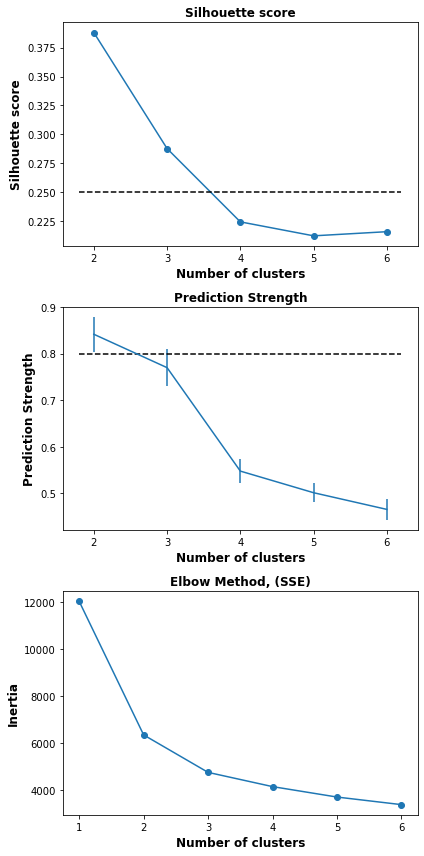

In [104]:
sum_and_naics_keys = ['summed_emp'] + emp_naics_keys
logNemp = np.log10(1.0+df_msa.loc[:, sum_and_naics_keys].values)
df_msa_logN = pd.DataFrame(logNemp, columns=sum_and_naics_keys)
do_kmeans(df_msa_logN[emp_naics_keys], k_list= range(1, 7) )

## k-medoids after dimensionality reduction finds clusters

dimensionality reduction improves silhouette score but not prediction strength.

total explained variation = 0.8202480818367641


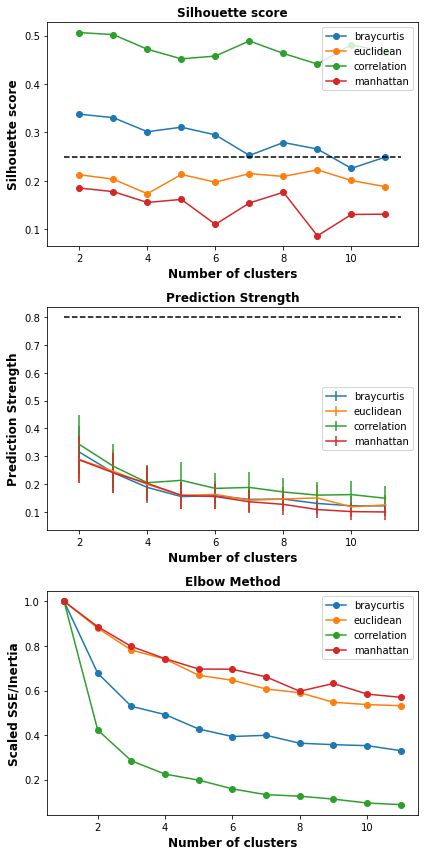

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

target_dim = 4
PCA_obj = PCA(n_components=target_dim)
# pca_vals = PCA_obj.fit_transform(df_msa_logF[emp_naics_keys])
pca_vals = PCA_obj.fit_transform(df_msa_CLRf[emp_naics_keys])
print('total explained variation = {}'.format(
    np.sum(PCA_obj.explained_variance_ratio_)))
pca_column_names = ['PC'+str(i+1) for i in range(target_dim)]
pca_vals_df = pd.DataFrame(data=pca_vals, columns=pca_column_names)

k_list = range(1, 12)
_,_,_,fig = do_kmedoids(pca_vals_df, k_list, metrics_list=[
                'braycurtis', 'euclidean', 'correlation', 'manhattan'])


plotting PCA without standardizing.
Explained variation per principal component: [0.39117088 0.29600227]
plotting PCA without standardizing.
Explained variation per principal component: [0.39117088 0.29600227]
plotting PCA without standardizing.
Explained variation per principal component: [0.39117088 0.29600227]
plotting PCA without standardizing.
Explained variation per principal component: [0.39117088 0.29600227]


FileNotFoundError: [Errno 2] No such file or directory: '/Users/ashish/Dropbox/research/James/summary plots/poor_clustering.pdf'

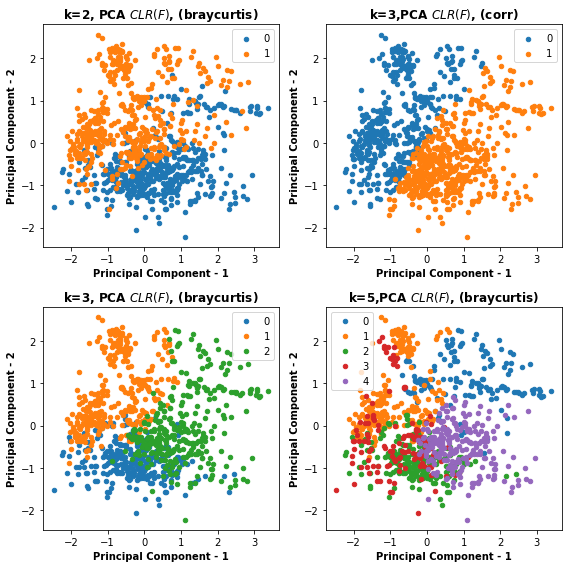

In [16]:
##for CLRf
labels_list=[]
ARI_list=[]
from scipy.spatial import distance as scipy_spatial_distance
fig2 = plt.figure(figsize=(8, 8))
ax1 = fig2.add_subplot(2,2, 1)
km_obj, siScore, predStrengths = do_kmedoids(
    pca_vals_df, [2], metrics_list=['braycurtis'], show_fig=False)
df_labelled = pca_vals_df.copy()
df_labelled['cluster_id'] = km_obj.labels_
ax1, PCA_object = plot_PCA(
    ax1, df_labelled, pca_column_names, plot_nonStandard_PCA=True, label_key='cluster_id')
ax1.set_title(r'k=2, PCA $CLR(F)$, (braycurtis)',
              fontweight='bold')
labels_list.append(df_labelled['cluster_id'])

ax2 = fig2.add_subplot(2,2, 2)
km_obj2, siScore2, predStrengths2 = do_kmedoids(
    pca_vals_df, [2], metrics_list=['correlation'], show_fig=False)
df_labelled2 = pca_vals_df.copy()
df_labelled2['cluster_id'] = km_obj2.labels_
ax2, PCA_object = plot_PCA(
    ax2, df_labelled2, pca_column_names, plot_nonStandard_PCA=True, label_key='cluster_id')
ax2.set_title(r'k=3,PCA $CLR(F)$, (corr)', fontweight='bold')
labels_list.append(df_labelled2['cluster_id'])



ax3 = fig2.add_subplot(2,2, 3)
km_obj, siScore, predStrengths = do_kmedoids(
    pca_vals_df, [3], metrics_list=['braycurtis'], show_fig=False)
df_labelled = pca_vals_df.copy()
df_labelled['cluster_id'] = km_obj.labels_
ax3, PCA_object = plot_PCA(
    ax3, df_labelled, pca_column_names, plot_nonStandard_PCA=True, label_key='cluster_id')
ax3.set_title(r'k=3, PCA $CLR(F)$, (braycurtis)',
              fontweight='bold')
labels_list.append(df_labelled['cluster_id'])

ax4 = fig2.add_subplot(2,2, 4)
km_obj2, siScore2, predStrengths2 = do_kmedoids(
    pca_vals_df, [5], metrics_list=['braycurtis'], show_fig=False)
df_labelled2 = pca_vals_df.copy()
df_labelled2['cluster_id'] = km_obj2.labels_
ax4, PCA_object = plot_PCA(
    ax4, df_labelled2, pca_column_names, plot_nonStandard_PCA=True, label_key='cluster_id')
ax4.set_title(r'k=5,PCA $CLR(F)$, (braycurtis)', fontweight='bold')
labels_list.append(df_labelled2['cluster_id'])



fig2.patch.set_facecolor('white')
plt.tight_layout()
plt.savefig(summary_folder+'poor_clustering.pdf')
plt.show()
 

# fig2 = plt.figure(figsize=(5, 5))
# ax = fig2.add_subplot()
# ARI_array=np.zeros(16).reshape(4,4)
# for i,j in itertools.combinations(np.arange(4),2):
#     ARI_score=adjusted_rand_score(labels_list[i], labels_list[j])
#     print (ARI_score)
#     ARI_array[i,j]=ARI_score
#     ARI_array[j,i]=ARI_score
# for i in np.arange(4): ARI_array[i,i]=1.

# sns.heatmap(ARI_array,cmap='RdBu',ax=ax,vmin=0,vmax=1.)
# ax.set_title('ARI_score')
# ax.set_xticklabels(['euclid','corr','BC', 'manhatt'])
# ax.set_yticklabels(['euclid','corr','BC', 'manhatt'])
# fig2.patch.set_facecolor('white')

# plt.tight_layout()



plotting PCA without standardizing.
Explained variation per principal component: [0.37511737 0.29278771]
plotting PCA without standardizing.
Explained variation per principal component: [0.37511737 0.29278771]
plotting PCA without standardizing.
Explained variation per principal component: [0.37511737 0.29278771]
plotting PCA without standardizing.
Explained variation per principal component: [0.37511737 0.29278771]


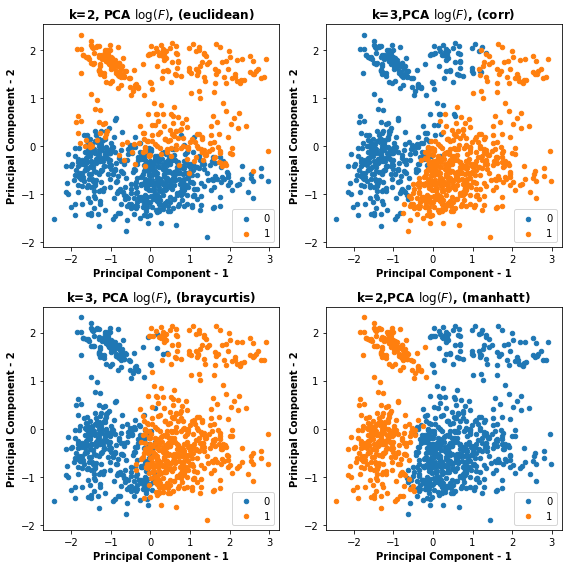

NameError: name 'itertools' is not defined

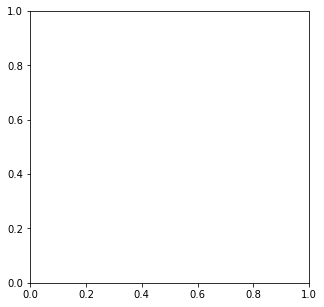

In [43]:
##for logF
labels_list=[]
ARI_list=[]
from scipy.spatial import distance as scipy_spatial_distance
fig2 = plt.figure(figsize=(8, 8))
ax1 = fig2.add_subplot(2,2, 1)
km_obj, siScore, predStrengths = do_kmedoids(
    pca_vals_df, [2], metrics_list=['euclidean'], show_fig=False)
df_labelled = pca_vals_df.copy()
df_labelled['cluster_id'] = km_obj.labels_
ax1, PCA_object = plot_PCA(
    ax1, df_labelled, pca_column_names, plot_nonStandard_PCA=True, label_key='cluster_id')
ax1.set_title(r'k=2, PCA $\log (F)$, (euclidean)',
              fontweight='bold')
labels_list.append(df_labelled['cluster_id'])

ax2 = fig2.add_subplot(2,2, 2)
km_obj2, siScore2, predStrengths2 = do_kmedoids(
    pca_vals_df, [2], metrics_list=['correlation'], show_fig=False)
df_labelled2 = pca_vals_df.copy()
df_labelled2['cluster_id'] = km_obj2.labels_
ax2, PCA_object = plot_PCA(
    ax2, df_labelled2, pca_column_names, plot_nonStandard_PCA=True, label_key='cluster_id')
ax2.set_title(r'k=3,PCA $\log (F)$, (corr)', fontweight='bold')
labels_list.append(df_labelled2['cluster_id'])



ax3 = fig2.add_subplot(2,2, 3)
km_obj, siScore, predStrengths = do_kmedoids(
    pca_vals_df, [2], metrics_list=['braycurtis'], show_fig=False)
df_labelled = pca_vals_df.copy()
df_labelled['cluster_id'] = km_obj.labels_
ax3, PCA_object = plot_PCA(
    ax3, df_labelled, pca_column_names, plot_nonStandard_PCA=True, label_key='cluster_id')
ax3.set_title(r'k=3, PCA $\log (F)$, (braycurtis)',
              fontweight='bold')
labels_list.append(df_labelled['cluster_id'])

ax4 = fig2.add_subplot(2,2, 4)
km_obj2, siScore2, predStrengths2 = do_kmedoids(
    pca_vals_df, [2], metrics_list=['manhattan'], show_fig=False)
df_labelled2 = pca_vals_df.copy()
df_labelled2['cluster_id'] = km_obj2.labels_
ax4, PCA_object = plot_PCA(
    ax4, df_labelled2, pca_column_names, plot_nonStandard_PCA=True, label_key='cluster_id')
ax4.set_title(r'k=2,PCA $\log (F)$, (manhatt)', fontweight='bold')
labels_list.append(df_labelled2['cluster_id'])



fig2.patch.set_facecolor('white')
plt.tight_layout()
plt.savefig(summary_folder+'poor_clustering.pdf')
plt.show()
 

fig2 = plt.figure(figsize=(5, 5))
ax = fig2.add_subplot()
ARI_array=np.zeros(16).reshape(4,4)
for i,j in itertools.combinations(np.arange(4),2):
    ARI_score=adjusted_rand_score(labels_list[i], labels_list[j])
    print (ARI_score)
    ARI_array[i,j]=ARI_score
    ARI_array[j,i]=ARI_score
for i in np.arange(4): ARI_array[i,i]=1.

sns.heatmap(ARI_array,cmap='RdBu',ax=ax,vmin=0,vmax=1.)
ax.set_title('ARI_score')
ax.set_xticklabels(['euclid','corr','BC', 'manhatt'])
ax.set_yticklabels(['euclid','corr','BC', 'manhatt'])
fig2.patch.set_facecolor('white')

plt.tight_layout()



## Spectral Clustering

- spectral clustring looks like a promising approach, but need to implement a method to find an optimal 'k'

(based on finding spectral gap or self-tuning of sigma...
http://www.vision.caltech.edu/lihi/Demos/SelfTuningClustering.html
https://github.com/ciortanmadalina/high_noise_clustering
https://towardsdatascience.com/spectral-graph-clustering-and-optimal-number-of-clusters-estimation-32704189afbe
https://www.kdnuggets.com/2020/05/getting-started-spectral-clustering.html)


implementing spectral clustering from scratch:
https://juanitorduz.github.io/spectral_clustering/

implementing automated choice of number of optimal clusters:
https://towardsdatascience.com/spectral-graph-clustering-and-optimal-number-of-clusters-estimation-32704189afbe

/Users/ashish/anaconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


plotting PCA without standardizing.
Explained variation per principal component: [0.3  0.24]


/Users/ashish/anaconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


plotting PCA without standardizing.
Explained variation per principal component: [0.3  0.24]


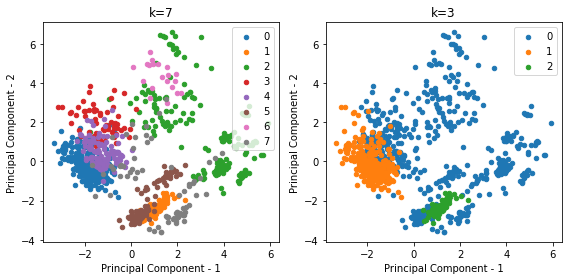

In [64]:
from sklearn.cluster import SpectralClustering

df_labelled = df_msa_logF.copy()
df_labelled['cluster_id'] = km_obj.labels_



# data_df['cluster'] = ['c_' + str(c) for c in data_df['cluster']]
fig2 = plt.figure(figsize=(8, 4))
ax1 = fig2.add_subplot(1, 2, 1)

spec_cl = SpectralClustering(
    n_clusters=8, random_state=25, n_neighbors=10, affinity='nearest_neighbors')
df_labelled['cluster_id'] = spec_cl.fit_predict(df_labelled[emp_naics_keys])
ax1, PCA_object = plot_PCA(
    ax1, df_labelled, emp_naics_keys, plot_nonStandard_PCA=True, label_key='cluster_id')
ax1.set(title='k=7')

ax2 = fig2.add_subplot(1, 2, 2)
spec_cl = SpectralClustering(
    n_clusters=3, random_state=25, n_neighbors=10, affinity='nearest_neighbors')
df_labelled['cluster_id'] = spec_cl.fit_predict(df_labelled[emp_naics_keys])
ax2, PCA_object = plot_PCA(
    ax2, df_labelled, emp_naics_keys, plot_nonStandard_PCA=True, label_key='cluster_id')
ax2.set(title='k=3')
fig2.patch.set_facecolor('white')
plt.tight_layout()

implemntation of choosing silhouette score/ prediction strenght isn't straigtforward...

In [ ]:
def do_spectralClustering(df_data, k_list=range(1, 10), beta=1.,metrics_list=["euclidean"],
                          test_split=0.5, ps_avgs=2, show_fig=True):
    '''
    performs spectral clustering
    '''
    sse = []
    silhouette_list = []
    pred_strengths = []
    for metric_idx, distance_metric in enumerate(metrics_list):
        sse.append([])
        silhouette_list.append([])
        pred_strengths.append([])
        Distances = compute_pairwise_distances(df_data.values, distance_metric)
        similarity = np.exp(-beta * Distances / distance.std())
        for k in k_list:
            spec_cl = SpectralClustering(n_clusters=k,  random_state=25, 
                                         n_neighbors=10, affinity='precomputed')

            spec_cl.fit(similarity)
#             sse[metric_idx].append([k, km.inertia_])

            if k >= 2:
                si_score = silhouette_score(
                    Distances, spec_cl.labels_, metric="precomputed")
                silhouette_list[metric_idx].append([k, si_score])

                # calculate prediction strength
                p_strengths = np.empty(0)
                for i in range(ps_avgs):
                    X_train, X_test = train_test_split(
                        df_data.values, test_size=test_split, stratify=spec_cl.labels_)
                    train_distances = compute_pairwise_distances(
                        X_train, distance_metric)
                    train_similarity = np.exp(-beta * train_distances / distance.std())
                    test_distances = compute_pairwise_distances(
                        X_test, distance_metric)
                    test_similarity = np.exp(-beta * test_distances / distance.std())

                    model_train  = SpectralClustering(n_clusters=k,  random_state=25, 
                                         n_neighbors=10, affinity='precomputed')
                    model_train.fit(train_similarity)
                    
                    model_test = SpectralClustering(n_clusters=k,  random_state=25, 
                                         n_neighbors=10, affinity='precomputed')
                    model_test.fit(test_similarity)
                    
                    clusterCenters = X_train[model_train.medoid_indices_]
                    p_strength = get_prediction_strength(
                        k, clusterCenters, X_test, model_test.labels_, distance_metric=distance_metric)
                    p_strengths = np.append(p_strengths, p_strength)
                    p_strengths = np.append(p_strengths, 0.)
                pred_strengths[metric_idx].append(
                    [k, np.mean(p_strengths), np.std(p_strengths)/np.sqrt(ps_avgs)])
    if show_fig:
        color_list = create_color_list(scheme_name='sns_tab10')
        fig = plt.figure(figsize=(6, 12))
        fs = 12
        ax1 = fig.add_subplot(3, 1, 1)
        for metric_idx, distance_metric in enumerate(metrics_list):
            ax1.plot(pd.DataFrame(silhouette_list[metric_idx])[
                     0], pd.DataFrame(silhouette_list[metric_idx])[1], marker='o', color=color_list[metric_idx], label=distance_metric)
        ax1.plot(ax1.get_xlim(), [.25, 0.25], 'k--')
        ax1.legend(loc='best')
        ax1.set_title('Silhouette score', fontsize=fs, fontweight='bold')
        ax1.set_xlabel('Number of clusters', fontsize=fs, fontweight='bold')
        ax1.set_ylabel('Silhouette score', fontsize=fs, fontweight='bold')

        ax2 = fig.add_subplot(3, 1, 2)
        for metric_idx, distance_metric in enumerate(metrics_list):
            ax2.errorbar(pd.DataFrame(pred_strengths[metric_idx])[
                0], pd.DataFrame(pred_strengths[metric_idx])[1], yerr=pd.DataFrame(pred_strengths[metric_idx])[2], color=color_list[metric_idx], label=distance_metric)
        ax2.plot(ax2.get_xlim(), [.8, 0.8], 'k--')
        ax2.legend(loc='best')
        ax2.set_title('Prediction Strength', fontsize=fs, fontweight='bold')
        ax2.set_xlabel('Number of clusters', fontsize=fs, fontweight='bold')
        ax2.set_ylabel('Prediction Strength', fontsize=fs, fontweight='bold')

        ax3 = fig.add_subplot(3, 1, 3)
        for metric_idx, distance_metric in enumerate(metrics_list):
            sse_values = pd.DataFrame(sse[metric_idx])[1]
            scaled_sse = sse_values/np.max(sse_values)
            ax3.plot(pd.DataFrame(sse[metric_idx])[
                     0], scaled_sse, color=color_list[metric_idx], marker='o', label=distance_metric)
        ax3.legend(loc='best')
        ax3.set_title('Elbow Method', fontsize=fs, fontweight='bold')
        ax3.set_xlabel('Number of clusters', fontsize=fs, fontweight='bold')
        ax3.set_ylabel('Scaled SSE/Inertia', fontsize=fs, fontweight='bold')
        plt.tight_layout()
        fig.patch.set_facecolor('white')

    if len(k_list) == 1 and len(metrics_list) == 1:  # return fit object and si score              
        return km, np.ravel(silhouette_list), np.ravel(pred_strengths)
    else:
        if show_fig:
            return sse, silhouette_list, pred_strengths, fig
        else:
            return sse, silhouette_list, pred_strengths, None

    

## Non/metric Multi-Dimensional Scaling (MDS)

In [13]:
from sklearn.manifold import MDS

def MDS_StressPlot(distances,D_list, ax, fs=10, ms=10,mds=False):
    normalized_stress_list=[]
    sum_sqrd_dists=np.sum(np.square(np.ravel(distances)))/2.
    for n_comp in D_list:   
        MDS_obj = MDS(n_components=n_comp,metric=mds, dissimilarity='precomputed', random_state=1,n_jobs=4)
        MDS_obj.fit_transform(distances)
        ## scikit learn just returns sum of squared disparities so normalization is required
        normalized_stress=np.sqrt(MDS_obj.stress_/sum_sqrd_dists) 
        
        normalized_stress_list.append(normalized_stress)
        
    ax.plot(D_list,normalized_stress_list,'-o')
    ax.set_xlabel('# MDS Components', fontsize=fs)
    ax.set_ylabel('Stress', fontsize=fs)     
    return ax



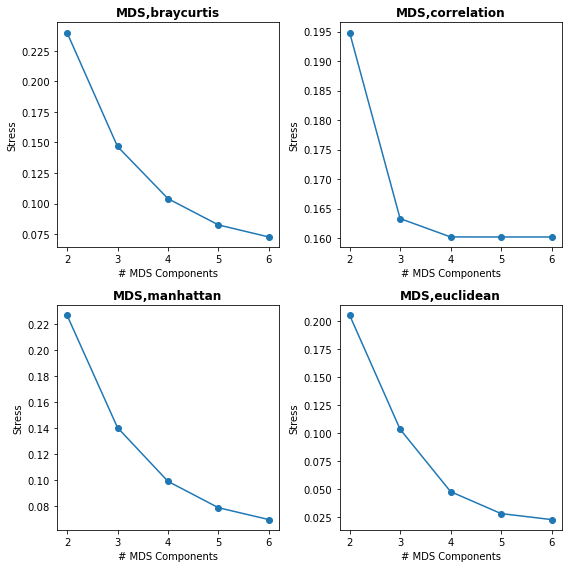

In [16]:
D_list=np.arange(5)+2
fig2 = plt.figure(figsize=(8, 8))
ax1 = fig2.add_subplot(2, 2, 1)
pwise_distances=compute_pairwise_distances(df_msa_logF[emp_naics_keys], 'braycurtis')
ax1=MDS_StressPlot(pwise_distances,D_list, ax1,mds=True)
ax1.set_title(r'MDS,braycurtis', fontweight='bold')
ax2 = fig2.add_subplot(2, 2, 2)
pwise_distances=compute_pairwise_distances(df_msa_logF[emp_naics_keys],'correlation')
ax2=MDS_StressPlot(pwise_distances,D_list, ax2,mds=True)
ax2.set_title(r'MDS,correlation', fontweight='bold')
ax3 = fig2.add_subplot(2, 2, 3)
pwise_distances=compute_pairwise_distances(df_msa_logF[emp_naics_keys], 'manhattan')
ax3=MDS_StressPlot(pwise_distances,D_list, ax3,mds=True)
ax3.set_title(r'MDS,manhattan', fontweight='bold')
ax4 = fig2.add_subplot(2, 2, 4)
pwise_distances=compute_pairwise_distances(df_msa_logF[emp_naics_keys], 'euclidean')
ax4=MDS_StressPlot(pwise_distances,D_list, ax4,mds=True)
ax4.set_title(r'MDS,euclidean', fontweight='bold')
fig2.patch.set_facecolor('white')
plt.tight_layout()
plt.show()

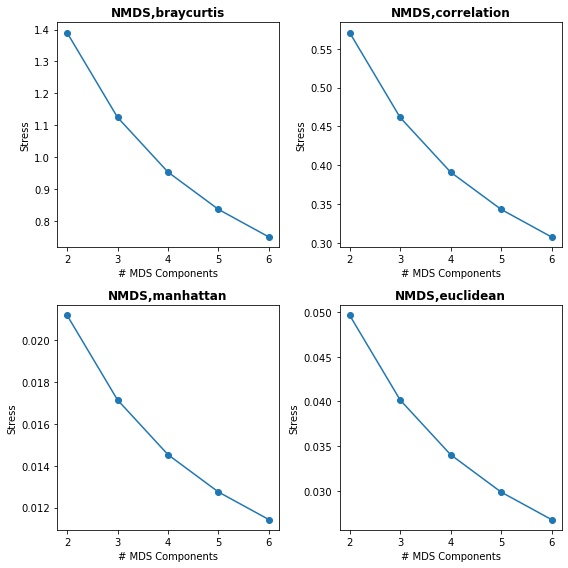

TypeError: compute_pairwise_distances() got an unexpected keyword argument 'mds'

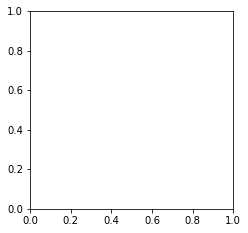

In [15]:


fig2 = plt.figure(figsize=(8, 8))
ax1 = fig2.add_subplot(2, 2, 1)
pwise_distances=compute_pairwise_distances(df_msa_logF[emp_naics_keys], 'braycurtis')
ax1=MDS_StressPlot(pwise_distances,D_list, ax1)
ax1.set_title(r'NMDS,braycurtis', fontweight='bold')
ax2 = fig2.add_subplot(2, 2, 2)
pwise_distances=compute_pairwise_distances(df_msa_logF[emp_naics_keys],'correlation')
ax2=MDS_StressPlot(pwise_distances,D_list, ax2)
ax2.set_title(r'NMDS,correlation', fontweight='bold')
ax3 = fig2.add_subplot(2, 2, 3)
pwise_distances=compute_pairwise_distances(df_msa_logF[emp_naics_keys], 'manhattan')
ax3=MDS_StressPlot(pwise_distances,D_list, ax3)
ax3.set_title(r'NMDS,manhattan', fontweight='bold')
ax4 = fig2.add_subplot(2, 2, 4)
pwise_distances=compute_pairwise_distances(df_msa_logF[emp_naics_keys], 'euclidean')
ax4=MDS_StressPlot(pwise_distances,D_list, ax4)
ax4.set_title(r'NMDS,euclidean', fontweight='bold')

fig2.patch.set_facecolor('white')
plt.tight_layout()
plt.show()






## HDBSCAN

hdbscan with default parameters finds 15-20 clusters depending on the metric. It also leaves many points unlabelled. 
Parameter exploration is required. We need it to give relatively consistent results across distance metrics.

In [18]:
import hdbscan
HDBcluster_BC = hdbscan.HDBSCAN( metric='braycurtis')
HDBcluster_BC.fit(df_msa_logF[emp_naics_keys])
print('number of clusters in HDBscan Bray-Curtis=', np.max(HDBcluster_BC.labels_))
print('fraction of cities classified Bray-Curtis', np.count_nonzero(HDBcluster_BC.labels_+1)
      *1./len(HDBcluster_BC.labels_))
HDBcluster_Eu = hdbscan.HDBSCAN( metric='euclidean')
HDBcluster_Eu.fit(df_msa_logF[emp_naics_keys])
print('number of clusters in HDBscan, Euclidean=', np.max(HDBcluster_Eu.labels_))
print('fraction of cities classified, Euclidean= ', np.count_nonzero(HDBcluster_Eu.labels_+1)
      *1./len(HDBcluster_Eu.labels_))
HDBcluster_Mh = hdbscan.HDBSCAN( metric='manhattan')
HDBcluster_Mh.fit(df_msa_logF[emp_naics_keys])
print('number of clusters in HDBscan, Manhattan=', np.max(HDBcluster_Mh.labels_))
print('fraction of cities classified, Manhattan= ', np.count_nonzero(HDBcluster_Mh.labels_+1)
      *1./len(HDBcluster_Mh.labels_))
HDBcluster_Cr = hdbscan.HDBSCAN( metric='correlation')
HDBcluster_Cr.fit(df_msa_logF[emp_naics_keys])
print('number of clusters in HDBscan, Correlation=', np.max(HDBcluster_Cr.labels_))
print('fraction of cities classified, Correlation= ', np.count_nonzero(HDBcluster_Cr.labels_+1)
      *1./len(HDBcluster_Cr.labels_))

number of clusters in HDBscan Bray-Curtis= 18
fraction of cities classified Bray-Curtis 0.647374062165059
number of clusters in HDBscan, Euclidean= 22
fraction of cities classified, Euclidean=  0.8842443729903537
number of clusters in HDBscan, Manhattan= 15
fraction of cities classified, Manhattan=  0.5819935691318328
number of clusters in HDBscan, Correlation= 21
fraction of cities classified, Correlation=  0.4790996784565916


Explained variation per principal component: [0.18631577 0.11583667]


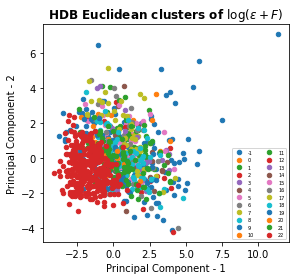

In [24]:


fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(1,2,1)
df_labelled = df_msa_logF.copy()
df_labelled['cluster_id'] = HDBcluster_Eu.labels_
ax1, PCA_object = plot_PCA(
    ax1, df_labelled, emp_naics_keys, standardized=False, label_key='cluster_id')
ax1.set_title(r'HDB Euclidean clusters of $\log (\epsilon +F)$', fontweight='bold')

# ax2 = fig2.add_subplot(1, 2, 2)
# km_obj2, siScore2, predStrengths2 = do_kmeans(df_msa_fractions[emp_naics_keys],[2], show_fig=False)
# df_labelled2 = df_msa_logF.copy()
# df_labelled2['cluster_id'] = km_obj2.labels_
# ax2, PCA_object = plot_PCA(
#     ax2, df_labelled2, emp_naics_keys, standardized=False, label_key='cluster_id')
# ax2.set_title(r'k=2, PCA of fractions', fontweight='bold')

fig.patch.set_facecolor('white')
plt.tight_layout()
plt.show()

In [4]:
column_list=[i for i in range(3)]

In [5]:
column_list

[0, 1, 2]